# import libraries

In [1]:
#--- system libraries
import pdb
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
import traceback
import os
import scipy.interpolate as scp_int
import warnings
import matplotlib
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib import patches
import sys
import sklearn
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
import patsy
import sklearn
from sklearn import linear_model, mixture
import sklearn.mixture as skm
from scipy import optimize
import scipy
import re
from scipy.stats import norm, kurtosis
from pandas.plotting import scatter_matrix
from scipy.ndimage import gaussian_filter
import time
from scipy import ndimage
from scipy.stats import chi2
from scipy.optimize import curve_fit
#
warnings.filterwarnings('ignore')

#--- user modules
import LammpsPostProcess2nd as lp
import imp
imp.reload(lp)

<module 'LammpsPostProcess2nd' from '/Users/Home/Desktop/Tmp/txt/git/CrystalPlasticity/postprocess/LammpsPostProcess2nd.py'>

# utility functions

In [919]:
def GetMismatchIco(atoms,box,
                   df_comp,
                   xlin,ylin,zlin,
                  ):
    nx,ny,nz = len(xlin), len(ylin), len(zlin)
    #--- partition box & assign index to each atom
    wrap = lp.Wrap(atoms,box)
    wrap.WrapCoord() #--- wrap inside
    wrap.Set(atoms)
    assert np.sum(wrap.isInside()) == len(atoms.x)
    wrap.GetDimensionlessCords()
    AtomCellId = (wrap.beta * np.array([nx,ny,nz])).astype(int)
    #--- store in a df
#    pdb.set_trace()
    tmp=df_comp.set_index(['indxx','indxy','indxz'])
    return tmp.loc[list(AtomCellId)]['deltaa'].to_list()

def GetComp( atoms, atomf ):
    #--- different types
    types = list(set(atomf.type))
    types.sort()
    ntype=len(types)
    c=np.zeros(ntype) #{}
    n = len(atoms.x)
    for typei,indxx in zip(types,range(ntype)):
#        c[typei] = 1.0*np.sum(atoms.type == typei)/n
        c[indxx] = 1.0*np.sum(atoms.type == typei)/n

    return c

def GetDelta(df, AtomicRadius):
    size = list(map(AtomicRadius.get,list(map(int,df['type'].tolist()))))
    assert len(size) == len(df)
    df = pd.DataFrame(np.c_[df,size],columns=list(df.keys())+['size'])
    assert df['size'].mean() > 0.0
    assert df['size'].std() >= 0.0, 'increase size!'
    return df['size'].std()/df['size'].mean()

def GetPressComp( atoms,box, dmean, AtomicRadius, **kwargs ):
#    pdb.set_trace()
    #--- grid: tiling mapped box with original size
    (xlin, ylin, zlin), (xv, yv, zv) = lp.GetCubicGrid( box.CellOrigin, 
                                                     box.CellVector, 
                                                     dmean,
                                                     margin = 0.0 * dmean, odd = False )
    xi = np.array(list(zip(xv.flatten(), yv.flatten(), zv.flatten())))
    dvol = (xlin[1]-xlin[0])*(ylin[1]-ylin[0])*(zlin[1]-zlin[0])
    (ny,nx,nz) = xv.shape
#     nx -= 1
#     ny -= 1
#     nz -= 1
    assert nx*ny*nz >= 8, 'decrease division length!'
    print(dmean,nx*ny*nz)
    #--- indices
    (xvi, yvi, zvi) = np.meshgrid(np.arange(0,nx),np.arange(0,ny),np.arange(0,nz))
    indices = np.array(list(zip(xvi.flatten(), yvi.flatten(), zvi.flatten()))) #--- shape:(ncel,3)
    indices = list(map(lambda x: tuple(x),indices))

    #--- partition box & assign index to each atom
    wrap = lp.Wrap(atoms,box)
    wrap.WrapCoord() #--- wrap inside
    wrap.Set(atoms)
    assert np.sum(wrap.isInside()) == len(atoms.x)
    wrap.GetDimensionlessCords()
    AtomCellId = (wrap.beta * np.array([nx,ny,nz])).astype(int)
    #--- store in a df
    df = pd.DataFrame(np.c_[pd.DataFrame(atoms.__dict__),AtomCellId],
                         columns=list(pd.DataFrame(atoms.__dict__).keys())+['ix','iy','iz'])
    df['ix']=df['ix'].astype(int)
    df['iy']=df['iy'].astype(int)
    df['iz']=df['iz'].astype(int)
#    display(df.head())

    #--- group & compute p and c
    d = df.groupby(by=['ix','iy','iz']).groups
    assert len(d) == nx*ny*nz, 'empty boxes!'
#     #--- lambda function: compute p 
#     f = lambda x: np.sum(np.sum(np.array(x.sxx)+np.array(x.syy)+np.array(x.szz)))*(-1.0e-4/3.0/dvol)
#     vol=np.linalg.det(box.CellVector)
#    pdb.set_trace()
    #
    
    keys = d.keys()
    plist = list(map(lambda x:GetDelta(df.iloc[d[x]],AtomicRadius),keys)) #--- len(plist) = ncell
    clist = list(map(lambda x:GetComp(df.iloc[d[x]],atoms),keys)) #--- clist[icell]={1:c1,2:c2, ...}

    #--- make a data frame
    types = list(set(atoms.type))
    types.sort()
    cols = list(map(lambda x:'Type%s'%x,types))
#    pdb.set_trace()
    df_comp = pd.DataFrame(np.concatenate((np.c_[indices],np.c_[xi],np.c_[clist],np.c_[plist]),
                                          axis=1,dtype=np.object),
                           columns=['indxx','indxy','indxz','x','y','z']+cols+['deltaa'])
    
#    pdb.set_trace()
    #---
    
    
    #--- read file: elastic constants
#     if 'MODU' in kwargs and kwargs['MODU']:
#         fileName = kwargs['PATH']
#         modu = pd.read_csv(fileName, sep=' ',header=0)
# #        display(modu.head())
#         if 'PLOT' in kwargs and kwargs['PLOT']:
#             plott(modu['C66'],nx,ny,nz,box,zlin, 'muCG.png')

    #--- plot
    #--- reshape value


        
#        display(modu.head())
#     if 'MODU' in kwargs and kwargs['MODU']:
#         mlist = modu['C66'].to_list()
#         return clist, plist, mlist
#     else:
    return (xlin,ylin,zlin), df_comp

def PltBinary(xlin,ylin,zlin, 
              val,
              box0,
              thresh = 0.0,
              **kwargs,
             ):
    #--- reshape value
    (nx,ny,nz) = len(xlin), len(ylin),len(zlin) 
    value = np.c_[val].reshape(((ny,nx,nz)))

    #--- mean & variance

    #--- xy plane
    #--- 2d slice
    nzl=[0]
    value2d = Get2dSlice( value, zlin, 
                        zlin[-1], nzll=nzl  )
    #--- plot
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector ) #--- box length
    PltBitmap(value2d<thresh, 
              xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
              frac = 1.0, #--- plot a patch
              **kwargs
            )
    return value

def GetVolume(lmpData,itimee):
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itimee], AddMissing = np.array([0.0,0.0,0.0] ))
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector )
    return np.linalg.det( CellVectorOrtho )



def row_histogram(a):
    ca = np.ascontiguousarray(a).view([('', a.dtype)] * a.shape[1])
    unique, indices, inverse = np.unique(ca, return_index=True, return_inverse=True)
    counts = np.bincount(inverse)
    sort_indices = np.argsort(counts)[::-1]
    return (a[indices[sort_indices]], counts[sort_indices])


        
def GetMotifs( lmpData, times, Plot = True ):
    Unique_indices={}
    Counts = {}
    for itime in times:
        vor = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='list') )
        #
        voro_indices = np.c_[vor.VoronoiIndex3,vor.VoronoiIndex4,vor.VoronoiIndex5,vor.VoronoiIndex6].astype(int)
        # Compute frequency histogram.

        unique_indices, counts = row_histogram(voro_indices)
        Unique_indices[itime]=unique_indices[:]
        Counts[itime]=100.0*counts/len(voro_indices)
        #
        # Print the ten most frequent histogram entries.
        if Plot:
            for i in range(10):
                print("%s\t%i\t(%.1f %%)" % (tuple(unique_indices[i]), 
                                         counts[i], 
                                         100.0*float(counts[i])/len(voro_indices)))
                plt.bar(str(tuple(unique_indices[i])), 100.0*float(counts[i])/len(voro_indices),color='C0')
            #
#             plt.yscale('log')
#             plt.ylim(.1,100)
            plt.xlabel('Voronoi Index(n3,n4,n5,n6)',fontsize=16)
            plt.ylabel('Percentage',fontsize=16)
            plt.tick_params(labelrotation=90,labelsize=16)
            #
            plt.savefig('motifs.png',dpi=75,bbox_inches='tight')
            plt.show()
            
    return Unique_indices, Counts


def PdfCondD2min( lmpData, lmpDmin, times,     
                  Plot = True, title='pdfCondD2min.png',
                 axisLabels = True,
                ):
    #--- plot
    if Plot:
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111)
        #
        ax.set_yscale('log')
        #ax.set_xscale('log')
        #
        ax.set_ylim(1,1e4)
        ax.set_xlim(-1,3)
        #
        if axisLabels:
            ax.set_xlabel(r'log$D^2$min($A^2$)',fontsize=16)
            ax.set_ylabel(r'PDF',fontsize=16)
        #
        #ax.set_title(r'itime=%s'%itime)
        #
        PutMinorTicks( ax, LOGY = True)
        #
        ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)

    valueFiltrd = {}
    valueTot = {}
    for itimee in sorted(times): 

        # strain
        ebulk = GetStrain(lmpData, itimee, 0 )
#         if ebulk == 0.0:
#             continue

        #--- d2min and vor
        d2min = lp.Atoms( **lmpDmin.coord_atoms_broken[itimee].to_dict(orient='list') )
        vor = lp.Atoms( **lmpData.coord_atoms_broken[itimee].to_dict(orient='list') )

        #--- filter
        indices = GetFullIcosahedra( vor )

        #--- histogram: total
        value = valueTot[itimee]=np.array(d2min.d2min)
        hist, edges, error = GetPDF( np.log10(value), 
                                    linscale = True, 
                                    n_per_decade=32,
                                    density = False,
                                   )
        #--- filtered
        value = valueFiltrd[ itimee ] = np.array(d2min.d2min)[indices]
        hist_filtrd, edges_filtrd, error_filtrd = GetPDF( np.log10(value), 
                                                         linscale = True, 
                                                         n_per_decade=32,
                                                         density = False,
                                                        )
        #--- invert
        valinv = np.array(d2min.d2min)[~indices]
        hist_inv, edges_inv, error_inv = GetPDF( np.log10(valinv), 
                                                linscale = True, 
                                                n_per_decade=32,
                                                density = False,
                                               )


        if Plot:
            attr = { 'markersize':10,'markeredgewidth':0.7,
                     'linewidth':.5,'barsabove':None,'capsize':5,
                     'capthick':1,'elinewidth':1}
            #
    #             ax.errorbar(edges,hist,error,fmt='-o',
    #                         markersize=8,markeredgewidth=0.7,
    #                         linewidth=.5,
    #                          barsabove=None,capsize=5,capthick=1,elinewidth=1,label='Total')
                #
            ax.errorbar(edges_filtrd,hist_filtrd,error_filtrd,
                        **attr,
                        fmt='-o', color='black', 
                        markerfacecolor='white', markeredgecolor=None,
                        label='Icosahedra', markevery = int(len(edges_filtrd)/10),
                        errorevery = int(len(edges_filtrd)/10),
                       )
            #
            ax.errorbar(edges_inv,hist_inv,error_inv,
                        **attr,
                        fmt='-s', color='red',
                        markerfacecolor=None, markeredgecolor='black',
                        label='Non Icosahedra',markevery = int(len(edges_inv)/10),
                        errorevery = int(len(edges_inv)/10),
                       )
    #
    if Plot:
        ax.legend(frameon=False, fontsize=12)
        #
        DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04,LOG_Y=True)
        #
        plt.savefig(title,dpi=2*75,bbox_inches='tight',pad_inches=0.0)
        plt.show()

    return valueFiltrd,valueTot


def PlotPaperVersion(pathh_indx,file0_indx,**kwargs):
    verbose = True if 'verbose' in kwargs and kwargs['verbose'] == True else False
    #--- setup symbols
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']

    #--- plot
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #
    #
    if 'ylabel' in kwargs:
        ax.set_ylabel(kwargs['ylabel'],fontsize=20)
    if 'xlabel' in kwargs:
        ax.set_xlabel(kwargs['xlabel'],fontsize=20)
    ax.tick_params(labelsize=20)
    #
    for mg, marker, color, fillstyle in list(zip( [ 
                                         'FeNi',
                                           'CoNiFe',
                                           'CoNiCrFe',
                                            'CoCrFeMn',
                                            'CoNiCrFeMn',
                                            'Co5Cr2Fe40Mn27Ni26'
                                        ],markers, colors, fillstyles )):
        if 'glass' in kwargs and kwargs['glass'] != mg:
            continue
            
        Xdata = []#None
        Ydata = []#None
        #--- loop over realizations 
        for irun in [0,1,2]:
            xdata_timeseries = []
            ydata_timeseries = []
        #--- loop over time
    #        for itimee, marker, color, fillstyle in list(zip( [0,50,101,120,195],
    #                                                          markers, colors, fillstyles)): #:
            for itimee in range(0,200+1,2): #range(0,201,1): #(0,208,8):
            #--- store ensemble average

                pathh = { 
                          0:'%s/PairCrltnT300/%s/Run%s'%(os.getcwd(),mg,irun),
                          1:'%s/VorAnlT300/%s/Run%s'%(os.getcwd(),mg,irun),
                          2:'%s/D2minAnalysisT300/%s/Run%s'%(os.getcwd(),mg,irun),
                          3:'%s/ElasticityT300/%s/itime%s/Run%s'%(os.getcwd(),mg,itimee,irun),
                          4:'%s/ElasticityT300/%s/itime%s/Run%s/ModuAnl'%(os.getcwd(),mg,itimee,irun),
                        }[pathh_indx]
                file0 = {
                          0:'%s/gr.txt'%pathh,
                          1:'%s/icoPercentageWithStrain.txt'%pathh,
                          2:'%s/d2min_gamma.txt'%pathh,
                          3:'%s/rc_d2min.txt'%pathh,
                          4:'%s/crsD2minRhoSro.txt'%pathh,
                          5:'%s/NegativeModulus.txt'%pathh, 
                          6:'%s/YieldDelta.txt'%pathh, 
                          7:'%s/gr_peak_gamma.txt'%pathh, 
                          8:'%s/muClustersize_gamma.txt'%pathh, 
                          9:'%s/pdfMu.txt'%pathh, 
                          10:'%s/mu_mean_std.txt'%pathh, 
                          11:'%s/mu_mean_std.txt'%pathh, 
                          12:'%s/pdfClsSize.txt'%pathh,
                          13:'%s/muClustersize_gamma.txt'%pathh, 
                          14:'%s/muClustersize_gamma.txt'%pathh, 
                          15:'%s/muClustersize_gamma.txt'%pathh, 
                        }[file0_indx]
#                print(file0)
                xdata = [np.nan]
                ydata = [np.nan]
                erry = [np.nan]
                if os.path.isfile( file0 ): # and os.path.isfile( file1 ):
#                    os.system('cat %s >> crMuRho_concat.txt' %file0 )
#                    os.system('cat %s >> mu_size.txt'%file1)
                
                    #--- load data
                    sarr = np.loadtxt(file0)
#                    sarr2nd = np.loadtxt(file1)

                    try:

                        #--- assign x, y
    #                    print(sarr.shape)
                        if file0_indx == 5:
                            xdata = np.array([sarr[0]])
                            ydata = np.array([-sarr[1]])
                        elif file0_indx == 6 or file0_indx == 8 or file0_indx == 10 or file0_indx == 13:
                            xdata = np.array([sarr[0]])
                            ydata = np.array([sarr[1]])
                        elif file0_indx == 11 or file0_indx == 14:
                            xdata = np.array([sarr[0]])
                            ydata = np.array([sarr[2]])
                        elif file0_indx == 15:
                            xdata = np.array([sarr[1]])
                            ydata = np.array([sarr[2]])
                        else:
                            xdata = sarr[:,0] #--- x
                            ydata = sarr[:,1] #--- y
                        if file0_indx == 9 or file0_indx == 12:
                            erry = sarr[:,2] #--- error
                            
                        #--- only for shear band width
                        if file0_indx == 3:
                            ydata2 = sarr[:,2] #--- y1
                            #--- remove nan's
                            indices = np.any(~np.isnan(np.c_[ydata,ydata2]),axis=1) #--- true:either x or y is not nan
                            ydata = np.array(list(map(lambda x:np.mean(x[~np.isnan(x)]),np.c_[ydata,ydata2][indices]))) #--- take mean                    
                            xdata = xdata[indices]
                            assert xdata.shape == ydata.shape
                    except:
                        print('error while reading %s'%file0)
                        pass
                    
#                    print(Xdata.shape)
#                    print(xdata,ydata)
#                    print('Xdata=',Xdata,Ydata)
                
                xdata_timeseries += list(xdata) #--- concat different times
                ydata_timeseries += list(ydata)
#                print(xdata_timeseries,ydata_timeseries)
#                print(xdata,ydata)
            #--- ensemble average


            #--- rescale data
            if file0_indx == 15:
                pmax = np.max(xdata_timeseries)
#                print(mg,pmax)
                #
                tmp = np.array(xdata_timeseries)
                tmp.sort()
                q=0.95
                ns=len(tmp)
                pmax = tmp[int(q*ns)]
                #
#                print(mg,pmax)
                xdata_timeseries = 1.0 - np.array( xdata_timeseries ) / pmax 
    
            #--- concat
            try:
                Xdata = np.concatenate((Xdata,xdata_timeseries),axis=0) #--- concat different realizations
                Ydata = np.concatenate((Ydata,ydata_timeseries),axis=0) 
            except:
                traceback.print_exc()
                Xdata = xdata_timeseries.copy()
                Ydata = ydata_timeseries.copy()
                

            if not 'PlotMean' in kwargs or not kwargs['PlotMean']:
                #--- graph-related attributes
#                     attrs={ 
#                             'color':color,
#                             'markersize':10,
#                             'marker':marker,
#                             'markerfacecolor':fillstyle,
#                             'markeredgecolor':'black' if not fillstyle else None,
#                             'label':'%s/irun%s'%(mg,irun),
#                             'markevery':max(1,int(len(xdata)/10.0)),
#                           }
                attrs={ 'color':color,
                        'markersize':10,
                        'marker':marker,
                        'markerfacecolor':fillstyle,
                        'markeredgecolor':'black' if not fillstyle else None,
                        'label':'%s/irun%s'%(mg,irun),
                       'markevery':max(1,int(len(xdata)/10.0)),
                       'errorevery':max(1,int(len(xdata)/10.0)),
                       'markeredgewidth':0.7,
                        'linewidth':1, 
                       'barsabove':None,
                       'capsize':5,
                       'capthick':1,
                       'elinewidth':1,
                       'fmt':'.',
                      }                    
                #--- plot ydata
#                     print(xdata,ydata,erry)
                PltErr(xdata_timeseries,ydata_timeseries, 
                       yerr=None, #erry, #0*ydata,      
                       ax = ax,
                       attrs = attrs,
                       Plot = False,
                       **kwargs,
#                           xerr=yerr0,
                      )
                #--- plot ydata2
#                         PltErr(xdata,ydata2, 
#                                yerr=None, #0*ydata,      
#                                ax = ax,
#                                attrs = attrs,
#                                Plot = False,
#                                **kwargs,
#     #                           xerr=yerr0,
#                               )

    #
        if 'PlotMean' in kwargs and kwargs['PlotMean']:
            Xdata = Xdata[~np.isnan(Ydata)]
            Ydata = Ydata[~np.isnan(Ydata)]
            if verbose:
                print('ydata=',Ydata)
            try:
                #--- take average
                nbins=1024
                if file0_indx == 8:
                    nbins=1
                Xbin, Ybin, Yerr = BinData(Xdata,Ydata,nbins=nbins)
#                    print('xx=',Xbin,Ybin,Yerr)
                attrs={ 'color':color,
                        'markersize':10,
                        'marker':marker,
                        'markerfacecolor':fillstyle,
                        'markeredgecolor':'black' if not fillstyle else None,
                        'label':'%s'%(mg),
                       'markevery':max(1,int(len(Xbin)/10.0)),
                       'errorevery':max(1,int(len(Xbin)/10.0)),
                       'markeredgewidth':0.7,
                        'linewidth':1, 
                       'barsabove':None,
                       'capsize':5,
                       'capthick':1,
                       'elinewidth':1
                      }

                PltErr(Xbin,Ybin, 
                       yerr=Yerr,      
                       ax = ax,
                       attrs = attrs,
                       Plot = False,
                       **kwargs,
                #      xerr=yerr0,
                      )
            except:
#                    traceback.print_exc()
                pass

        
    #
    LOGY = True if ('yscale' in kwargs and kwargs['yscale'] == 'log') else False
    LOGX = True if ('xscale' in kwargs and kwargs['xscale'] == 'log') else False
    PutMinorTicks(ax, LOGX=LOGX,LOGY=LOGY)
    #
    if 'DrawFrame' in kwargs: 
        DrawFrame(ax, *kwargs['DrawFrame'],LOG_Y=LOGY,LOG_X=LOGX)
    #
    if 'legend' in kwargs and kwargs['legend']:
#        fig.legend(bbox_to_anchor=(1.5,.8))
        ax.legend(frameon=False, fontsize=12, markerscale=0.8,handlelength=1.3,handletextpad=0.4)
    #
    plt.savefig(kwargs['title'] if 'title' in kwargs else 'junk.png',
                dpi=kwargs['dpi'] if 'dpi' in kwargs else 75,bbox_inches='tight',
                pad_inches=0.0)
    plt.show()
    return ax



def PlotPaperVersionScatter(pathh_indx, 
                            xindx=0,
                            yindx=0,
                            **kwargs):
    verbose = True if 'verbose' in kwargs and kwargs['verbose'] == True else False
    #--- setup symbols
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']

    #--- plot
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #
    #
    if 'ylabel' in kwargs:
        ax.set_ylabel(kwargs['ylabel'],fontsize=20 if not 'fontsize' in kwargs else kwargs['fontsize'])
    if 'xlabel' in kwargs:
        ax.set_xlabel(kwargs['xlabel'],fontsize=20 if not 'fontsize' in kwargs else kwargs['fontsize'])
    ax.tick_params(labelsize=20 if not 'fontsize' in kwargs else kwargs['fontsize'])
    #
    Xdata=[]
    Ydata=[]
    for mg, marker, color, fillstyle in list(zip( [ 
                                        'FeNi',
                                           'CoNiFe',
                                           'CoNiCrFe',
                                            'CoCrFeMn',
                                            'CoNiCrFeMn',
                                              'Co5Cr2Fe40Mn27Ni26'
                                        ],markers, colors, fillstyles )):    
#         try:
#             os.system('rm crMuRho_concat.txt')
#         except:
#             pass
#         try:
#             os.system('rm hmin.txt')
#         except:
#             pass
        #--- extract data to be plotted
#        print('modify path!')
        
        #--- loop over time
        for itimee in [0]:
            
            
            #--- loop over realizations
            for irun in [0,1,2]: #range(3):
                pathh = { 
                          0:'%s/PairCrltnT300/%s/itime%s/Run%s'%(os.getcwd(),mg,itimee,irun),
                          1:'%s/VorAnlT300/%s/Run%s'%(os.getcwd(),mg,irun),
                          2:'%s/D2minAnalysisT300/%s/Run%s'%(os.getcwd(),mg,irun),
                        }[pathh_indx]
                file_dict = {
                          0:'%s/gr.txt'%pathh,
                          1:'%s/icoPercentageWithStrain.txt'%pathh,
                          2:'%s/d2min_gamma.txt'%pathh,
                          3:'%s/rc_d2min.txt'%pathh,
                          4:'%s/crsD2minRhoSro.txt'%pathh,
                          5:'%s/NegativeModulus.txt'%pathh,
                          6:'%s/YieldDelta.txt'%pathh,
                          7:'%s/alpha.txt'%pathh,
                        }
                file0 = file_dict[xindx] #--- xdata
                file1 = file_dict[yindx] #--- ydata
                xdata = [np.nan]
                ydata = [np.nan]
                if os.path.isfile( file0 ) and os.path.isfile( file1 ):
                    if verbose:
                        print('file0=',file0)
                        print('file1=',file1)
#                    os.system('cat %s >> crMuRho_concat.txt' %file0 )
#                    os.system('cat %s >> mu_size.txt'%file1)
                
                    #--- load data
                    sarr = np.loadtxt(file0)
                    sarr2nd = np.loadtxt(file1)
#                     pdb.set_trace()
                
                    try:
                        xdata = sarr[:,kwargs['colx']]
                    except: #--- only one row!
                        xdata = np.array(sarr[kwargs['colx']])
                    try:
                        ydata = sarr2nd[:,kwargs['coly']]
                    except:
                        ydata = np.array(sarr2nd[kwargs['coly']])
                        
                    #--- process
                    if xindx == 5 or xindx == 7: #--- hmin
                        xdata *= -1 
                    if yindx == 5 or yindx == 5: 
                        ydata *= -1
                    #    
                    #
                    #
                    if xindx == 4: #--- cxy
                        #--- fliter
                        #ydata = np.mean(ydata[-1-8:-1]) #--- mean of the last 10 points
                        #--- %95 quantile 
                        xdata.sort()
                        n=len(xdata)
                        xdata = xdata[int(.05*n):][0]
                    if yindx == 4: #--- cxy
                        #--- fliter
                        #ydata = np.mean(ydata[-1-8:-1]) #--- mean of the last 10 points
                        #--- %95 quantile 
                        ydata.sort()
                        n=len(ydata)
                        ydata = ydata[int(.05*n):][0]
                    #
                    #
                    #
                    if xindx == 3: #--- w_sb
                        xdata = sarr[:,1:3] #--- 2nd and 3rd cols are widths
                        indices = np.any(~np.isnan(xdata),axis=1)
                        xdata = xdata[~np.isnan(xdata)]
                        xdata = np.array([xdata[-1]]) #--- lastpoint
                    if yindx == 3: #--- w_sb
                        ydata = sarr2nd[:,1:3] #--- 2nd and 3rd cols are widths
                        indices = np.any(~np.isnan(ydata),axis=1)
#                        pdb.set_trace()
                        ydata = ydata[~np.isnan(ydata)]
                        ydata = np.array([ydata[-1]])

                    if verbose:
                        print('xdata=',xdata,'ydata=',ydata)
                #--- append data
                if type(xdata) != type([]): #--- avoid nans
                    Xdata.append(xdata)
                    Ydata.append(ydata)

                #--- plot different realizations
                #--- graph-related attributes
                attrs={ 'color':color,
                        'markersize':10 if not 'markersize' in kwargs else kwargs['markersize'] ,
                        'marker':marker,
                        'markerfacecolor':fillstyle,
                        'markeredgecolor':'black' if not fillstyle else None,
                        'label':'%s/irun%s'%(mg,irun),
                       'fmt':'.',
                      }
                # plot ydata
                PltErr(xdata,ydata, 
                       yerr=None, #0*ydata,      
                       ax = ax,
                       attrs = attrs,
                       Plot = False,
                       **kwargs,
#                           xerr=yerr0,
                      )
            
    #
    LOGY = True if ('yscale' in kwargs and kwargs['yscale'] == 'log') else False
    LOGX = True if ('xscale' in kwargs and kwargs['xscale'] == 'log') else False
    PutMinorTicks(ax, LOGX=LOGX,LOGY=LOGY)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,
              kwargs['borderwidth'] if 'borderwidth' in kwargs else 0.01,
              LOG_Y=LOGY,LOG_X=LOGX)
    #
    if 'legend' in kwargs and kwargs['legend']:
#        fig.legend(bbox_to_anchor=(1.5,.8))
        ax.legend(frameon=False, fontsize=12, markerscale=0.8,handlelength=1.3,handletextpad=0.4)
    #
    plt.savefig(kwargs['title'] if 'title' in kwargs else 'junk.png',dpi=2*75,bbox_inches='tight',
                pad_inches=0.0)
    plt.show()
    return ax

def GetMetrics(pathh_indx,file0_indx,**kwargs):
    #--- setup symbols
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']

    #--- plot
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #
    #
    if 'ylabel' in kwargs:
        ax.set_ylabel(kwargs['ylabel'],fontsize=20)
    if 'xlabel' in kwargs:
        ax.set_xlabel(kwargs['xlabel'],fontsize=20)
    ax.tick_params(labelsize=20)
    #
    for mg, marker, color, fillstyle in list(zip( [ 
                                        'FeNi',
                                          'CoNiFe',
                                           'CoNiCrFe',
                                            'CoCrFeMn',
                                            'CoNiCrFeMn',
                                              'Co5Cr2Fe40Mn27Ni26'
                                        ],markers, colors, fillstyles )):    

        #--- extract data to be plotted
#        print('modify path!')
        
        #--- loop over time
        for itimee in [0]:
            
            #--- store ensemble average
            Xdata = None
            Ydata = None
            
            #--- loop over realizations
            for irun in [0,1,2]: #range(3):
                pathh = { 
                          0:'%s/PairCrltnT300/%s/Run%s'%(os.getcwd(),mg,irun),
                          1:'%s/VorAnlT300/%s/Run%s'%(os.getcwd(),mg,irun),
                          2:'%s/D2minAnalysisT300/%s/Run%s'%(os.getcwd(),mg,irun),
                        }[pathh_indx]
                file0 = {
                          0:'%s/gr.txt'%pathh,
                          1:'%s/icoPercentageWithStrain.txt'%pathh,
                          2:'%s/d2min_gamma.txt'%pathh,
                          3:'%s/rc_d2min.txt'%pathh,
                          4:'%s/crsD2minRhoSro.txt'%pathh,
                          5:'%s/NegativeModulus.txt'%pathh, 
                          6:'%s/YieldDelta.txt'%pathh, 
                          7:'%s/gr_peak_gamma.txt'%pathh, 
                        }[file0_indx]
                
                xdata = [np.nan]
                ydata = [np.nan]
                if os.path.isfile( file0 ): # and os.path.isfile( file1 ):
#                    os.system('cat %s >> crMuRho_concat.txt' %file0 )
#                    os.system('cat %s >> mu_size.txt'%file1)
                
                    #--- load data
                    sarr = np.loadtxt(file0)
#                    sarr2nd = np.loadtxt(file1)
                    try:
                    #--- assign x, y
#                    print(sarr.shape)
                        if file0_indx == 5:
                            xdata = np.array([sarr[0]])
                            ydata = np.array([-sarr[1]])
                        elif file0_indx == 6:
                            xdata = np.array([sarr[0]])
                            ydata = np.array([sarr[1]])
                        else:
                            xdata = sarr[:,0] #--- x
                            ydata = sarr[:,1] #--- y

                        #--- only for shear band width
                        if file0_indx == 3:
                            ydata2 = sarr[:,2] #--- y1
                            #--- remove nan's
                            indices = np.any(~np.isnan(np.c_[ydata,ydata2]),axis=1) #--- true:either x or y is not nan
                            ydata = np.array(list(map(lambda x:np.mean(x[~np.isnan(x)]),np.c_[ydata,ydata2][indices]))) #--- take mean                    
                            xdata = xdata[indices]
                            assert xdata.shape == ydata.shape
                    
                    except:
                        print('error while reading %s'%file0)
                        pass

#                    ydata /= xdata**2 #!!!!!!!!!!!!!comment 
#                    yerr = sarr[:,2]
#                    pdb.set_trace()

                    #--- ensemble average
                    try:
                        Xdata = np.concatenate((Xdata,xdata),axis=0) 
                        Ydata = np.concatenate((Ydata,ydata),axis=0) 
                    except:
                        Xdata = xdata.copy()
                        Ydata = ydata.copy()
#                    print(Xdata.shape)

                    #--- plot different realizations
                if not 'PlotMean' in kwargs or not kwargs['PlotMean']:
                    #--- graph-related attributes
                    attrs={ 
                            'color':color,
                            'markersize':10,
                            'marker':marker,
                            'markerfacecolor':fillstyle,
                            'markeredgecolor':'black' if not fillstyle else None,
                            'label':'%s/irun%s'%(mg,irun),
                           'markevery':max(1,int(len(xdata)/10.0)),
                          }
                    # plot ydata
                    PltErr(xdata,ydata, 
                           yerr=None, #0*ydata,      
                           ax = ax,
                           attrs = attrs,
                           Plot = False,
                           **kwargs,
#                           xerr=yerr0,
                          )
                    #--- plot ydata2
#                         PltErr(xdata,ydata2, 
#                                yerr=None, #0*ydata,      
#                                ax = ax,
#                                attrs = attrs,
#                                Plot = False,
#                                **kwargs,
#     #                           xerr=yerr0,
#                               )

        #
        if 'PlotMean' in kwargs and kwargs['PlotMean']:
            #--- take average
            Xbin, Ybin, Yerr = BinData(Xdata,Ydata)
            attrs={ 'color':color,
                    'markersize':10,
                    'marker':marker,
                    'markerfacecolor':fillstyle,
                    'markeredgecolor':'black' if not fillstyle else None,
                    'label':'%s'%(mg),
                   'markevery':int(len(Xbin)/10.0),
                   'errorevery':int(len(Xbin)/10.0),
                   'markeredgewidth':0.7,
                    'linewidth':1, 
                   'barsabove':None,
                   'capsize':5,
                   'capthick':1,
                   'elinewidth':1
                  }

            PltErr(Xbin,Ybin, 
                   yerr=Yerr,      
                   ax = ax,
                   attrs = attrs,
                   Plot = False,
                   **kwargs,
            #      xerr=yerr0,
                  )

        
    #
    LOGY = True if ('yscale' in kwargs and kwargs['yscale'] == 'log') else False
    LOGX = True if ('xscale' in kwargs and kwargs['xscale'] == 'log') else False
    PutMinorTicks(ax, LOGX=LOGX,LOGY=LOGY)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,
              kwargs['borderwidth'] if 'borderwidth' in kwargs else 0.01,
              LOG_Y=LOGY,LOG_X=LOGX)
    #
    if 'legend' in kwargs and kwargs['legend']:
#        fig.legend(bbox_to_anchor=(1.5,.8))
        ax.legend(frameon=False, fontsize=12, markerscale=0.8,handlelength=1.3,handletextpad=0.4)
    #
#    plt.savefig(kwargs['title'] if 'title' in kwargs else 'junk.png',dpi=2*75,bbox_inches='tight',
#                pad_inches=0.0)
    plt.show()
    return ax




def ReturnShapeFunc(x,df):
#    eps1=0.0;eps2=0.0
#    n = len(x)
#    x2 = x * x
#    x3 = x * x2
#    x4 = (x-eps1)**3
#    x5 = (x-eps2)**3
    transformed_x = patsy.bs(x, df=df,degree =3, include_intercept=False)
    return transformed_x 

def TrainModel(x,y):
    reg = LinearRegression().fit(x, y )
    return reg

def Validate(reg, x,y,deg_f=range(0,40,10),cv_samples=10):
    mse={}
    for df in deg_f:
#    for df in map(int,np.logspace(0,12,20,base=2,endpoint=True)):
        try:
            transfrm = ReturnShapeFunc(x,df)
            #--- vadidate    
            scores = cross_validate(reg,  transfrm, y, cv=cv_samples,
                                         scoring=('r2', 'neg_mean_squared_error'),
                                         return_train_score=True)
            mse[df] = np.mean(scores['train_neg_mean_squared_error'])
        except:
            continue
    return mse

def YieldStress(x,y_pred):
    #--- max. stress
    y_pred_arr = np.array(y_pred.flatten())
    indx = np.arange(len(y_pred_arr))[y_pred_arr==np.max(y_pred_arr)][0]
    ey =  x[indx]
#    print('ey=',ey)

    #--- yield stress
    sy =  y_pred_arr[indx]
#    print('sy=',sy)
    assert sy > 0.0

    #--- max. slope
    ydiff = np.gradient(y_pred_arr, x)
    indx = np.arange(len(x))[ydiff==np.min(ydiff[x>ey])][0]
    em = x[indx]
    sm =  y_pred_arr[indx]
    dsm = ydiff[x>=em][0]
#    print('em=',em)

    #--- flow stress
#    ydiff = np.gradient(y_pred_arr, x)
    indx = np.arange(len(x))[np.abs(ydiff)==np.min(np.abs(ydiff)[x>em])][0]
    ef = x[indx]
    sf =  y_pred_arr[indx]
    
    #--- modulus
    xdata = x[x<0.5*ey]
    ydata = y_pred[x<0.5*ey]
    xdata -= np.mean(xdata)
    ydata -= np.mean(ydata)
    gmodu = np.polyfit(xdata, ydata, 1)[0] #ydiff[0]

    return (ey,sy), (em,sm,dsm), (ef,sf), gmodu

def YieldStress2nd(x,y_pred):
    #--- max. stress
    y_pred_arr = np.array(y_pred.flatten())
    indx = np.arange(len(y_pred_arr))[y_pred_arr==np.max(y_pred_arr)][0]
    ey =  x[indx]
#    print('ey=',ey)

    #--- yield stress
    sy =  y_pred_arr[indx]
#    print('sy=',sy)
    assert sy > 0.0



    #--- flow stress
    ydiff = np.gradient(y_pred_arr, x)
    indx = np.arange(len(x))[np.abs(ydiff)==np.min(np.abs(ydiff)[x>ey])][0]
    ef = x[indx]
    sf =  y_pred_arr[indx]


    #--- max. slope
#    ydiff = np.gradient(y_pred_arr, x)
    indx = np.arange(len(x))[ydiff==np.min(ydiff[x<ef])][0]
    em = x[indx]
    sm =  y_pred_arr[indx]
    dsm = ydiff[x>=em][0]
#    print('em=',em)

    #--- modulus
    xdata = x[x<0.5*ey]
    ydata = y_pred[x<0.5*ey]
    xdata -= np.mean(xdata)
    ydata -= np.mean(ydata)
    gmodu = np.polyfit(xdata, ydata, 1)[0] #ydiff[0]
    
    
    return (ey,sy), (em,sm,dsm), (ef,sf), gmodu

def BinData(Xdata,Ydata,nbins=1024):
        ysum, edges = np.histogram(Xdata,weights=Ydata,bins=nbins)
        ysum_sq, edges = np.histogram(Xdata,weights=Ydata*Ydata,bins=nbins)
        xsum, edges = np.histogram(Xdata,weights=Xdata,bins=nbins)
        xcount, edges = np.histogram(Xdata,bins=nbins)
        
        xsum=xsum[xcount>0]
        ysum=ysum[xcount>0]
        ysum_sq=ysum_sq[xcount>0]
        xcount=xcount[xcount>0]
        #--- std. deviation
        ymean = ysum / xcount
        ysq_mean = ysum_sq / xcount
        ystd = ( ysq_mean - ymean * ymean ) ** 0.5
        
        return xsum / xcount, ysum / xcount, ystd / xcount ** 0.5


    


def PltBitmapWithScatter( value, xyScatter,
              xlim = (-0.5,0.5), ylim = (-0.5,0.5),
              **kwargs
             ):
        
    val = value.copy()
    #--- z-score
    if 'zscore' in kwargs and kwargs['zscore']:
        val -= np.mean(val)
        val /= np.std(val)
        val[val>2.0]=1.0
        val[val<-2.0]=-1.0
    #--- plot
    (mgrid,ngrid) = val.shape
    center = (ngrid/2,mgrid/2)
    #
#    aspect = (ylim[1]-ylim[0])/(xlim[1]-xlim[0])
    fig = plt.figure(figsize=(4,4)) #*aspect))
    ax = fig.add_subplot(111)
    #---
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    #
    fontsize = kwargs['fontsize'] if 'fontsize' in kwargs else 16
    #
    ax.set_xlabel(kwargs['xlabel'] if 'xlabel' in kwargs else '',fontsize=fontsize)
    ax.set_ylabel(kwargs['ylabel'] if 'ylabel' in kwargs else '',fontsize=fontsize)
    #
    ax.tick_params(labelsize=fontsize,which='both',axis='both', top=False, right=False)
    #
    if 'ticklabels' in kwargs:
        ax.axes.xaxis.set_visible(kwargs['ticklabels'])
        ax.axes.yaxis.set_visible(kwargs['ticklabels'])
        ax.spines["right"].set_visible(False)
        ax.spines["left"].set_visible(kwargs['ticklabels'])
        ax.spines["top"].set_visible(False)
        ax.spines["bottom"].set_visible(kwargs['ticklabels'])
    #
    pos = ax.imshow(val.real,cmap='bwr',
                     extent=(xlim[0],xlim[1],ylim[0],ylim[1]),origin='lower')# ,vmin=-.6, vmax=.6)
    
    ax.scatter(xyScatter[:,0],xyScatter[:,1],
           alpha=1,color=kwargs['color'] if 'color' in kwargs else 'yellow',
               marker='o',
               s=kwargs['s'] if 's' in kwargs else 4)
    #
    PutMinorTicks(ax)
    #
    if 'colorbar' in kwargs and kwargs['colorbar']:
        fig.colorbar( pos, fraction = 0.04)
    if 'DrawFrame' in kwargs: 
        DrawFrame(ax, *kwargs['DrawFrame'])
    if 'title' in kwargs:
        plt.savefig(kwargs['title'],dpi=kwargs['dpi'] if 'dpi' in kwargs else 75,bbox_inches='tight',pad_inches=0.0)
    plt.show()
    


def PlotDminVor( lmpData, lmpDmin, times,
                   title='d2min',
               ):
    
    for itime in sorted(times):
#         pdb.set_trace()
        #--- dmin
        (xlin, ylin, zlin), junk, d2intrp = Intrp(lmpDmin, 
                                            times = [itime],
                                            time0 =0,
                                            Plot = None,
                                           )
#         pdb.set_trace()
        #--- reshape value
        nx,ny,nz = len(xlin), len(ylin),len(zlin) 
        value = np.c_[d2intrp[itime].d2min].reshape(((ny,nx,nz)))



        #--- icosahedra
        vor = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='list') )
        
        #--- map
        box = lp.Box( BoxBounds = lmpData.BoxBounds[itime] )
        box.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))
        #
        mapp = lp.Map( vor, box ) 
        mapp.ChangeBasis()
        mapp.Set( vor ) #--- atoms: add mapped xyz

        #--- filter
        indices = GetFullIcosahedra( vor )
        dz = zlin[-1]-zlin[-2]
        dz *= 1.25
        lz = zlin[-1]-zlin[0]
        zc=0.5*(zlin[0]+zlin[-1])+10*dz
        zlo=(zc-dz-zlin[0]) % lz + zlin[0]
        zhi=(zc+dz-zlin[0]) % lz + zlin[0]
        
#        print(zlo,zc,zhi)
#        pdb.set_trace()
        indxx= np.all([vor.zm > zlo, 
                       vor.zm < zhi
                      ],
                        axis=0)
        indxx = np.all([indxx,indices],axis=0)

                #--- xy plane
        
        val = value[:,:,int(nz*(zc-zlo)/lz)].copy()

        #
        PltBitmapWithScatter(val, 
                      np.c_[np.array(vor.xm)[indxx],np.array(vor.ym)[indxx]],
                      xlabel = '', ylabel = '',
    #                  xlim=VectorNorm[0]*np.array([0.0,1.0]),ylim=VectorNorm[1]*np.array([0.0,1.0]),
                      xlim=np.array([xlin[0],xlin[-1]]),ylim=np.array([ylin[0],ylin[-1]]),
                      zscore = True,
                      frac = 1.0, #--- plot a patch
                      title = '%s%s.png'%(title,itime),
 #                     colorbar=None,
 #                     ticklabels = None,
                      color='black',
 #                     DrawFrame=[0.2,0.09,0.15,0.06,0.04],
                      )

def PltErr( xdata, ydata, 
            yerr = None,
            xstr = '',
            ystr = '',
            Plot = True,
            **kwargs,
            ):
    fontsize=kwargs['fontsize'] if 'fontsize' in kwargs else 20
    if not 'ax' in kwargs:
        fig = plt.figure( figsize = (4,4))
        ax = fig.add_subplot(111)
        ax.set_xlabel(xstr,fontsize=fontsize)
        ax.set_ylabel(ystr,fontsize=fontsize)
        ax.tick_params(labelsize=fontsize,which='both',axis='both', top=True, right=True)
#        ax.xaxis.set_minor_locator(AutoMinorLocator(2))
#        ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    else:
        ax = kwargs['ax']
        if 'twinx' in kwargs and kwargs['twinx']:
                ax = kwargs['ax'].twinx()
                ax.set_xlabel(xstr,fontsize=fontsize)
                ax.set_ylabel(ystr,fontsize=fontsize)
                ax.tick_params(labelsize=fontsize,which='both',axis='both', top=True, right=True)
        
    xerr = kwargs['xerr'] if 'xerr' in kwargs else None 
#
    if 'attrs' in kwargs:
        ax.errorbar( xdata, ydata,yerr = yerr, xerr = xerr, **kwargs['attrs'])
    else:
        ax.errorbar( xdata, ydata,yerr = yerr, xerr = xerr, fmt='-o',label=r'$x$')       
    #--- plot
    #
#    ax.plot(ax.axis()[:2],[0.0,0.0],'-.',color='black')
    #
    if 'ylim' in kwargs:
        ylim = kwargs['ylim'] 
        ax.set_ylim(ylim)
    if 'xlim' in kwargs:
        xlim = kwargs['xlim'] 
        ax.set_xlim(xlim)
    #
    if 'xscale' in kwargs: 
        ax.set_xscale(kwargs['xscale'])
    if 'yscale' in kwargs: 
        ax.set_yscale(kwargs['yscale'])
    #
    LOGY = True if ('yscale' in kwargs and kwargs['yscale'] == 'log') else False
    LOGX = True if ('xscale' in kwargs and kwargs['xscale'] == 'log') else False
    PutMinorTicks(ax, LOGX=LOGX,LOGY=LOGY)
    #
    if 'DrawFrame' in kwargs: 
        DrawFrame(ax, *kwargs['DrawFrame'],LOG_Y=LOGY,LOG_X=LOGX)
    #
    if 'legend' in kwargs and kwargs['legend']:
        plt.legend(frameon=False,fontsize=fontsize)
    if 'title' in kwargs: #Plot:
        plt.savefig(kwargs['title'],dpi=75 if not 'dpi' in kwargs else kwargs['dpi'],bbox_inches='tight', 
                    pad_inches=0.0)
    if Plot:
        plt.show()
    #
    
    
#    if not 'ax' in kwargs:
    return ax
        
        
def FilterDataFrame(df,key='id',val=[1,2,3]): #,out='C66'):
    tmp0 = df.set_index(key,drop=True,append=False).loc[val] 
    return tmp0.reset_index() #.reindex(range(len(tmp0)))


def CrssCrltn(x,y):        
    x-=np.mean(x)
    x/=np.std(x)

    y-=np.mean(y)
    y/=np.std(y)

    return (np.sum(x*y)/len(x))


def ScatterXY( vor, d2min,
                  Plot = True, PLOT_AVERAGE = True, title='scatterD2minRho.png',
                 GetAx = False,
                nbins_per_decade = 8,
                 **kwargs,
               
                ):

            #
    xscale = 'log' if not 'xscale' in kwargs else kwargs['xscale']
    yscale = 'log' if not 'yscale' in kwargs else kwargs['yscale']

    #--- cross crltn.
    x = np.array(vor.tmp)
    y = np.array(d2min.tmp)
    #---
    if yscale == 'log':
        y=np.log10(y) #y[x>0]
    if xscale == 'log':
        x=np.log10(x) #y[x>0]
#         x=x[x>0]
        
    if 'zscore' in kwargs and kwargs['zscore']:
        x=Zscore(x)
        y=Zscore(y)

    crs = CrssCrltn( x,y )
        
    if Plot:
        #--- plot
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111)
        #
        ax.scatter(x,y,marker='x',alpha=0.08)
        #
        if PLOT_AVERAGE:
            xb, yb, err_x, err_y = GetBinnedAverage( x, y, nbins_per_decade = nbins_per_decade )
            nevery = int(np.ceil(len(xb)/16.0))
#            pdb.set_trace()
#            lower_errory =  yb-err_y #10**yb*(1-10**(-err_y))
#            upper_errory =  yb+err_y #10**yb*(10**(+err_y)-1)
#            asymmetric_errory = np.array(list(zip(lower_errory, upper_errory))).T
            #
#            err_x = np.zeros(len(xb)) if 'xerr' in kwargs and not kwargs['xerr'] else err_x
#            print(err_x)
#            lower_errorx =  xb-err_x  #10**xb*(1-10**(-err_x))
#            upper_errorx =  xb+err_x #10**xb*(10**(+err_x)-1)
#            asymmetric_errorx = np.array(list(zip(lower_errorx, upper_errorx))).T
            
#             ax.errorbar(x=xb,y=yb,yerr=asymmetric_errory,xerr=asymmetric_errorx,
#                 fmt='-o', markersize=8,color='red',markerfacecolor='white',markeredgewidth=0.7,
#                         markeredgecolor='red', markevery=nevery, errorevery=nevery,
#                 linewidth=.5, barsabove=None,capsize=5,capthick=1,elinewidth=1)
            ax.errorbar(x=xb,y=yb,yerr=err_y,xerr=err_x,
                fmt='-o', markersize=8,color='red',markerfacecolor='white',markeredgewidth=0.7,
                        markeredgecolor='red', markevery=nevery, errorevery=nevery,
                linewidth=.5, barsabove=None,capsize=5,capthick=1,elinewidth=1)

#                 def func(x,a,b):
#                     return a*x+b
#                 z = np.polyfit(xb, yb, 1)

#                 label = r'$%2.1e.x+%2.1e$'%(z[0],z[1])
            
        if 'xlim' in kwargs:
            ax.axis(kwargs['xlim'])
#        makeTickLabels(ax, x, y)
        #
#        ax.set_yscale(yscale)
#        ax.set_xscale(xscale)
        #
        if 'axisLabels' in kwargs:
            (xlabel, ylabel) = kwargs['axisLabels']
            ax.set_ylabel(ylabel,fontsize=16)
            ax.set_xlabel(xlabel,fontsize=16)
            #
#            ax.set_title(r'cxy=%3.2e'%crs,fontsize=16)
            #
#        ax.legend(frameon=False, fontsize=12)
        #
        ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
        
        DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04,
                  LOG_X=True if xscale == 'log' else False,
                  LOG_Y=True if yscale == 'log' else False) 
        #
        plt.savefig(title,dpi=2*75,bbox_inches='tight',pad_inches=0.0)
        plt.show()
    
    if GetAx:
        return crs, ax
    else:
        return crs


def GetFullIcosahedra( vor ):
    dff=pd.DataFrame(vor.__dict__)
    indices = np.all([  dff['VoronoiIndex1']==0.0,dff['VoronoiIndex2']==0.0,dff['VoronoiIndex3']==0.0,\
                    dff['VoronoiIndex4']==0.0,dff['VoronoiIndex5']==12.0,dff['VoronoiIndex6']==0.0,\
                    dff['VoronoiIndex7']==0.0,dff['VoronoiIndex8']==0.0,dff['VoronoiIndex9']==0.0],axis=0)
#     indices = np.all([  dff['VoronoiIndex3']==0.0,dff['VoronoiIndex4']==0.0,dff['VoronoiIndex5']==12.0,\
#                     dff['VoronoiIndex6']==0.0],axis=0)
#    pdb.set_trace()
#    vor_df = pd.DataFrame(vor.__dict__)
        
#    df = pd.DataFrame(np.concatenate((np.c_[vor_df], np.c_[indices]), axis=1, dtype=np.object),
#                      columns=list(vor_df.keys())+['IcoTrue'])

    return indices #lp.Atoms(**df.to_dict(orient='series'))


def Get2dSlice( value, zlin, zc, nzll=[0] ):
        #--- get xy plane
#    zc=0.5*(zlin[0]+zlin[-1])
    dz = zlin[-1]-zlin[-2]
    lz = zlin[-1]-zlin[0]
    nz = len(zlin)
    #
    zz = zc #zlin[-1] #zc #zlin[-1] #--- arbitrary plane
    nzz=int(nz*(zz-zlin[0])/lz)
#    print(nzz,nz)
    if nzz == nz: nzz -= 1
    val = value[:,:,nzz].copy()
    #
    nzll[0] = nzz
    return val

def Get2dSliceScattered( xm, ym, zm, 
                        zlin, zc ):    
    dz = zlin[-1]-zlin[-2]
    lz = zlin[-1]-zlin[0]
    nz = len(zlin)
    dz *= 2.0
    zz=zc
    #
    zlo=(zz-dz-zlin[0]) % lz + zlin[0]
    zhi=(zz+dz-zlin[0]) % lz + zlin[0]
    indxx= np.all([zm > zlo, 
                   zm < zhi
                  ],
                    axis=0)
    if zhi < zlo: #--- periodic boundaries
        indxx= np.any([zm > zlo, 
           zm < zhi
          ],
            axis=0)
    return np.c_[xm,ym][indxx]        
    
def GetInterpolatedData( x,y,z, 
                         xv, yv, zv,
                       ):
    r2nd=4.8 #--- g(r)
    dx = xv[1]-xv[0]
    dy = yv[1]-yv[0]
    dz = zv[1]-zv[0]
    dr = (dx*dx+dy*dy+dz*dz)**0.5
    sigma = int(r2nd/dr)
    heatmap, edges = np.histogramdd( np.c_[y, x, z],
                                    bins=[np.append(yv,yv[-1]+dy),
                                          np.append(xv,xv[-1]+dx),
                                          np.append(zv,zv[-1]+dz)],
                                    normed=True)

    print('(nx,ny,nz)=', heatmap.shape )
    
    heatmap *= len( x )
    heatmap = gaussian_filter( heatmap, sigma = sigma )
    return heatmap



def DensityMap(atoms0, filtr, xv, yv,zv):    
    #--- scattered points
    xs = np.array(atoms0.xm)[filtr] #--- must be reference frame!
    ys = np.array(atoms0.ym)[filtr]
    zs = np.array(atoms0.zm)[filtr]

    (nx,ny,nz)=list(map(len,[xv,yv,zv]))
    #--- density
    heatmap=GetInterpolatedData(xs,ys,zs,
                                xv, yv, zv,
                               )
    #--- 2d slice
    heatmap2d = Get2dSlice( heatmap, zv, 
                            zv[-1] )
    #--- plot scattered data
    xy = Get2dSliceScattered( xs, ys, zs, 
                        zv, zv[-1] )
    #--- bitmap
    PltBitmapWithScatter(
          heatmap2d, #transpose? 
          xy,
          xlabel = r'$x$(\r{A})', ylabel = r'$y$(\r{A})',
          xlim=np.array([xv.min(),xv.max()]),ylim=np.array([yv.min(),yv.max()]),
          zscore = True,
          frac = 1.0, #--- plot a patch
          title = 'kdeRho.png',
#          colorbar=True,
#          ticklabels = True,
          color='black',
#                     DrawFrame=[0.2,0.09,0.15,0.06,0.04],
          )

    
    return heatmap

def Zscore(val):
    x=val.copy()
    x -= np.mean(x)
    x /= np.std(x)
    return x


def SetTickLabels(ax, **kwargs):
    fmt='%3.1f'
    if 'xaxis' in kwargs:
        tickLabels = kwargs['xaxis']
        ax.xaxis.set_ticklabels(['$%s$'%i for i in tickLabels])
        ax.xaxis.set_ticks(tickLabels)
    if 'yaxis' in kwargs:
        tickLabels = kwargs['yaxis']
        ax.yaxis.set_ticklabels(['$%s$'%i for i in tickLabels])
        ax.yaxis.set_ticks(tickLabels)
        

 
        
def gaussian(x, mu, sig):
    return 1./(np.sqrt(2.*np.pi)*sig)*np.exp(-np.power((x - mu)/sig, 2.)/2)
    
def gaussian_mixture( values, 
#                     times,
                     LABELS = False, 
                     PLOT = True):
#    thresh = {}
#    ratio = {}
#    pdb.set_trace()
    gsFitTotal = 1.0
    if 1:
#    for itime in sorted( times ):
    #--- convert data frema to array
        nij = values#[itime]
        X=np.log10(nij)
        X=np.array(X).reshape(len(X),1)

        try:
            gm_obj = skm.BayesianGaussianMixture(n_components=2, tol=1e-8, max_iter=10000,
                                                verbose=0, 
    #                                            random_state=0,
                                                init_params='random',
                                               )
            gm_obj.fit(X)

#            assert gm_obj.converged_

            #--- min(\mu0, \mu1) corresponds to trig. mode
            mean0 = gm_obj.means_[0][0]
            mean1 = gm_obj.means_[1][0]
            d     = { 'trigrd':min([mean0,0],[mean1,1])[1], 
                      'backgrd':max([mean0,0],[mean1,1])[1]}
            mean  = { 'trigrd' : gm_obj.means_[d['trigrd']][0],
                      'backgrd': gm_obj.means_[d['backgrd']][0] }
            sigma = { 'trigrd' : gm_obj.covariances_[d['trigrd']][0]**0.5,
                      'backgrd': gm_obj.covariances_[d['backgrd']][0]**0.5 }
            delta = { 'trigrd' : gm_obj.weights_[d['trigrd']],
                      'backgrd': gm_obj.weights_[d['backgrd']] }
    #        print(sigma['backgrd']/mean['backgrd'])
            #--- plot scatter
            nij_red = nij[gm_obj.predict(X)==0]
            nij_blue = nij[gm_obj.predict(X)==1]
            #ratio[itime] =  sigma['backgrd']/mean['backgrd'] #
            ratio = 1.0 * len(nij_blue) / (len(nij_red)+len(nij_blue))
    #        print(len(nij_red)+len(nij_blue))
    #        prob = np.random.rand(len(X))
    #         list_of_red = prob  <   gm_obj.predict_proba(X)[:, d['trigrd']] #--- assign modes based on the responsibilities \gamma
    #         list_of_blue = prob >= gm_obj.predict_proba(X)[:, d['trigrd']]
    #         nij_red = nij[list_of_red]
    #         nij_blue = nij[list_of_blue]

            #--- plot distributions
            edge_act, hist_act = DistNij(nij,normed=None, nbins_per_decade = 16)

            if PLOT:
                fig = plt.figure(figsize=(4,4))
                ax = fig.add_subplot(111)
    #            ax.set_yscale('log')
    #            ax.set_ylim(0.9,len(nij_red))#1e3)
                #
                ax.plot(edge_act,hist_act,'o',color='black',label='Total')
                #
                xv = edge_act
                ax.plot( xv, 
                        len(X)*(delta['trigrd']*gaussian(xv, mean['trigrd'], sigma['trigrd'])+
                                delta['backgrd']*gaussian(xv, mean['backgrd'], sigma['backgrd']))*(xv[1]-xv[0]), 
                        color='black')
                ax.plot( xv, len(X)*delta['trigrd']*gaussian(xv, mean['trigrd'], sigma['trigrd'])*(xv[1]-xv[0]),color='red')
                ax.plot( xv, len(X)*delta['backgrd']*gaussian(xv, mean['backgrd'], sigma['backgrd'])*(xv[1]-xv[0]),color='C0')
                if LABELS:
                    ax.set_xlabel(r'$log n_{ij}$')
                    ax.set_ylabel(r'$P(log n_{ij})$')
                ax.set_xlim(np.floor(np.min(edge_act)),np.ceil(np.max(edge_act)))
                #
                gsFitTotal = np.c_[ax.get_lines()[1].get_xdata(),ax.get_lines()[1].get_ydata()] #--- return data
            #


            #--- find decision boundary
            mu0,mu1,sigma0,sigma1,delta0,delta1=mean['trigrd'],mean['backgrd'],sigma['trigrd'],sigma['backgrd'],delta['trigrd'],delta['backgrd']
            def f(x): #,:
                return delta0*np.exp(-0.5*((x-mu0)/sigma0)**2)/sigma0 -\
                        delta1*np.exp(-0.5*((x-mu1)/sigma1)**2)/sigma1
            n_th = 0
            try:
                n_th = optimize.bisect(f, mu0-1*sigma0, mu1+1*sigma1)
                if PLOT:
                    ax.plot([n_th,n_th],ax.axis()[2:],'-.r') #--- vertical line
                thresh=10**n_th
            except:
                traceback.print_exc()
                pass
            if PLOT:
                fig.savefig('distnijGM.png',bbox_inches='tight',dpi=2*75)
                plt.show()

        except:
            traceback.print_exc()
            pass
    #     print gm_obj.predict_proba([[n_th]])
    return thresh, ratio, gsFitTotal

def DistNij(nij,normed=True, nbins_per_decade = 4, **kwargs):
#--- histogram
    nn=np.log10(nij)
    nmin=kwargs['nmin'] if 'nmin' in kwargs else nn.min()
    nmax=kwargs['nmax'] if 'nmax' in kwargs else nn.max()
    bins=np.linspace(nmin,nmax,int(nmax-nmin)*nbins_per_decade)
    hist, edge = np.histogram(nn,bins=bins,normed=normed)
    
    #--- accumulated histogram
    slist=np.array(nn)
    slist.sort()
    N = len(slist)
    d = histogramACCUMLTD( slist.tolist() )
    keys=list(d.keys())
    keys.sort()
    
    xx=[];yy=[]
    for ikey in keys:
        xx.append(d[ikey][0])
        yy.append(d[ikey][2])
    
    # ax2 = ax.twinx()
    # ax2.plot(xx,yy,
    #         linestyle='-', drawstyle='steps-post',color='red',
    #         linewidth=1.0) #--- accumulated
    # #ax2.set_xlim(-7,1)
    # #ax2.set_ylim(0,1200)
    
    # ax2.tick_params(axis='y',colors='red')
    # ax2.set_ylabel('$N(<n_{ij})$',color='red')
    
    return edge[:-1],hist

def valuesDict(d,keys):
    return list(map(d.get,sorted(keys)))


def histogramACCUMLTD( slist ):
    assert type( slist ) == type( [] ), 'arg must be a list. a %s is given!' %( type( slist ) )
    d = {}
    for item in slist:
        try:
            d[ item ] += 1
        except:
            d[ item ] = 1
    keys = list(d.keys())
    keys.sort()

    cdf = 0.0
    xi = min( slist ) - 1.0e-6
    xf = max( slist ) + 1.0e-6
    npoin = len( slist )
    adict = {}
    for ikey, index in zip( keys, range( sys.maxsize ) ):
        adict[ index ] = [ xi, ikey, cdf ]
        cdf += 1.0 * d[ ikey ] # / npoin
        xi = ikey
    adict[ index + 1 ] = [ xi, xf, cdf ]
    return adict

def GetStrain(lmpData, times, time0 ):
    ebulk = {}
    box0 = lp.Box( BoxBounds = lmpData.BoxBounds[time0], AddMissing = np.array([0.0,0.0,0.0] ))
    if 1:
#    for itime in times:
        itime = times
        box = lp.Box( BoxBounds = lmpData.BoxBounds[itime],AddMissing = np.array([0.0,0.0,0.0] ))
        #
        #--- bulk strain
        dx=box.CellVector[0,1]-box0.CellVector[0,1]
        l1=box.CellVector[1,1]
        ebulk = dx/l1
    return ebulk
        
    
def to_dict( df ):
    sdict = {}
    skeys = df.keys().to_list()
    for ikey in skeys:
        sdict[ikey] = df[ikey].to_list()

    return sdict

def isSane( AddColumns, columnList ):
    #--- avoid duplicates
    assert len( set( AddColumns ) ) == len( AddColumns ), 'duplicates in the list!'
    #--- assert column list is not already included
    n = len( AddColumns )
    AddColumns = list( set(AddColumns) - set( columnList ) )
    if len(AddColumns) != n:
        print('column already included!')
        return False
    return True

        
def PrintOvito( cordc, sfile, footer, attr_list=['x','y','z'] ):
    smat = cordc[attr_list]
    np.savetxt(sfile,[len(smat)],fmt='%s', footer='%s, %s'%(footer,str(attr_list)))
    np.savetxt(sfile,smat,fmt='%s')
    sfile.close()
    
def PltBitmap( value,
              xlabel = 'x', ylabel = 'y',
              xlim = (-0.5,0.5), ylim = (-0.5,0.5),
              frac = 1.0, #--- plot a patch
              zscore = True,
              title = 'cxy.png',
              colorbar=False,
              **kwargs
             ):
        
    val = value.copy()
    if 'scale' in kwargs and kwargs['scale'] == 'log':
        val = np.log10(val)
    #--- z-score
    if zscore:
#        print('mean=',np.mean(val))
#        print('std=',np.std(val))
        val -= np.mean(val)
        val /= np.std(val)
        val[val>2.0]=1.0
        val[val<-2.0]=-1.0
    vmin = kwargs['vmin'] if 'vmin' in kwargs else np.min(val)
    vmax = kwargs['vmax'] if 'vmax' in kwargs else np.max(val)
    #--- plot
    (mgrid,ngrid) = val.shape
    center = (ngrid/2,mgrid/2)
    #
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    if 'labels' in kwargs:
        ax.axes.xaxis.set_visible(kwargs['labels'])
        ax.axes.yaxis.set_visible(kwargs['labels'])
    #
    pos = ax.imshow(val.real,cmap='bwr' if 'cmap' not in kwargs else kwargs['cmap'],
                     extent=(xlim[0],xlim[1],ylim[0],ylim[1]),origin='lower',
                    vmin=vmin, vmax=vmax)
    if colorbar:
        fig.colorbar( pos, fraction = 0.04)
    #
    PutMinorTicks(ax)
    #
    if 'DrawFrame' in kwargs: 
        DrawFrame(ax, *kwargs['DrawFrame'])
    plt.savefig(title,dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()
    
    
def PltCrltn( value,
              xlabel = 'x', ylabel = 'y',
              xlim = (-0.5,0.5), ylim = (-0.5,0.5),
              frac = 1.0, #--- plot a patch
              zscore = True,
              fileName = 'cxy.png',
              dpi=75,
            ):
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #
    val = value.copy()
    #--- zscore
    if zscore:
        val -= np.mean(val)
        val /= np.std(val)
        val[val>2.0]=1.0
        val[val<-2.0]=-1.0
    #
    (mgrid,ngrid) = val.shape
    center = (ngrid/2,mgrid/2)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.axes.xaxis.set_visible(False) #--- remove labels
    ax.axes.yaxis.set_visible(False)

    pos = ax.imshow((CenterMatrix( val ).real),cmap='bwr',
                     extent=(xlim[0],xlim[1],ylim[0],ylim[1]),
                     #,vmin=-.01, vmax=.01
                    )
    ax.set_xlim(xlim[0]*frac,xlim[1]*frac)
    ax.set_ylim(ylim[0]*frac,ylim[1]*frac)

#    plt.colorbar( pos, fraction = 0.04)
    plt.savefig(fileName,dpi=dpi,bbox_inches='tight')
    plt.show()
    
def GetAutoCorrelation( val ):
    value  = val.copy()
    value -= np.mean( value )
    value /= np.std( value )

    ( nx, ny, nz ) =  value.shape
    n = nx * ny * nz
    vq = np.fft.fftn(value) #, axes=(0,1,2))
    vq_sq = np.abs(vq)**2

    v_real = np.fft.ifftn( vq_sq) / n #,  axes=(0,1,2) )
    return v_real

def CenterMatrix(a):
    ( mgrid, ngrid ) = a.shape
    return np.array([[a[i,j] for j in range(-int(ngrid/2),int(ngrid/2)+ngrid%2)] 
                              for i in range(-int(mgrid/2),int(mgrid/2)+mgrid%2)])

def Get_rc( xdata, ydata, cTOL ):
    try:
#        xc1 = xdata[np.abs(ydata)<cTOL][0] 
        xc1 = xdata[ydata<cTOL][0] 
    except:
        xc1 = np.nan
    try:    
        xc2 = xdata[ydata<0.0][0] #--- correlation length
    except:
        xc2 = np.nan
    try:
        xc = np.array([xc1,xc2])
        xc = xc[~np.isnan(xc)].min()
    except:
        xc = np.nan
    return xc

def PltCrltnFunc( crltn, 
                 xv,yv,
                 cTOL = 1.0e-2,
                 PLOT = True,
                 fileName='cxy.png',
                 title = '',
                 dpi = 60,
                 symmetry = True,
                ):
    (ny,nx,nz) = crltn.shape
    if PLOT:
        fig = plt.figure( figsize = (4,4))
        ax = fig.add_subplot(111)
        xstr = r'$r$'
        ystr = r'$c(r)$'
#         ax.set_xlabel(xstr,fontsize=16)
#         ax.set_ylabel(ystr,fontsize=16)
        ax.tick_params(labelsize=16)
        PutMinorTicks(ax)
        ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #
    val = crltn[:,:,0].copy() #--- only xy plane
    (m,n)=val.shape
    #--- along x 
    xv2 = xv[:,:,0].copy()
    dx = xv2[0,1] - xv2[0,0]
    #
    indx0 = 0 if symmetry else -int(n/2)
    rangee = np.arange(indx0,(int(n/2)+n%2))
    xdata0 = rangee * dx
    ydata0 = val[0,rangee]
    #
    xc = Get_rc( xdata0, ydata0, cTOL )
    #
    if PLOT:
        ax.plot( xdata0, ydata0,
                '-o',label=r'$x$',
                markersize=10,
                color='black',
                markerfacecolor='white',
                markeredgecolor=None,
                markevery=int(len(xdata0)/10),
               )       
    #--- along y 
    yv2 = yv[:,:,0].copy()
    dy = yv2[1,0] - yv2[0,0]
    #
    indx0 = 0 if symmetry else -int(m/2)
    rangee = np.arange(indx0,(int(m/2)+m%2))
    xdata = rangee * dy
    ydata = val[rangee,0]
    #
    yc = Get_rc( xdata, ydata, cTOL )
    #
    if PLOT:
        ax.plot( xdata, ydata,
                '-s', 
                color = 'red',
                label=r'$y$',
                markersize=10,
                markerfacecolor=None,
                markeredgecolor='black',
                markevery=int(len(xdata)/10),
               )
    #--- plot
    if PLOT:
        ax.legend(frameon=False, fontsize=20,handletextpad=.4,handlelength=1)
        ax.set_title( title )
        #ax.set_yscale('log')
        #
        ax.plot(ax.axis()[:2],[0.0,0.0],'-.',color='red')
#        ax.plot([dx,dx],ax.axis()[2:],'-.',color='black')
#        ax.plot((xc,xc),ax.axis()[2:],'-.r')
        #
        DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
        #
        plt.savefig(fileName,dpi=2*75,bbox_inches='tight',pad_inches=0.0)
        plt.show()
    #
    return (xc, yc), (xdata0,ydata0), (xdata,ydata) 


def GetSlice2d( hist, err,
         xv, yv, zv,
         xtol = 2.5,
         z = 0.0):
############################################################
####### Get a 2D slice out off a 3D matrix
############################################################    
    dx=xtol #--- discretization length
    (ny,nx,nz) = hist.shape
    indices = np.all([np.abs(zv-z)>0.0,np.abs(zv-z)<dx],axis=0) #--- filtering based on the given range
    #--- binning in xy
    flist = hist[indices]
    rvect = np.c_[yv[indices],xv[indices]]
    rx,    bin_edges = np.histogramdd( rvect, bins = (ny, nx), weights = xv[indices] ) #--- \sum r_i
    ry,    bin_edges = np.histogramdd( rvect, bins = (ny, nx), weights = yv[indices]) #--- \sum r_i
    error,    bin_edges = np.histogramdd( rvect, bins = (ny, nx), weights = err[indices] ) #--- \sum r_i
    fmean, bin_edges = np.histogramdd( rvect, bins = (ny, nx), weights = flist ) #--- 3d histogram
    count, bin_edges = np.histogramdd( rvect, bins = (ny, nx) ) #--- n_i

    count[count==0] = 1
    rx /= count 
    ry /= count 
    fmean /= count
    error /= count
    return rx, ry, fmean, error

def GetSlice1d( hist, err,
         xv, yv,
         xtol = 2.5,
         **kwargs):
############################################################
####### Get a 1D slice out off a 2D matrix
############################################################    
    dx=xtol #--- discretization length
    (ny,nx) = hist.shape
    if 'y' in kwargs:
        y = kwargs['y']
        indices = np.all([np.abs(yv-y)>0.0,np.abs(yv-y)<dx],axis=0) #--- filtering based on the given range
        flist = hist[indices]
        rvect = xv[indices]
        rdist,    bin_edges = np.histogram( rvect, bins = nx, weights = xv[indices] ) #--- \sum r_i
        error,    bin_edges = np.histogram( rvect, bins = nx, weights = err[indices] ) #--- \sum r_i
        count, bin_edges = np.histogram( rvect, bins = nx ) #--- n_i
        fmean, bin_edges = np.histogram( rvect, bins = nx, weights = flist ) #--- 3d histogram
    elif 'x' in kwargs:
        x = kwargs['x']
        indices = np.all([np.abs(xv-x)>0.0,np.abs(xv-x)<dx],axis=0) #--- filtering based on the given range
        flist = hist[indices]
        rvect = yv[indices]
        rdist,    bin_edges = np.histogram( rvect, bins = ny, weights = yv[indices] ) #--- \sum r_i
        error,    bin_edges = np.histogram( rvect, bins = ny, weights = err[indices] ) #--- \sum r_i
        count, bin_edges = np.histogram( rvect, bins = ny ) #--- n_i
        fmean, bin_edges = np.histogram( rvect, bins = ny, weights = flist ) #--- 3d histogram
        
    #--- binning in xy

    count[count==0] = 1
    rdist /= count 
    fmean /= count
    error /= count
    return rdist, fmean, error


def PltCrltnFunc1d( crltn, err,
                 xv,
                 cTOL = 1.0e-2,
                 PLOT = True,
                 fileName='cxy.png',
                 title = '',
                 dpi = 60,
                 ylim=(-1.0,+1.0),
                ):
    if PLOT:
        fig = plt.figure( figsize = (4,4))
        ax = fig.add_subplot(111)
        xstr = r'$r$'
        ystr = r'$c(r)$'
        ax.set_xlabel(xstr,fontsize=16)
        ax.set_ylabel(ystr,fontsize=16)
        ax.tick_params(labelsize=16)
    #
    val = crltn.copy() #--- only xy plane
#    (m,n)=val.shape
    #--- along x 
    xv2 = xv.copy()
    dx = xv2[1] - xv2[0]
    #
    xdata = xv2 #np.arange(0,(n/2+n%2)) * dx
    ydata = val #[0,0:(n/2+n%2)]
    #
    xc = Get_rc( xdata, ydata, cTOL )
    #
    if PLOT:
        ax.errorbar( xdata, ydata,yerr = err, fmt='-o',label=r'$x$')       
    #--- plot
    if PLOT:
        ax.legend(frameon=False)
        ax.set_title( title )
        #ax.set_yscale('log')
        #
        ax.plot(ax.axis()[:2],[0.0,0.0],'-.',color='black')
#        ax.plot([dx,dx],ax.axis()[2:],'-.',color='black')
        ax.plot([xc,xc],ax.axis()[2:],'-.',color='black')
        #
#        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        #
        plt.savefig(fileName,dpi=dpi,bbox_inches='tight')
        plt.show()
    #
    return xc


def DrawFrame(ax, alpha_xl,alpha_xr,alpha_yb,alpha_yt,linewidth,LOG_X=None,LOG_Y=None):
    [xlo,xhi,ylo,yhi] = ax.axis()
    if LOG_X:
        [xlo,xhi,junk,junk] = np.log10(ax.axis())
    if LOG_Y:
        [junk,junk,ylo,yhi] = np.log10(ax.axis())
    lx = xhi - xlo
    ly = yhi - ylo
    xy = [xlo - alpha_xl * lx, ylo - alpha_yb * ly]
    height = ly*(1+alpha_yb+alpha_yt)
    width = lx*(1+alpha_xl+alpha_xr)
    xy_end=[xy[0]+width,xy[1]+height]
    if LOG_X:
        xy[0] = 10 ** xy[0]
        xy_end[0] = 10 ** xy_end[0]
    if LOG_Y:
        xy[1] = 10 ** xy[1]
        xy_end[1] = 10 ** xy_end[1]
    ax.add_patch( patches.Rectangle(xy=xy, width=xy_end[0]-xy[0], 
                                    height=xy_end[1]-xy[1], linewidth=linewidth,
                                    clip_on=False,facecolor=None,edgecolor='black',fill=None) ) 
    
def MultipleFrames( path='', title='', irun = 0, nmax = 10000 ):
    i=0
    append = False
    while i < nmax:
        try:
            sarr0 = np.c_[np.loadtxt('%s%i/Run%s/%s'%(path,i,irun,title))].T
            #        print i,sarr0
            if not append:
                sarr = sarr0.copy()
                append = True
            else:
                sarr = np.concatenate((sarr,sarr0),axis=0)
        except:
            i+=1
    #        traceback.print_exc()
            continue
        i+=1
    return sarr

def MultipleFrames2nd( path='', title='', nrun = 0, ncols=3 ):
    i=0
    append = False
#    pdb.set_trace()
    while i < nrun:
        sarr0 = (np.ones(ncols)*np.nan).reshape((1, ncols))
#        print(sarr0.shape)
        try:
            sarr0 = np.c_[np.loadtxt('%s/Run%s/%s'%(path,i,title))].T
#            print(sarr0.shape)
        except:
#            traceback.print_exc()
            pass
        if not append:
            sarr = sarr0.copy()
            append = True
#            print(i,sarr0)
        else:
#            print(i,sarr0)
            sarr = np.concatenate((sarr,sarr0),axis=0)
        i+=1
    return sarr

def AvalancheSize(strain, Virial):
    d={'t_end':[],'duration':[],'ds':[]}
    kount = 0
    duration = 0
    ds = 0.0
#    counter = 0
    try:
        dtt = strain[1]-strain[0] #TimeSeries[0]['Time'].iloc[1]-TimeSeries[0]['Time'].iloc[0]
        for items,sbulk in list(zip(strain, Virial)): #TimeSeries[isamp].itertuples():
#            sbulk = items[2]
            t = items #items[1]
            #--- ens. average
            if kount == 0:
                a = sbulk
                ta = t
            elif kount == 1:
                b = sbulk
                tb = t
            else:
                c = sbulk
                tc = t
            if kount < 2:
                kount += 1
                init0 = kount + 1
                continue
            sdr = 0.5 * ( c - a ); #--- derivative
#                print(t, sdr)
#            if sdr < 0.0 and counter == 0:
#                continue
            if sdr > 0.0: #--- elastic loading
                init0 = kount + 1; #--- initialize init
            else: #--- avalanche starts!
#                    print(t, sdr)
                ds += sdr #--- increment avalanche size by the stress derivative
                duration += 1 #--- increment duration
            if init0 - kount == 1 and duration != 0: #--- avalanche ends!
                print(duration,ds) #tc-duration*(tb-ta),tc,duration
    #			ax.plot([tc-duration*(tb-ta),tc], [0.0,0.0]
    #                    ,'o')
                d['t_end'].append(tc) 
                d['duration'].append(duration*dtt) 
                d['ds'].append(-ds)
                ds = 0.0 #--- initialize 
                duration = 0
#                counter+=1
    #		if counter == 1:
    #			break
            a = b #--- new assignments
            b = c;
            ta = tb #--- new assignments
            tb = tc;
            kount += 1
    except:
#        traceback.print_exc()
        pass
    if duration != 0: #--- one single avalanche!
        d['t_end'].append(tc) 
        d['duration'].append(duration*dtt) 
        d['ds'].append(-ds)
#    print(duration,ds)
#fig.show()
    df=pd.DataFrame(d)
    df=df[df['ds']!=0.0]
    
    return df

def GetPDF(slist, n_per_decade=4, ACCUM = None, linscale = None, density=True):
    if not linscale:
        xlo = np.floor(np.log10(np.min(slist)))
        xhi = np.ceil(np.log10(np.max(slist)))
        bins = np.logspace(xlo,xhi,int(xhi-xlo)*n_per_decade)    
    else:
        xlo = np.min(slist)
        xhi = np.max(slist)
        bins = np.linspace(xlo,xhi,n_per_decade)
        
    hist, edges = np.histogram(slist,bins=bins,density=density)
    count, edges = np.histogram(slist,bins=bins)
    
    
    if ACCUM:
        return np.cumsum((edges[1:]-edges[:-1])*hist), edges
    
    
    hist = hist[count>1]
    edges = edges[:-1][count>1]
    count = count[count>1]
    
    return  hist, edges, hist / count**0.5


# create a definition for the short hyphen
#matplotlib.rcParams["text.latex.preamble"]+= r'\mathchardef\mhyphen="2D'#.append(r'\mathchardef\mhyphen="2D')

class MyLogFormatter(matplotlib.ticker.LogFormatterMathtext):
    def __call__(self, x, pos=None):
        pass
        # call the original LogFormatter
#         rv = matplotlib.ticker.LogFormatterMathtext.__call__(self, x, pos)

#         # check if we really use TeX
#         if matplotlib.rcParams["text.usetex"]:
#             # if we have the string ^{- there is a negative exponent
#             # where the minus sign is replaced by the short hyphen
#             rv = re.sub(r'\^\{-', r'^{\mhyphen', rv)

        return rv
    
def PutMinorTicks(ax, LOGY=None,LOGX=None):
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    if LOGY:
        #--- add major yticks
        ymin=np.ceil(np.log10(ax.axis()[2]))
        ymax=np.floor(np.log10(ax.axis()[3]))
        nbin = ymax - ymin
        ax.set_yticks(np.logspace(ymin,ymax,int(nbin)+1))
        #--- put minor bins y
        locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),numticks=12)
        ax.yaxis.set_minor_locator(locmin)
        ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    if LOGX:
        #--- add major yticks
        ymin=np.ceil(np.log10(ax.axis()[0]))
        ymax=np.floor(np.log10(ax.axis()[1]))
        nbin = ymax - ymin
        ax.set_xticks(np.logspace(ymin,ymax,int(nbin)+1))
        #--- put minor bins y
        locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),numticks=12)
        ax.xaxis.set_minor_locator(locmin)
        ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
        

        
def makeTickLabels(ax, xdata, ydata, **kargs):
    ylo = kargs['ylo'] if 'ylo' in kargs else 10**np.floor(np.log10(np.min(ydata)))
    yhi = kargs['yhi'] if 'yhi' in kargs else 10**np.ceil(np.log10(np.max(ydata)))
    xlo = kargs['xlo'] if 'xlo' in kargs else 10**np.floor(np.log10(np.min(xdata)))
    xhi = kargs['xhi'] if 'xhi' in kargs else 10**np.ceil(np.log10(np.max(xdata)))
    center = kargs['center'] if 'center' in kargs else True
    MINUS = kargs['MINUS'] if 'MINUS' in kargs else True
    xc = 0.5*np.log10(xhi*xlo)
    yc = 0.5*np.log10(yhi*ylo)
    
    dx = np.log10(xhi/xlo)*0.5
    dy = np.log10(yhi/ylo)*0.5

    if center:
        dx = dy = np.max([dx,dy])
    
    ax.axis(10**np.array([xc-dx,xc+dx,yc-dy,yc+dy]))
    ax.loglog()
    
    ##--- add major xticks
    xmin=np.ceil(np.log10(ax.axis()[0]))
    xmax=np.floor(np.log10(ax.axis()[1]))
    nbin = xmax - xmin
    ax.set_xticks(np.logspace(xmin,xmax,int(nbin)+1))
    
    #--- add major yticks
    ymin=np.ceil(np.log10(ax.axis()[2]))
    ymax=np.floor(np.log10(ax.axis()[3]))
    nbin = ymax - ymin
    ax.set_yticks(np.logspace(ymin,ymax,int(nbin)+1))
    
    #--- put minor bins
    locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),numticks=12)
    ax.xaxis.set_minor_locator(locmin)
    ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    if MINUS:
        ax.xaxis.set_major_formatter(MyLogFormatter()) #--- minus sign too long

    #--- put minor bins y
    locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),numticks=12)
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    if MINUS:
        ax.yaxis.set_major_formatter(MyLogFormatter()) #--- minus sign too long

        
    ax.tick_params(axis='y',left=True, right=True,which='both')
    ax.tick_params(axis='x',bottom=True, top=True,which='both')
    
def GetBinnedAverage( a, y, **kwargs ):
    n=len(a)
    if 'nbins_per_decade' in kwargs:
        nbins = kwargs['nbins_per_decade'] * int( ( np.ceil(np.max(a))-np.floor(np.min(a)) ) )
    if 'nbins' in kwargs:
        nbins = kwargs['nbins']
    
    ysum = np.histogram(a, bins=nbins, weights=y)[0]
    ysum_sq = np.histogram(a, bins=nbins, weights=y*y)[0]
    xsum = np.histogram(a, bins=nbins, weights=a)[0]
    xsum_sq = np.histogram(a, bins=nbins, weights=a*a)[0]
    xcount = np.histogram(a, bins=nbins)[0]

#    print xsum
#    print xcount
#    assert not np.any(xcount==0)
    #--- remove zero
    xsum = xsum[xcount!=0]
    xsum_sq = xsum_sq[xcount!=0]
    ysum = ysum[xcount!=0] 
    ysum_sq = ysum_sq[xcount!=0] 
    xcount = xcount[xcount!=0]

    xmean = xsum/xcount
    ymean = ysum/xcount
    
    ystd2=ysum_sq/xcount-ymean*ymean
    xstd2=xsum_sq/xcount-xmean*xmean
    
    return xmean, ymean, 2*(xstd2 / xcount) ** 0.5, 2*(ystd2 / xcount) ** 0.5

def Intrp( d2min, box0, attr, Plot = None, title = 'test.png',**kwargs ):
    #--- mean dist between atoms 
    natoms = len( d2min.x ) 
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector )
    volume = np.linalg.det( CellVectorOrtho )
    dmean = 0.5*( volume / natoms ) ** (1.0/3.0) 


    #--- grid tiling mapped box with original size
    #--- values are interpolated onto this grid
    (xlin, ylin, zlin), (xv, yv, zv) = lp.GetCubicGrid( box0.CellOrigin, 
                                                     box0.CellVector, 
                                                     dmean,
                                                     margin = 0.0 * dmean )
    xi = np.array(list(zip(xv.flatten(), yv.flatten(), zv.flatten())))

    #--- expand the original box
        #--- map to square box
    mapp = lp.Map( d2min, box0 ) 
    mapp.ChangeBasis()
    mapp.Set( d2min ) #--- atoms: add mapped xyz

    cptmp = lp.Copy(d2min, box0) #--- important: must be reference frame!!
    cptmp.Expand( epsilon = 0.2, mode = 'isotropic' )
    d2exp = cptmp.Get()

    points = np.c_[d2exp.xm,d2exp.ym,d2exp.zm] #--- unstructured points
    values = np.array(d2exp[attr]) #(np.array(d2exp.C66)+np.array(d2exp.C55)+np.array(d2exp.C44))/3.0 #np.c_[-(np.array(d2exp.sxx)+np.array(d2exp.syy)+np.array(d2exp.szz))/3.0/np.array(d2exp.AtomicVolume)] #--- corresponding values

    grid_z = scp_int.griddata(points, values, xi, method='linear')
    assert not np.any(np.isnan(grid_z.flatten())), 'increase ev!'

    #--- make an object
    d2intrp = lp.Atoms(**pd.DataFrame(np.c_[xi,grid_z],columns=['x','y','z',attr]).to_dict(orient='series'))

    #--- reshape value
    nx,ny,nz = len(xlin), len(ylin),len(zlin) 
    value = np.c_[d2intrp[attr]].reshape(((ny,nx,nz)))

    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector ) #--- box length

    #--- xy plane
    #--- 2d slice
    nzl=[0]
    val = Get2dSlice( value, zlin, 
                        zlin[-1], nzll=nzl  )
    nzz=nzl[0]
#        print(nzz)
        #
    if Plot:
        PltBitmap(val, 
                  xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
                  frac = 1.0, #--- plot a patch
                  title = title,
                  **kwargs
                )

#    return (xlin, ylin, zlin), (xv[:,:,nzz], yv[:,:,nzz], zv[:,:,nzz]), d2intrp
    return (xlin, ylin, zlin), (xv, yv, zv), d2intrp


def IntrpScatter( d2min, box0, attr, vor, **kwargs ):
    #--- mean dist between atoms 
    natoms = len( d2min.x ) 
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector )
    volume = np.linalg.det( CellVectorOrtho )
    dmean = 0.5*( volume / natoms ) ** (1.0/3.0) 


    #--- grid tiling mapped box with original size
    #--- values are interpolated onto this grid
    (xlin, ylin, zlin), (xv, yv, zv) = lp.GetCubicGrid( box0.CellOrigin, 
                                                     box0.CellVector, 
                                                     dmean,
                                                     margin = 0.0 * dmean )
    xi = np.array(list(zip(xv.flatten(), yv.flatten(), zv.flatten())))

    #--- expand the original box
        #--- map to square box
    mapp = lp.Map( d2min, box0 ) 
    mapp.ChangeBasis()
    mapp.Set( d2min ) #--- atoms: add mapped xyz

    cptmp = lp.Copy(d2min, box0) #--- important: must be reference frame!!
    cptmp.Expand( epsilon = 0.2, mode = 'isotropic' )
    d2exp = cptmp.Get()

    points = np.c_[d2exp.xm,d2exp.ym,d2exp.zm] #--- unstructured points
    values = np.array(d2exp[attr]) #(np.array(d2exp.C66)+np.array(d2exp.C55)+np.array(d2exp.C44))/3.0 #np.c_[-(np.array(d2exp.sxx)+np.array(d2exp.syy)+np.array(d2exp.szz))/3.0/np.array(d2exp.AtomicVolume)] #--- corresponding values

    grid_z = scp_int.griddata(points, values, xi, method='linear')
    assert not np.any(np.isnan(grid_z.flatten())), 'increase ev!'

    #--- make an object
    d2intrp = lp.Atoms(**pd.DataFrame(np.c_[xi,grid_z],columns=['x','y','z',attr]).to_dict(orient='series'))

    if 'Plot' in kwargs and kwargs['Plot']:


        
    #---    
    #--- background map
    #---
    #--- reshape value
        nx,ny,nz = len(xlin), len(ylin),len(zlin) 
        value = np.c_[d2intrp[attr]].reshape(((ny,nx,nz)))
        #
        CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector ) #--- box length
        
        
        #--- get xy plane
        #--- 2d slice
        val = Get2dSlice( value, zlin, 
                            zlin[-1],
                            #0.5*(zlin[0]+zlin[-1]),
                        )
        
        #---
        #--- get scatterd data
        #---
        mapp = lp.Map( vor, box0 ) 
        mapp.ChangeBasis()
        mapp.Set( vor ) #--- atoms: add mapped xyz
        #--- filter
        indices = GetFullIcosahedra( vor )

            #--- plot scattered data
        xs = np.array(vor.xm)[indices]
        ys = np.array(vor.ym)[indices]
        zs = np.array(vor.zm)[indices]
        xyzv = Get2dSliceScattered( xs, ys, zs, 
                                    zlin, 
                                   zlin[-1],
                                   #0.5*(zlin[0]+zlin[-1])
                                  )
#        print('xmin=',xyzv[:,0].min())
#        print('xlin=',np.min(xlin))
    
        #
#        dz *= 2.0
#        zlo=(zz-dz-zlin[0]) % lz + zlin[0]
#        zhi=(zz+dz-zlin[0]) % lz + zlin[0]
#        print(zlo,zc,zhi)
#        pdb.set_trace()
#        indxx= np.all([vor.zm > zlo, 
#                       vor.zm < zhi
#                      ],
#                        axis=0)
#        if zhi < zlo: #--- periodic boundaries
#            indxx= np.any([vor.zm > zlo, 
#               vor.zm < zhi
#              ],
#                axis=0)
#        indxx = np.all([indxx,indices],axis=0)
#        xyzv = np.c_[np.array(vor.xm)[indxx],np.array(vor.ym)[indxx]]

        #--- square bitmap
        lx=np.min([xlin[-1]-xlin[0],ylin[-1]-ylin[0]])
        xc = 0.5*(xlin[-1]+xlin[0])
        yc = 0.5*(ylin[-1]+ylin[0])

        #--- bitmap
        PltBitmapWithScatter(val, 
              xyzv,
#                  xlabel = r'$x$(\r{A})', ylabel = r'$y$(\r{A})',
                  xlim=np.array([xc-0.5*lx,xc+0.5*lx]),ylim=np.array([yc-0.5*lx,yc+0.5*lx]),
#                  xlim=np.array([xlin.min(),xlin.max()]),ylim=np.array([ylin.min(),ylin.max()]),
              **kwargs
#                     DrawFrame=[0.2,0.09,0.15,0.06,0.04],
              )
            
            
#         PltBitmap(val, 
#                   xlabel = r'$x$(\r{A})', ylabel = r'$y$(\r{A})',
#                   xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
#                   zscore = True,
#                   frac = 1.0, #--- plot a patch
#                   title = 'd2min.png',
#                   colorbar=True,
#                 )

    return (xlin, ylin, zlin), (xv, yv, zv), d2intrp


def GetAverage( X, y, nbins ):
    assert X.shape == y.shape
    
    hist, edges = np.histogram(X.flatten(), bins=nbins, weights = y.flatten())
    sum_sq, edges = np.histogram(X.flatten(), bins=nbins, weights = y.flatten()**2)
    count, edges = np.histogram(X.flatten(), bins=nbins)

    hist = hist[count>0]
    sum_sq = sum_sq[count>0]
    edges = edges[:-1][count>0]
    count = count[count>0]

    hist /= count
    sum_sq /= count
    xstd = (sum_sq-hist**2)**0.5

    return edges,hist, xstd


def sroDensityDiscrete( vor, box,
                AtomicRadius,     
                 **kwargs,
               
                ):

        #--- filter
        indices = GetFullIcosahedra( vor )        
        #--- output dump file (apply filtering), run ovitos
        atomFiltrd = lp.Atoms(**pd.DataFrame(vor.__dict__)[indices].to_dict(orient='series')) #--- filter atoms
        #
        wdf = lp.WriteDumpFile(atomFiltrd,box) #--- need high-precision data
        wdf.Write('junk.xyz')
        #--- load to ovitos
        rad1=0.0#AtomicRadius[1]
        rad2=0.0#AtomicRadius[2]
        rad3=0.0#AtomicRadius[3]
        rad4=0.0#AtomicRadius[4]
        rad5=0.0#AtomicRadius[5]
        !ovitos OvitosCna.py 'junk.xyz' 'VoronoiFiltrd.xyz' 1 3 $rad1 $rad2 $rad3 $rad4 $rad5 
    
        #--- read from ovito output
        lmpDataFiltrd = lp.ReadDumpFile( 'VoronoiFiltrd.xyz' )
        lmpDataFiltrd.GetCords( ncount = sys.maxsize )
        #
        vorFiltrd = lp.Atoms( **lmpDataFiltrd.coord_atoms_broken[0].to_dict(orient='series') )
        #--- filter d2min
 #       d2minFiltrd[itimee] = lp.Atoms(**pd.DataFrame(d2min.__dict__)[indices].to_dict(orient='series')) #--- filter atoms

        #--- density
        x = 1.0/np.array(vorFiltrd.AtomicVolume)

        #--- reformat the array
        natoms = len(vor.x)
        rho = np.zeros(natoms)
        rho[indices] = x        
        return rho
        

# Parameters

In [5]:
#--- comment out if no parameter is passed as an env. variable
env_vars = !cat .env
for var in env_vars:
    key, value = var.split('=')
    os.environ[key] = value

path = os.environ.get('path') #--- don't comment!

#--- uncomment if modified in 'submitPY.py'   
itime = int(os.environ.get('itime'))
indx = int(os.environ.get('indx'))

ValueError: not enough values to unpack (expected 2, got 1)

In [3]:
#--- comment out parameters if you pass them
#--- by arguments

#--- timestep
#
dlgr0 = 2.5 #--- 1st peak  in g(r)
dlgr = 4.0 #--- 2nd peak in g(r) !!!!!!!!!!
cutoff = 10.0*1    #--- cut-off radius for g(r)
NMAX = 1000 #0*1    #--- max. number of atoms included for the g(r) analysis
#
TimeSeries = False
#
ReadStrsFromDump = False #--- don't change!
#
#--- if np.any(AssignYieldTime,AssignMaxDropTime,AssignFlowTime,TimeSeries) -> comment itime (here and above!)
AssignYieldTime = False #--- stress peak
AssignMaxDropTime = False #--- max drop
AssignFlowTime = False #--- flow stress
#
CompDisp = False
ShuffleDisp = False
CrltnFunctionUnstructured = False
#
PairCorrelationFunction = False
#
VorAnl = False
#
StrnAnalysis = False
#
DminAnalysis = False
#
ModuAnl = True
#
NeighList = False
#
CompFluc = False
#
Ovitos = True #--- don't change!
#
nevery = 200 #8 #--- postproc. every n times
#
RemoteMachine = True #--- tex issue: don't run corresponding cells
#
ml = False; ReadDisc = False; WritDisc = True
#

# 'Co', 'Ni', 'Cr', 'Fe', 'Mn',,,,,,
#LatticeConstant = {1:58.933,2:58.690,3:51.960,4:55.847,5:54.940} #--- from library_CoNiCrFeMn.meam
#AtomicRadius = {1:1.35,2:1.35,3:1.4,4:1.4,5:1.4} #--- https://en.wikipedia.org/wiki/Atomic_radii_of_the_elements_(data_page)
AtomicRadius = {1:1.25,2:1.25,3:1.28,4:1.27,5:1.26}
#ModuMismatch = {1:0.0119,2:0.0162,3:0.0426,5:0.0399,6:0.0303}
Gmodu={1:75.0, 2:76.0, 3:115.0, 4:82.0, 5:80.0} #---https://en.wikipedia.org/wiki/Elastic_properties_of_the_elements_(data_page)#Shear_modulus
#--- lammps output
#path = '/Users/Home/Desktop/Tmp/txt/glassCo5Cr2Fe40Mn27Ni26/Run0/'
#path = '/Users/Home/Desktop/Tmp/txt'

#--- stress files
#indx = 5
fileNamee = {0:'FeNi.txt', 
             1:'CoNiFe.txt', 
             2:'CoNiCrFe.txt',
             3:'CoCrFeMn.txt',
             4:'CoNiCrFeMn.txt',
             5:'Co5Cr2Fe40Mn27Ni26.txt',
             6:'CuZr.txt',
            }[indx]

#--- xyz and atom-wise stress files
fileName = '%s/%s'%(path,{
            0:'FeNi_glass.dump',
            1:'CoNiFe_glass.dump',
            2:'CoNiCrFe_glass.dump',
            3:'CoCrFeMn_glass.dump',
            4:'CoNiCrFeMn_glass.dump',
            5:'Co5Cr2Fe40Mn27Ni26_glass.dump',
            6:'dumpSheared.xyz'}
            [indx])#--- parse cords


In [4]:
#if not RemoteMachine:
matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!


## Dump File

In [235]:
#--- parse lammps data
#--- dump files
print('parsing %s'%fileName)
t0 = time.time()
lmpData = lp.ReadDumpFile( fileName )
lmpData.GetCords( ncount = sys.maxsize, 
                 columns = {'c_mystress[4]':'sxy'},
#                 columns = {'c_mystress1':'sxx','c_mystress2':'syy','c_mystress3':'szz','c_mystress4':'sxy'},
#                 columns = {'c_1[4]':'sxy'},
                )
print('duration=%s s'%(time.time()-t0))

parsing /Users/Home/Desktop/Tmp/txt/glassCo5Cr2Fe40Mn27Ni26/Run0//Co5Cr2Fe40Mn27Ni26_glass.dump
duration=156.83312106132507 s


In [350]:
lmpData.coord_atoms_broken.keys()

dict_keys([0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, 110000, 120000, 130000, 140000, 150000, 160000, 170000, 180000, 190000, 200000, 210000, 220000, 230000, 240000, 250000, 260000, 270000, 280000, 290000, 300000, 310000, 320000, 330000, 340000, 350000, 360000, 370000, 380000, 390000, 400000, 410000, 420000, 430000, 440000, 450000, 460000, 470000, 480000, 490000, 500000, 510000, 520000, 530000, 540000, 550000, 560000, 570000, 580000, 590000, 600000, 610000, 620000, 630000, 640000, 650000, 660000, 670000, 680000, 690000, 700000, 710000, 720000, 730000, 740000, 750000, 760000, 770000, 780000, 790000, 800000, 810000, 820000, 830000, 840000, 850000, 860000, 870000, 880000, 890000, 900000, 910000, 920000, 930000, 940000, 950000, 960000, 970000, 980000, 990000, 1000000, 1010000, 1020000, 1030000, 1040000, 1050000, 1060000, 1070000, 1080000, 1090000, 1100000, 1110000, 1120000, 1130000, 1140000, 1150000, 1160000, 1170000, 1180000, 1190000, 1200000, 1210000, 12200

In [10]:
#ReadStrsFromDump=True

# stress-strain curve

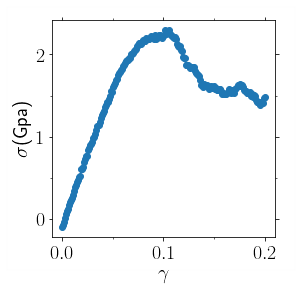

In [11]:
if not ReadStrsFromDump:
    try:
        stress = np.loadtxt('%s/%s'%(path,fileNamee) ) #--- stress input file
        strain = stress[:,0]
        Virial = stress[:,1]
        PltErr(strain,Virial,
               yerr=None,
        #      ylim=[0,5],
               xstr=r'$\gamma$',
               ystr=r'$\sigma$(Gpa)',
               title=fileNamee[:-4]+'.png'
              )
        #
        np.savetxt('loadCurve.txt',np.c_[np.array(strain), Virial],header='gamma\tsigma')
    except:
        ReadStrsFromDump = True
        
if ReadStrsFromDump:
    times = lmpData.coord_atoms_broken.keys()
    try: 

        func_sxy = lambda x: np.sum(lp.Atoms( **lmpData.coord_atoms_broken[x].to_dict(orient='series') ).sxy)/\
                             GetVolume(lmpData,x)
        Virial = np.array(list(map(func_sxy,times)))*1.0e-04
        strainDump = np.array(list(map(lambda x: GetStrain(lmpData,x,0),times)))
        #
        PltErr(strainDump,Virial,
               yerr=None,
        #      ylim=[0,5],
               xstr=r'$\gamma$',
               ystr=r'$\sigma$(Gpa)',
               title=fileNamee[:-4]+'.png'
              )
        #
        np.savetxt('loadCurve.txt',np.c_[strainDump, Virial],header='gamma\tsigma')

    except AttributeError: #--- dump file has no stress entry! 
        ReadStrsFromDump = False



## multiple systems

In [18]:
if not RemoteMachine:
    unrescaled = True
    #
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
#     ax.set_xlabel(r'$\gamma$',fontsize=20)
#     ax.set_ylabel(r'$\sigma$',fontsize=20)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #ax.set_title()
    #
    for GlassType, marker, color, fillstyle in list(zip( [ 
                                         'FeNi',
                                          'CoNiFe',
                                            'CoNiCrFe',
                                            'CoCrFeMn',
                                            'CoNiCrFeMn',
                                            'Co5Cr2Fe40Mn27Ni26'
                                        ],markers, colors, fillstyles )):

        sarr  = np.loadtxt('d2min%s/Run2/loadCurve.txt'%GlassType)
#        gmodu = np.loadtxt('StrsStrn%s/Run2/ShearModulus.txt'%GlassType)[1]
    #    sarr_BandWidth = MultipleFrames2nd(path='StrsDrop%s'%GlassType,nrun=3,title='rc_d2min.txt',ncols=3)
    #    assert sarr_StrsDrop.shape[0] == sarr_BandWidth.shape[0]
        #--- fliter
        nfreq = np.max([1,int(len(sarr)/100)])
        ydata = sarr[0::nfreq,1] #--- first 2nd col is stress drop
        xdata = sarr[0::nfreq,0] #--- 2nd and 3rd cols are widths
#         if unrescaled:
#             gmodu = 1
    #
#        ax.plot(xdata,ydata/gmodu,'-',color=color)#, label = GlassType)
        ax.plot(xdata,ydata,
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                markeredgecolor='black' if not fillstyle else None,
                markevery=int(len(xdata)/10),
                label = '%s'%GlassType)

    #
    ax.legend(frameon=False, fontsize=12)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
    #
    plt.savefig('loadCurve.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

## multiple Realizations

In [19]:
if not RemoteMachine:
    unrescaled = True
    #
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
    ax.set_xlabel(r'$\gamma$',fontsize=20)
    ax.set_ylabel(r'$\sigma$',fontsize=20)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #ax.set_title()
    #
    for GlassType, marker, color, fillstyle in list(zip( [ 
                                         '0','1','2'
                                        ],markers, colors, fillstyles )):

        try:
            gglass=['FeNi','CoNiFe','CoNiCrFe','CoCrFeMn','CoNiCrFeMn','Co5Cr2Fe40Mn27Ni26'][3]
            sarr  = np.loadtxt('d2min%s/Run%s/loadCurve.txt'%(gglass, GlassType) )
            #--- fliter
            nfreq = np.max([1,int(len(sarr)/1000)])
            ydata = sarr[0::nfreq,1] #--- first 2nd col is stress drop
            xdata = sarr[0::nfreq,0] #--- 2nd and 3rd cols are widths
        #
            ax.plot(xdata,ydata,
                    markersize=10,
                    color=color,
                    marker=marker,
                    markerfacecolor=fillstyle,
                    markeredgecolor='black' if not fillstyle else None,
                    markevery=int(len(xdata)/10),
                    label = '%s'%GlassType)
        except:
            continue
    #
    ax.legend(frameon=False, fontsize=12)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
    #
    plt.savefig('loadCurve.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

## find stress peak and corresponding strain
### Fit a spline

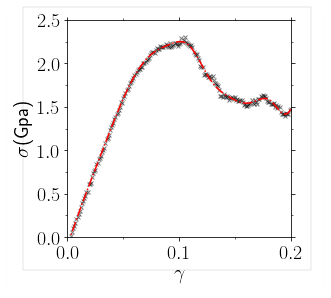

In [12]:
if ReadStrsFromDump:
    strain = strainDump

x, y = np.array(strain), np.array(Virial)
#--- training points
transfrm = ReturnShapeFunc(x,13)
    
#--- train
reg = TrainModel(transfrm,np.c_[y])

#--- prediction
y_pred = reg.predict( transfrm )
    

#--- validate
#mse = Validate(reg, strain,np.c_[y])

#--- yield stress
try:
    (ey,sy), (em,sm,dsm), (ef,sf), gmodu = YieldStress(x,y_pred)
except:
    (ey,sy), (em,sm,dsm), (ef,sf), gmodu = YieldStress2nd(x,y_pred)

#--- write on the disk
np.savetxt('NegativeModulus.txt',np.c_[em,-dsm],header='Strain\tModulus')
np.savetxt('ShearModulus.txt',np.c_[0,gmodu],header='Strain\tModulus')

#--- Plot
attrs={ 'alpha':0.5,
        'fmt':'x',
        'markersize':4,
        'color':'C0',
         'markerfacecolor':'white',
         'markeredgecolor':'black',
         'markevery':int(len(x)/128),
       
      }
ax=None   
kwargs = {
        'borderwidth' : 0.1,
       'xlim':(0,0.2),
       'ylim':(0,2.5),
        'title':'hminIllustration.png',
         }
#
ax = PltErr(x,y, 
       yerr=None, 
       attrs = attrs,
       Plot = False,
       xstr=r'$\gamma$',
       ystr=r'$\sigma$(Gpa)',
      )
#
PltErr(x,y_pred, 
       yerr=None, 
       attrs = {'fmt':'-.r'},
       Plot = False,
       ax = ax,
       **kwargs
      )
if AssignYieldTime:
    PltErr([ey,ey], [ax.axis()[2],sy], 
           yerr=None, 
           attrs = {'fmt':'-.r'},
           Plot = True,
           ax = ax,
           **kwargs
          )    
elif AssignMaxDropTime:
    PltErr(em, sm, 
           yerr=None, 
           attrs = {'fmt':'s','color':'black','markersize':8},
           Plot = True,
           ax = ax,
           **kwargs
          )    
elif AssignFlowTime:
    PltErr([ef,ef], [ax.axis()[2],sf], 
           yerr=None, 
           attrs = {'fmt':'-.r'},
           Plot = True,
           ax = ax,
           **kwargs
          )    


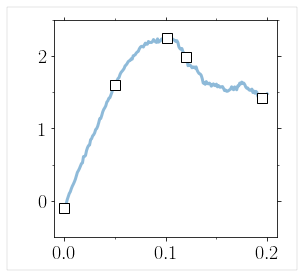

In [63]:
if not RemoteMachine:
    #--- Plot
    attrs={ 'alpha':0.5,
            'fmt':'-',
    #        'markersize':4,
            'color':'C0',
             'markerfacecolor':'white',
             'markeredgecolor':'black',
             'markevery':int(len(x)/128),
             'linewidth':3,

          }
    ax=None   
    kwargs = {
            'DrawFrame':(0.21,0.09,0.15,0.06,0.1),
           'xlim':(-0.01,0.21),
           'ylim':(-0.5,2.5),
            'title':'loadCurve.png',
             }
    #
    ax = PltErr(x,y, 
           yerr=None, 
           attrs = attrs,
           Plot = False,
           xstr='',#r'$\gamma$',
           ystr='',#r'$\sigma$(Gpa)',
          )
    #
    PltErr([0.0,0.05,ey,em,ef], [y[0],y[x>=0.05][0],sy,sm,sf]
           , 
           yerr=None, 
           attrs = {'fmt':'s','color':'black','markersize':10,
                    'markerfacecolor':'white',
                    'markeredgecolor':'black'},
           Plot = True,
           ax = ax,
           **kwargs
          )    

In [10]:
# import statsmodels
# import statsmodels.api as sm
# ols = sm.OLS(np.c_[y], transform)
# ols_result = ols.fit()
# ols_result.summary()

In [329]:
times = lmpData.coord_atoms_broken.keys()
times = np.array(sorted(times))
if AssignYieldTime:
    itime = times[strainDump>=ey][0]
    print('itime(peak)=%s'%itime)    
elif AssignMaxDropTime:
    itime = times[strainDump>=em][0]
    print('itime(max. drop)=%s'%itime)
elif AssignFlowTime:
    itime = times[strainDump>=ef][0]
    print('itime(flow)=%s'%itime)

### test error vs. complexity

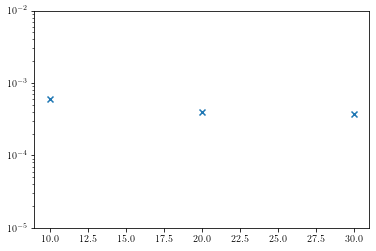

In [22]:
# if AssignYieldTime or AssignMaxDropTime or AssignFlowTime:
#     mse = Validate(reg, strain,np.c_[y])
#     try:
#         keys=mse.keys()
#         plt.scatter(keys, [-mse[key] for key in keys],marker='x')
#         plt.yscale('log')
#     #    plt.xscale('log')
#         plt.ylim(1e-5,1e-2)
#         plt.savefig('cv.png',dpi=75,bbox_inches='tight')
#         plt.show()
#     except:
#         pass

## mismatch parameter 

In [281]:
def GetMismatch(lmpData,itime,AtomicRadius):
    atoms = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='list') )
    df = pd.DataFrame(atoms.__dict__)
    #size = list(map(LatticeConstant.get,list(map(int,df['type'].tolist()))))
    size = list(map(AtomicRadius.get,list(map(int,df['type'].tolist()))))
    assert len(size) == len(df)
    df = pd.DataFrame(np.c_[df,size],columns=list(df.keys())+['size'])

    return df['size'].std()/df['size'].mean()

delta = GetMismatch(lmpData,0,AtomicRadius)
delta_g = GetMismatch(lmpData,0,Gmodu)
       
       
np.savetxt('YieldDelta.txt',np.c_[delta,sy],header='AtomMismatch\tYieldStress')
np.savetxt('ModuMismatch.txt',[delta_g],header='ModuMismatch')



NameError: name 'sy' is not defined

### multiple frames

In [24]:
if not RemoteMachine:
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    Xdata = []
    Ydata = []
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
#     ax.set_xlabel('$\delta$',fontsize=20)
#     ax.set_ylabel('$\sigma_y$(Gpa)',fontsize=20)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #ax.set_title()
    #
    for GlassType, marker, color, fillstyle in list(zip( [ 
                                         'FeNi',
                                          'CoNiFe',
                                           'CoNiCrFe',
                                            'CoCrFeMn',
                                            'CoNiCrFeMn',
                                            'Co5Cr5Fe40Mn27Ni26'
                                        ],markers, colors, fillstyles )):

        sarr  = MultipleFrames2nd(path='YieldStrs%s'%GlassType,nrun=3,title='YieldDelta.txt',ncols=2)
        #--- fliter
        xdata = sarr[:,0]
        ydata = sarr[:,1]
        Xdata += list(xdata[~np.isnan(xdata)])
        Ydata += list(ydata[~np.isnan(ydata)])
        #
        ax.plot(xdata,ydata,'.',
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                markeredgecolor='black' if not fillstyle else None,
                label = '%s'%GlassType)

    #
#    ax.legend(frameon=False, fontsize=16)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
    #
    plt.savefig('YieldDelta.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    np.savetxt('YieldDelta.txt',np.c_[Xdata,Ydata],header='Mismatch\tYieldStrs')
    plt.show()

## Avalanche Size

564991 [-1.02496576]
117648 [-0.02073347]


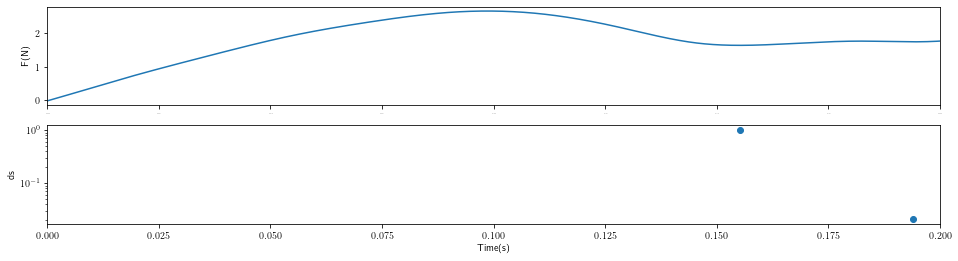

In [25]:
if ReadStrsFromDump:
    strain = strainDump
df = AvalancheSize(strain, y_pred) #
esmax,dsmax=df.sort_values(by='ds',ascending=False).iloc[0][['t_end','ds']]
np.savetxt('StrsDrop.txt',np.c_[esmax,dsmax],header='StressDrop')

# #--- plot
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(211)
ax.set_xlim(strain.min(),strain.max())
ax.tick_params(axis='x',labelsize=0)
ax.set_ylabel('F(N)')
#
ax.plot(strain, y_pred,'-')
#
ax = fig.add_subplot(212)
ax.set_ylabel('ds')
ax.set_xlabel('Time(s)')
ax.set_yscale('log')
ax.set_xlim(strain.min(),strain.max())
#
ax.scatter(df['t_end'],df['ds'])
#
plt.show()

### Correlations with band width

In [26]:
if not RemoteMachine:
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
    # ax.set_xlabel('$w(A^o)$',fontsize=20)
    # ax.set_ylabel('$\Delta\sigma$(Gpa)',fontsize=20)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #
    for GlassType, marker, color, fillstyle in list(zip( [ 
                                         'FeNi',
                                         'CoNiFe',
                                         'CoNiCrFe',
                                         'CoCrFeMn',
                                         'CoNiCrFeMn',
                                         'Co5Cr5Fe40Mn27Ni26'
                                        ],markers, colors, fillstyles)):

        sarr_StrsDrop  = MultipleFrames2nd(path='StrsDrop%s'%GlassType,nrun=3,title='StrsDrop.txt',ncols=2)
        sarr_BandWidth = MultipleFrames2nd(path='StrsDrop%s'%GlassType,nrun=3,title='rc_d2min.txt',ncols=3)
        assert sarr_StrsDrop.shape[0] == sarr_BandWidth.shape[0]
        #--- fliter
        ydata = sarr_StrsDrop[:,1] #--- first 2nd col is stress drop
        xdata = sarr_BandWidth[:,1:3] #--- 2nd and 3rd cols are widths
        indices = np.any(~np.isnan(xdata),axis=1)
        xdata = xdata[~np.isnan(xdata)]
        ydata = ydata[indices]
        assert xdata.shape == ydata.shape
        #
        ax.plot(xdata,ydata,'.',
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                label = '%s'%GlassType)

    #
    #ax.legend(frameon=False, fontsize=16)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
    #
    plt.savefig('StrsDropAndWidth.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

### (negative) modulus and band width

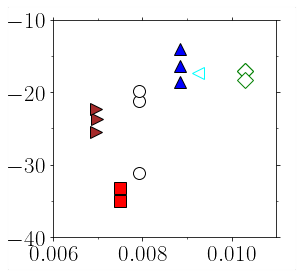

In [69]:
if not RemoteMachine:
    PlotPaperVersionScatter( 2, #--- path:
                            xindx=6, colx = 0, #--- x: delta (1st column)
                            yindx=5, coly = 1, #--- y: hmin( 2nd column)
#                        xlabel=r'$\delta_a$',
#                        ylabel=r'$h_{min}$',
                        title='SoftModuAndDelta2nd.png',
                        xlim=(0.006,0.011),
                        ylim=(-40.0,-10.0),
#                        legend = True,
                        borderwidth = 0.01,
                        fontsize = 23,
                        markersize = 12,
                    )

### correlation coefficient

In [29]:
def zscore(x):
    y = np.copy(x)
    y-=np.mean(y)
    y/=np.std(y)
    return y

if not RemoteMachine:
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_xlim(-2,2)
    ax.set_ylim(-2,2)
    ax.set_xlabel('$w(A^o)$',fontsize=16)
    ax.set_ylabel('$H$(Gpa)',fontsize=16)
    ax.tick_params(labelsize=16)
    x = zscore(Xdata)
    y = zscore(Ydata)
    ax.scatter(x,y,
                   marker='x',s=50,
    #               label=GlassType
              )

    print(np.sum(x*y)/len(x))

# Displacements


In [31]:
if CompDisp:
    #--- extract atom and box properties
    atoms = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='list') )
    #
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime] )
    box.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))

    #--- wrap coordinates
    wrap = lp.Wrap( atoms, box )
    wrap.WrapCoord()
    wrap.Set( atoms ) #--- atoms: set wrapped xyz     

    #--- print actual xyz
    # PrintOvito( pd.DataFrame(atoms.__dict__), 
    #              open( 'xyz_actual.xyz','w'), 
    #              footer = 'ITIME=%s'%itime,
    #              attr_list=['id','type','x','y','z'])

    #--- map to square box
    mapp = lp.Map( atoms, box ) 
    mapp.ChangeBasis()
    mapp.Set( atoms ) #--- atoms: add mapped xyz

    #--- print mapped xyz
    # PrintOvito( pd.DataFrame(atoms.__dict__), 
    #             open( 'xyz_mapped.xyz','w'), 
    #             footer = 'ITIME=%s'%itime,
    #             attr_list=['id','type','xm','ym','zm'] )

    #--- include copies
    copy = lp.Copy( atoms, box )
    copy.FullCopies()
    xatoms = copy.Get()

    #--- print mapped xyz
    # PrintOvito( pd.DataFrame(xatoms.__dict__), 
    #             open( 'xyz_full.xyz','w'), 
    #             footer = 'ITIME=%s'%itime,
    #             attr_list=['id','type','xm','ym','zm'] )

    #--- compute displacements
    #--- need attributes for the reference state
    atoms0 = lp.Atoms( **lmpData.coord_atoms_broken[0].to_dict(orient='list') )
    box0 = lp.Box( BoxBounds = lmpData.BoxBounds[0] )
    box0.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))
    wrap = lp.Wrap( atoms0, box0 )
    wrap.WrapCoord()
    wrap.Set( atoms0 ) #--- atoms: set wrapped xyz    
    mapp = lp.Map( atoms0, box0 ) 
    mapp.ChangeBasis()
    mapp.Set( atoms0 ) #--- atoms: add mapped xyz
    copy = lp.Copy( atoms0, box0 )
    copy.FullCopies()
    xatoms0 = copy.Get()
    #
    cdisp = lp.ComputeDisp( xatoms, box, xatoms0, box0 ) #--- pass full copies!
    cdisp.SetWrapped() 
    uatoms = cdisp.Get(attrs = ['id','type','x','y','z','xm','ym','zm','dx','dy','dz'] ) #--- all atom-wise props
    #
    pd.DataFrame(uatoms.__dict__).head()

In [32]:
# #--- shuffled displacements
if CompDisp and ShuffleDisp:
    xrand = np.c_[uatoms.dx,uatoms.dy,uatoms.dz]
    np.random.shuffle(xrand)
    junk = np.c_[uatoms.id, uatoms.type, uatoms.x, uatoms.xm, uatoms.y, uatoms.ym, uatoms.z,
           uatoms.zm]
    cols = [u'id', u'type', u'x', u'xm', u'y', u'ym', u'z',u'zm']
    #np.c_[junk,xrand]
    uatoms = lp.Atoms(**pd.DataFrame(np.c_[junk,xrand],columns=cols+['dx','dy','dz']).to_dict(orient='list'))

## Print

In [33]:
#--- get a chunk
# cptmp = lp.Copy(atoms0, box0) #--- important: must be reference frame!!
# indices = cptmp.isInsideExpanded( np.c_[xatoms0.xm,xatoms0.ym,xatoms0.zm], 
#                                   epsilon = 0.0, mode = 'isotropic' )


# PrintOvito( pd.DataFrame(uatoms.__dict__)[indices], 
#             open( 'xyz_expanded.xyz','w'), 
#             footer = 'ITIME=%s'%itime,
#             attr_list=['id','type','x','y','z','dx','dy','dz'] )

# Neighbor list

In [54]:
if NeighList:
    try:
        !rm neighList.xyz
    except:
        pass

    cutoff=10.0 #1.1*rpeak #--- 1st peak=2.5
    !ovitos OvitosCna.py $fileName neighList.xyz $nevery 4 $cutoff

InputFile= /Users/Home/Desktop/Tmp/txt/Co5Cr2Fe40Mn27Ni26_glass.dump
num_frames= 201
frame=0
frame=200


In [55]:
#NeighList=True
#nevery=200

In [56]:
if NeighList:
    lmpNeigh = lp.ReadDumpFile( 'neighList.xyz' )
    lmpNeigh.GetCords( ncount = sys.maxsize)

In [57]:
#lmpNeigh.coord_atoms_broken[itime].head()

,id,type,J,Jtype,DIST,DX,DY,DZ,PBC_SHIFT_X,PBC_SHIFT_Y,PBC_SHIFT_Z
0,1,4,33417.0,4.0,4.104592,0.101800,2.14458,3.498299,0.0,0.0,0.0
1,1,4,18243.0,5.0,4.674302,3.453501,-2.70700,-1.610771,0.0,0.0,-1.0
2,1,4,24670.0,2.0,3.793980,2.054399,-2.37420,2.130001,0.0,0.0,0.0
3,1,4,20290.0,4.0,3.994514,1.552799,-3.66720,-0.310802,0.0,0.0,0.0
4,1,4,31777.0,5.0,4.702539,3.910999,2.19585,-1.412868,0.0,0.0,-1.0


#  Pair correlation function

In [34]:
# if PairCorrelationFunction and not Ovitos:
#     d2min = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='list') )
#     thresh=np.log10(thresh[itime])
#     cutoff=20.0/2
#     NMAX=10000*4
#     filtr = np.log10(d2min.d2min)>thresh


#     rdf = lp.ComputeRdf(  atoms, box, 
#                        cutoff = cutoff, NMAX = NMAX)

#     rdf.Distance(WRAP = True, FilterCenter = filtr)
#     rdf.PairCrltn( nbins = 100, bins=np.linspace(2.0,cutoff,100) )
#     bin_edges, hist, err = rdf.Get()

#     #--- plot
#     plt.errorbar(bin_edges,hist,yerr=err,fmt='-o')
    
#     #---
#     np.savetxt('grGood95.txt',np.c_[bin_edges,hist,err],header='r\tg(r)\terr', fmt='%s')
#     plt.show()

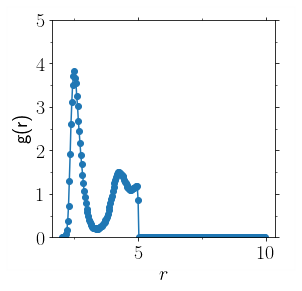

In [249]:
if PairCorrelationFunction:
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ))
    atoms = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='series') )
    neigh = lmpNeigh.coord_atoms_broken[itime]


    rdf = lp.ComputeRdf(  atoms, box )
    rdf.PairCrltn(  
                  bins=np.linspace(2.0,cutoff,250), 
                  rlist=neigh.DIST )
    bin_edges, hist, err = rdf.Get()

    #--- print
    np.savetxt('gr.txt',np.c_[bin_edges, hist, err],header='r\tg(r)\terr')
    #--- plot
    #plt.errorbar(bin_edges,hist,yerr=err,fmt='-o')

    PltErr(bin_edges,hist,err,
          ylim=[0,5],
           ystr='g(r)',
           title='gr.png'
          )

## 1st peak evolution

In [66]:
def GetFirstPeak(lmpData,lmpNeigh,itime):
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ))
    atoms = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='series') )
    neigh = lmpNeigh.coord_atoms_broken[itime]
    #
    rdf = lp.ComputeRdf(  atoms, box )
    rdf.PairCrltn( nbins = 250, 
                  bins=np.linspace(2.0,cutoff,250), 
                  rlist=neigh.DIST )
    bin_edges, hist, err = rdf.Get()
    return hist.max()
    
if PairCorrelationFunction:
    #--- 
    times = list(lmpNeigh.coord_atoms_broken.keys())
    times.sort()
    #---
    
    #
    ydata = np.array(list(map(lambda x:GetFirstPeak(lmpData,lmpNeigh,x),times)))
    xdata = np.array(list(map(lambda x:GetStrain(lmpData, x, 0 ),times)))
    #--- savetxt
    np.savetxt('gr_peak_gamma.txt',np.c_[xdata,ydata],header='gamma\td2min')


### multiple frames

error while reading /Users/Home/Desktop/Tmp/txt/git/CrystalPlasticity/postprocess/PairCrltnT300/CoNiFe/Run0/gr_peak_gamma.txt


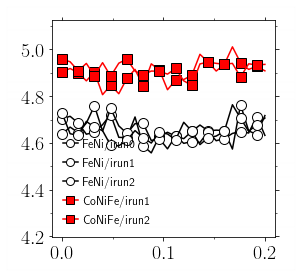

In [228]:
if not RemoteMachine:
    PlotPaperVersion(0,7,
#                        xlabel=r'$\gamma$',
#                        ylabel=r'Percentage',
                        title='gr_peak_gamma.png',
#                        ylim=(0,15),
                        xlim=(-0.01,.21),
                        PlotMean = False,
                        legend = True,
#                        yscale='log',
                        borderwidth = 0.01,
                    )

## Multiple Systems

modify path!
modify path!
modify path!
modify path!
modify path!
modify path!


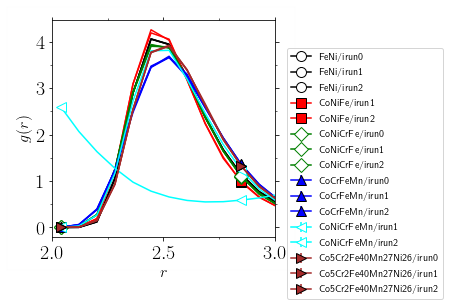

In [80]:
if not RemoteMachine:    
    
    PlotPaperVersion(0,0,
                        xlabel=r'$r$',
                        ylabel=r'$g(r)$',
                        title='gr_itime0_inset.png',
                        xlim=(2,3),#(0,10),
                    )

## ovito output

In [35]:
# try:
#     sfile = open('../testRuns/glassFeNi/Run0/FeNi_gr.xyz') #--- run testRuns2nd.py
#     gr={}
#     while True:
#         sfile.readline()
#         iitime=int(sfile.readline().split()[0])
# #        print(iitime)
#         sfile.readline()
#         nrow=int(sfile.readline().split()[0])
#         sfile.readline()
#         gr[iitime] = np.array([list(map(float,sfile.readline().split())) for i in range(nrow)])
# except:
# #    traceback.print_exc()
#     pass


## Plot

In [36]:
if not RemoteMachine:
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    nfreq = 1
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
    #
    ax.set_xlim(2,3)
    
#    ax.set_yscale('log')
    #
#    ax.set_xlabel(r'$\gamma$',fontsize=20)
#    ax.set_ylabel(r'$\sigma/\mu$',fontsize=20)
    #
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    #
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #ax.set_title()
    #
    for strain, marker, color, fillstyle, indx in list(zip( [ 
#                                        'Other',
                                        '0.0','0.2'
                                        ],markers, colors, fillstyles, range(10) )):
        #--- time step
        iitime = int(float(strain)*2000000/0.2)
        print(iitime)
        #--- fliter
        data  = gr[iitime]
        ydata = data[0::nfreq,1] #--- first 2nd col is stress drop
        xdata = data[0::nfreq,0] #--- 2nd and 3rd cols are widths
    #
        ax.plot(xdata,ydata,'-',color=color)#, label = GlassType)
        ax.plot(xdata[-1],ydata[-1],
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                label = '%s'%strain)

    #
    ax.legend(frameon=False, fontsize=12)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
    #
    plt.savefig('CrysFrac.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

## plot gr good vs bad

In [37]:
if not RemoteMachine:
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    nfreq = 1
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
    #
    ax.set_ylim(1e-2,1e1)
    ax.set_xlim(0,10)

    ax.set_yscale('log')
    #
    PutMinorTicks(ax, LOGY=True)

    #
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #ax.set_title()
    #
    ydata = {}
    xdata = {}
    for GlassType, marker, color, fillstyle, indx in list(zip( [ 
#                                        'Out','In','Diff'
#                                        '5','95','QuantDiff'
                                         ('Good','Co5Cr2Fe40Mn27Ni26'),('Bad','CoNiCrFe'),('Diff','Difference')
                                        ],markers, colors, fillstyles, range(10) )):
        #--- time step
        sarr  = np.loadtxt('/Users/Home/Desktop/Tmp/txt/git/CrystalPlasticity/postprocess/gr%s95.txt'%GlassType[0])
        #--- fliter
        ydata[ indx ] = sarr[:,1] #--- first 2nd col is stress drop
        xdata[ indx ] = sarr[:,0] #--- 2nd and 3rd cols are widths
    #
        ax.plot(xdata[ indx ],ydata[ indx ],
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                markeredgecolor='black' if not fillstyle else None,
                markevery=int(len(xdata[ indx ])/5),
                label = '%s'%GlassType[1])
    #
    ax.legend(frameon=False, fontsize=12,loc=1)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04,LOG_Y=True)
    #
    plt.savefig('grD2min.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

In [220]:
#np.savetxt('/Users/Home/Desktop/Tmp/txt/git/CrystalPlasticity/postprocess/grDiff95.txt',np.c_[xdata[0],ydata[1]-ydata[0]])

# D2min

## partition the space, make fits, and compute squared errors 

In [239]:
#fileName='/Users/Home/Desktop/Tmp/txt/Co5Cr2Fe40Mn27Ni26_glass.dump'
#fileName='/Users/Home/Desktop/Tmp/txt/CoNiCrFe_glass.dump'
#nevery=1
#itime=2000000 #1600000 #1300000 #1000000 #700000
#itime=700000
#DminAnalysis=True

In [240]:
if DminAnalysis and not Ovitos:
    #--- Create "Atoms" object with dx,x attributes and
    #--- atoms within the original box
    cptmp = lp.Copy(atoms0, box0) #--- important: must be reference frame!!
    indices = cptmp.isInsideExpanded( np.c_[xatoms0.xm,xatoms0.ym,xatoms0.zm], 
                                      epsilon = 0.0, mode = 'isotropic' )
    #--- filter the full copy
    atomd = lp.Atoms(**pd.DataFrame(uatoms.__dict__)[indices].to_dict(orient='list'))
    #
    d2min = lp.ComputeD2min(atomd, box0, dlgr)
    d2min.Partition()
    d2min.D2min()
#    pdb.set_trace()
    d2min = d2min.Get(attrs=['id','type','x','y','z','xm','ym','zm','d2min'])
    #
    pd.DataFrame(d2min.__dict__).head()


## Run Ovitos

In [241]:
#--- input: dump file output: d2min.xyz
if DminAnalysis and Ovitos:
    assert nevery < len(lmpData.coord_atoms_broken.keys()), 'decrease it!'
    try:
        os.system('rm d2min.xyz')
    except:
        pass
    !ovitos OvitosCna.py $fileName d2min.xyz $nevery 2 $fileName


InputFile= /Users/Home/Desktop/Tmp/txt/glassCo5Cr2Fe40Mn27Ni26/Run0//Co5Cr2Fe40Mn27Ni26_glass.dump
num_frames= 201
frame=0
frame=1
frame=2
frame=3
frame=4
frame=5
frame=6
frame=7
frame=8
frame=9
frame=10
frame=11
frame=12
frame=13
frame=14
frame=15
frame=16
frame=17
frame=18
frame=19
frame=20
frame=21
frame=22
frame=23
frame=24
frame=25
frame=26
frame=27
frame=28
frame=29
frame=30
frame=31
frame=32
frame=33
frame=34
frame=35
frame=36
frame=37
frame=38
frame=39
frame=40
frame=41
frame=42
frame=43
frame=44
frame=45
frame=46
frame=47
frame=48
frame=49
frame=50
frame=51
frame=52
frame=53
frame=54
frame=55
frame=56
frame=57
frame=58
frame=59
frame=60
frame=61
frame=62
frame=63
frame=64
frame=65
frame=66
frame=67
frame=68
frame=69
frame=70
frame=71
frame=72
frame=73
frame=74
frame=75
frame=76
frame=77
frame=78
frame=79
frame=80
frame=81
frame=82
frame=83
frame=84
frame=85
frame=86
frame=87
frame=88
frame=89
frame=90
frame=91
frame=92
frame=93
frame=94
frame=95
frame=96
frame=97
frame=98
fram

In [242]:
#--- read from d2min.xyz
if DminAnalysis and Ovitos:
    lmpDmin = lp.ReadDumpFile( 'd2min.xyz' )
    lmpDmin.GetCords( ncount = sys.maxsize, columns = {'NonaffineSquaredDisplacement':'d2min'} )

In [193]:
#lmpDmin.coord_atoms_broken.keys()

dict_keys([0, 2000000])

## PDF

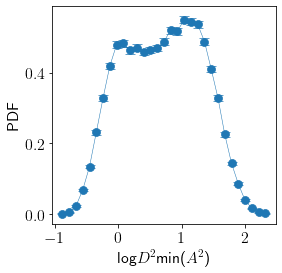

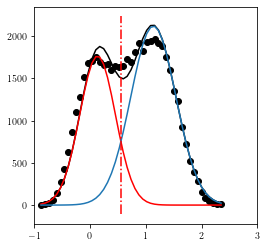

mu_divide= 0.5551259962173067


In [95]:
def PdfD2min( d2min, 
             #times,     
             Plott = True,
             **kwargs
             ):
    #--- plot
    if Plott:
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111)
        #    ax.set_yscale('log')
        #ax.set_xscale('log')
        # ax.set_ylim(1e-5,10)
        # ax.set_xlim(1e-2,1e4)
        ax.set_xlabel(r'log$D^2$min($A^2$)',fontsize=16)
        ax.set_ylabel(r'PDF',fontsize=16)
        ax.tick_params(labelsize=16)
        #ax.set_title(r'itime=%s'%itime)

#     Mean = []
#     Std = []
#     Ebulk = []
#     D2min = {}
    if 1:
#    for itimee in sorted(times): #[0::nn]:

        # strain
#        ebulk = GetStrain(lmpData, [itimee], 0 )[itimee]
#         if ebulk == 0.0:
#             continue
#        Ebulk += [ebulk]    

        #--- d2min
#        d2min = lp.Atoms( **lmpData.coord_atoms_broken[itimee].to_dict(orient='list') )
#        D2min[ itimee ] = np.array(d2min.d2min)
#        Std += [ np.std(d2min.d2min) ]
#        Mean += [ np.mean(d2min.d2min) ]

    #--- size distribution
        if Plott:
            value = np.log10(d2min.d2min)
            #--- filter based on the given limit
#             if 'Limit' in kwargs:
#                 (xlo,xhi)=kwargs['Limit']
#                 filtr = np.all([value>=xlo,value<xhi],axis=0)
#                 value = value[filtr]
#                bins=np.linspace(xlo,xhi,)
            #--- histogram
            hist, edges2, error = GetPDF( value, linscale = True, n_per_decade=32)

        #
            ax.errorbar(edges2,hist,error,fmt='-o',
                        markersize=8,markeredgewidth=0.7,
                            linewidth=.5,
                             barsabove=None,capsize=5,capthick=1,elinewidth=1) #,label='%3.2f'%ebulk)
    #
    if Plott:
#        ax.legend(frameon=False, fontsize=12)
        plt.savefig('pdfD2min.png',dpi=75,bbox_inches='tight')
        plt.show()
        
 #   return Ebulk, Mean, Std, D2min

def FilterDataFrame(df,column,limits):
    (xlo,xhi) = limits
    filtr = np.all([df[column]>=xlo,df[column]<xhi],axis=0)
    return df[filtr]



if DminAnalysis and Ovitos:
    d2min = lp.Atoms( **lmpDmin.coord_atoms_broken[itime].to_dict(orient='series') )

    #--- filter
#     d2min = lp.Atoms( **FilterDataFrame(pd.DataFrame(d2min.__dict__),
#                     column='d2min',
#                     limits =(1.0e-3,np.max(d2min.d2min))).to_dict(orient='series'))
                   
    PdfD2min( d2min, 
              #times = [0,2000000],
#              times=[itime],#list(lmpDmin.coord_atoms_broken.keys()),     
              Plott = True,
             Limit=(-3,np.max(np.log10(d2min.d2min)))
             )
    
    thresh, ratio, junk = gaussian_mixture(
                                     d2min.d2min,
#                                     times = list(d2min.keys()), 
                                     PLOT = True,
                                 )
    mu_divide = np.log10(thresh)
    print('mu_divide=',mu_divide)
        #--- save
#     strn = GetStrain(lmpDmin, 
#                      times = [itime], #list(lmpDmin.coord_atoms_broken.keys()), 
#                      time0 = 0 )
#     np.savetxt('varD2minGamma.txt',
#                np.c_[valuesDict(strn,strn.keys()), valuesDict(ratio,ratio.keys())], 
#                header='gamma\tratio')


### mean & variance 

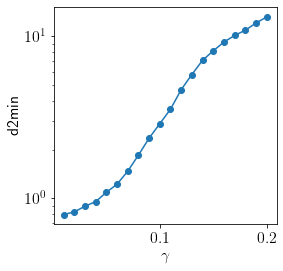

In [148]:
if DminAnalysis and Ovitos:
    #--- lambda function
    GetMeanD2min = lambda x: lp.Atoms( **lmpDmin.coord_atoms_broken[x].to_dict(orient='series') ).d2min.mean()
    
    #--- 
    times = list(lmpDmin.coord_atoms_broken.keys())
    times.sort()
    times.pop(0)
    #
    ydata = np.array(list(map(GetMeanD2min,times)))
    xdata = np.array(list(map(lambda x:GetStrain(lmpData, x, 0 ),times)))
    #--- savetxt
    np.savetxt('d2min_gamma.txt',np.c_[xdata,ydata],header='gamma\td2min')
    #--- plot
    PltErr(xdata,
           ydata,#/xdata**2,
           0*ydata,
#      ylim=[0,5],
       ystr='d2min',
       xstr='$\gamma$',
       yscale='log',
#       xscale='log',
       title='dmin_gamma.png'
      )

#### multiple realizations

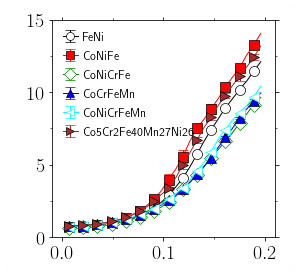

In [32]:
if not RemoteMachine:
    PlotPaperVersion(2,2,
#                        xlabel=r'$\gamma$',
#                        ylabel=r'Percentage',
                        title='dmin_gamma.png',
                        ylim=(0,15),
                        xlim=(-0.01,.21),
                        PlotMean = True,
                        legend = True,
#                        yscale='log',
                        borderwidth = 0.01,
                    )

### multiple systems

In [46]:
if not RemoteMachine:
    #
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    nfreq = 1
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
#     ax.set_xlabel(r'$\gamma$',fontsize=20)
#     ax.set_ylabel(r'Norm. Std',fontsize=20)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #ax.set_title()
    #
    for GlassType, marker, color, fillstyle in list(zip( [ 
#                                          'FeNi', #0,1,2
#                                           'CoNiFe', #0,2
                                             'CoNiCrFe/Run2', #0,1,2  ## bad 7
#                                             'CoCrFeMn', #0,1,2
#                                             'CoNiCrFeMn', #1,2 ##
                                            'Co5Cr5Fe40Mn27Ni26/Run0'# 0,1,2 # good 13
                                        ],markers, colors, fillstyles )):

        sarr  = np.loadtxt('d2min%s/D2minGamma.txt'%GlassType)
        #--- fliter
        ydata = sarr[:,1] #--- first 2nd col is stress drop
        xdata = sarr[:,0] #--- 2nd and 3rd cols are widths
    #
        ax.plot(xdata,ydata,
                linestyle='-',
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                markeredgecolor='black' if not fillstyle else None,
                markevery=6*4,
                label = '%s'%GlassType[0:-5])
    #
    ax.legend(frameon=False, fontsize=12)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
    #
    plt.savefig('D2minGamma.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

## Interpolation

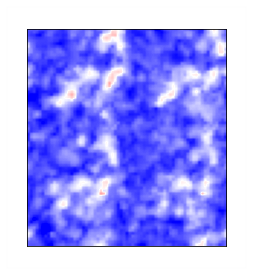

In [343]:
if DminAnalysis:
    box0 = lp.Box( BoxBounds = lmpData.BoxBounds[itime],AddMissing = np.array([0.0,0.0,0.0] ))
    atom = lp.Atoms( **lmpDmin.coord_atoms_broken[itime].to_dict(orient='series') )
    #---
    PlotAttrs = {
                'zscore' : False,
                'scale' : 'log',
                'xlabel' : '', #r'$x$(\r{A})', 
                'ylabel' : '', #r'$y$(\r{A})',
                'DrawFrame':(0.1,0.1,0.1,0.1,0.01),
                'colorbar':False,
                'labels' : False,
                'vmin':-0.5,
                'vmax':+2.1,
                }
    junk, junk, d2intrp = Intrp(atom, box0,
                    attr = 'd2min',
                    Plot = True,
                    title='map_d2min.png',
                    **PlotAttrs
                    )

### time evolution

itime=700000,gamma=0.07


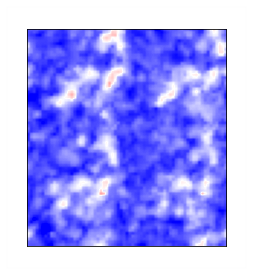

itime=1000000,gamma=0.10


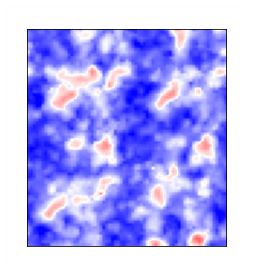

itime=1300000,gamma=0.13


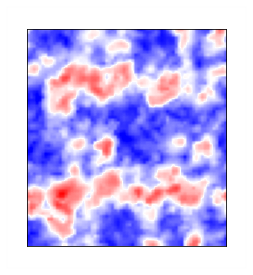

itime=1600000,gamma=0.16


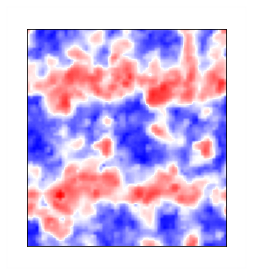

In [344]:
if not RemoteMachine:
    times = list(lmpDmin.coord_atoms_broken.keys())
    times.sort()
    for itime in [700000,1000000,1300000,1600000]: #times[0::10]:
        if itime == 0:
            continue
        box0 = lp.Box( BoxBounds = lmpData.BoxBounds[itime],AddMissing = np.array([0.0,0.0,0.0] ))
        print('itime=%s,gamma=%3.2f'%(itime,GetStrain(lmpData, itime, 0 )))
        atom = lp.Atoms( **lmpDmin.coord_atoms_broken[itime].to_dict(orient='series') )
        #---
        junk, junk, d2intrp = Intrp(atom, box0,
                        attr = 'd2min',
                        Plot = True,
                        title='DminAnalysis/map_d2min.CoNiCrFe.%s.png'%itime,
                        **PlotAttrs                   
                                   )

### Print Ovito output

In [22]:
if not RemoteMachine:
    #--- print 
    file_name = 'd2min.xyz'
    try:
        os.system('rm %s'%file_name)
    except:
        pass



    # PrintOvito( pd.DataFrame(d2intrp.__dict__), 
    #             open(file_name,'a'), 
    #             footer = 'ITIME=%s'%itime,
    # #                attr_list=['id','type','xm','ym','zm','d2min'],
    #             attr_list=['x','y','z','d2min'] 
    #           )
    times = list(lmpDmin.coord_atoms_broken.keys())
    times.sort()

    for itimee in times: #=2000000
        box0 = lp.Box( BoxBounds = lmpData.BoxBounds[itimee],AddMissing = np.array([0.0,0.0,0.0] ))
        print('itime=%s,gamma=%2.1e'%(itimee,GetStrain(lmpData, itimee, 0 )))
        d2min = lp.Atoms( **lmpDmin.coord_atoms_broken[itimee].to_dict(orient='series') )

                #--- map to square box
        mapp = lp.Map( d2min, box0 ) 
        mapp.ChangeBasis()
        mapp.Set( d2min ) #--- atoms: add mapped xyz

        PrintOvito( pd.DataFrame(d2min.__dict__), 
                    open(file_name,'a'), 
                    footer = 'ITIME=%s'%itimee,
        #                attr_list=['id','type','xm','ym','zm','d2min'],
                    attr_list=['id','type','xm','ym','zm','d2min'] 
                  )

        # #--- current frame
        # d2minList=pd.DataFrame(d2min.__dict__).sort_values(by='id', ascending=True, inplace=False)['d2min']
        # df = pd.DataFrame(atoms.__dict__).sort_values(by='id', ascending=True, inplace=False)
        # #attrs = 
        # d2min2 = lp.Compute( atoms, box )
        # d2min2.Set(np.c_[df,d2minList],attrs=list(df.keys()) + ['d2min'])
        # attrs = ['id','type','x','y','z','d2min']
        # d2min2 = pd.DataFrame(np.c_[list(map(d2min2.__dict__.get,attrs))].T, columns = attrs )
        # PrintOvito( d2min2, 
        #             open(file_name,'a'), 
        #             footer = 'ITIME=%s'%itime,
        #             attr_list=['id','type','x','y','z','d2min'] )

    # if DminAnalysis:# and not Ovitos:
    #     PlotOvito( d2intrp,
    #               itime
    #              )

itime=0,gamma=0.00
itime=10000,gamma=0.00
itime=20000,gamma=0.00
itime=30000,gamma=0.00
itime=40000,gamma=0.00
itime=50000,gamma=0.01
itime=60000,gamma=0.01
itime=70000,gamma=0.01
itime=80000,gamma=0.01
itime=90000,gamma=0.01
itime=100000,gamma=0.01
itime=110000,gamma=0.01
itime=120000,gamma=0.01
itime=130000,gamma=0.01
itime=140000,gamma=0.01
itime=150000,gamma=0.02
itime=160000,gamma=0.02
itime=170000,gamma=0.02
itime=180000,gamma=0.02
itime=190000,gamma=0.02
itime=200000,gamma=0.02
itime=210000,gamma=0.02
itime=220000,gamma=0.02
itime=230000,gamma=0.02
itime=240000,gamma=0.02
itime=250000,gamma=0.02
itime=260000,gamma=0.03
itime=270000,gamma=0.03
itime=280000,gamma=0.03
itime=290000,gamma=0.03
itime=300000,gamma=0.03
itime=310000,gamma=0.03
itime=320000,gamma=0.03
itime=330000,gamma=0.03
itime=340000,gamma=0.03
itime=350000,gamma=0.03
itime=360000,gamma=0.04
itime=370000,gamma=0.04
itime=380000,gamma=0.04
itime=390000,gamma=0.04
itime=400000,gamma=0.04
itime=410000,gamma=0.04
itime=

## Crltn Function (Unstructured points)

In [217]:
if DminAnalysis and CrltnFunctionUnstructured and not Ovitos:
    crltn = lp.ComputeCrltn(  d2min, box, 
                              d2min.d2min, #--- values
                              cutoff = cutoff, #--- cutoff size to include neighbors
                              dx = dlgr0, #--- discretization length: 1st peak in rdf
                              NMAX = NMAX, #--- upper bounds for the number of atoms
                            )
    crltn.Distance()
    crltn.AutoCrltn(RADIAL = None)
    xvv, yvv, zvv, hist, err = crltn.Get()

    #--- save data
    np.save('CrltnFuncUnstructured',np.c_[xvv, yvv, zvv, hist, err])

In [218]:
# n=1000*4
# xyz = np.random.random((n,3)) 
# atom_tmp = lp.Atoms(**pd.DataFrame(np.c_[np.arange(n),np.ones(n),xyz],
#                                    columns=['id','type','x','y','z']).to_dict(orient='list'))
# box_tmp = lp.Box(CellOrigin=np.array([0,0,0]),CellVector=np.array([[1,0,0],[0,1,0],[0,0,1]]))
# #val = np.sin(2*np.pi*xyz[:,0])
# rstar = 0.25
# xyz = xyz - np.array([0.5,0.5,0.5])
# val = np.exp(-0.5*(xyz[:,0]**2+xyz[:,1]**2+xyz[:,2]**2)/rstar/rstar)
# crltn = lp.ComputeCrltn(    atom_tmp, box_tmp,
#                              val,
#                              cutoff=1.0*3**.5, dx=0.05,
#                              NMAX = n
#                      )
# crltn.Distance()
# crltn.AutoCrltn(RADIAL = None)
# xvv, yvv, zvv, hist, err = crltn.Get()

# dlgr0 = 0.05/2

### Plot Crltns

In [203]:
#--- load data
# sdata = np.load('CrltnFuncUnstructured.npy')
# nz = sdata.shape[2]/5
# xv = sdata[:,:,0:nz]
# yv = sdata[:,:,nz:2*nz]
# zv = sdata[:,:,2*nz:3*nz]
# hist = sdata[:,:,3*nz:4*nz]
# err = sdata[:,:,4*nz:5*nz]

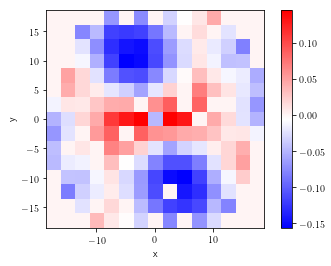

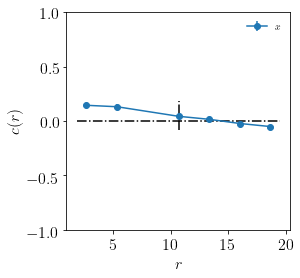

10.699313962120927

In [219]:
if DminAnalysis and CrltnFunctionUnstructured and not Ovitos:
    #--- get 2d slice
    xv2d, yv2d, hist2d, err2d = GetSlice2d( hist, err,
                                           xvv, yvv, zvv,
                                           z=0.0, xtol = dlgr0/2
                                          )
    #--- bitmap
    PltBitmap(hist2d, 
              xlabel = 'x', ylabel = 'y',
              xlim=(xv2d.min(),xv2d.max()),ylim=(yv2d.min(),yv2d.max()),
              zscore = None,
              frac = 1.0, #--- plot a patch
              ) 

    #--- get 1d slice
    xv1d, hist1d, err1d =   GetSlice1d( hist2d, err2d,
                                 xv2d, yv2d,
                                 xtol = dlgr0/2,
                                 y=0.0)   
    #--- plot
    PltCrltnFunc1d( hist1d[xv1d>0.0], err1d[xv1d>0.0],
                     xv1d[xv1d>0.0],
                     fileName = 'cr.%s.png'%itime,
    #                 title = r'$\epsilon=%3.2f$'%(2*ebulk),
                     cTOL = 8.0e-2,
                     dpi = 60,
                    )

## Crltn Function (FFT)

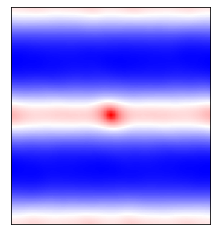

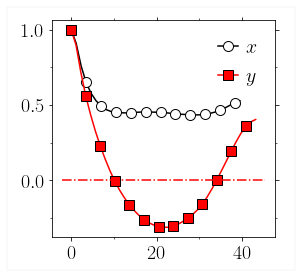

In [43]:
def CrltnFunctionFFT( atom, box, box0, attr, Plot = True):
    
        (xlin,ylin,zlin), (xv, yv, zv), d2intrp = Intrp( atom, box,
                                                         attr, 
                                                         Plot = None 
                                                       )

        (nx,ny,nz) = len(xlin), len(ylin),len(zlin) 
        #
        value = np.c_[d2intrp.d2min].reshape((ny,nx,nz))

        #--- shuffle
        #     ( nx, ny, nz ) =  value.shape
        #     slist = value.flatten()
        #     np.random.shuffle(slist)
        #     value=slist.reshape((nx, ny, nz))    
        #
        #--- filter value
        #     value = FilterMatrix( CellVector[0], CellOrigin[0],
        #                   (xlin, ylin, zlin),
        #                   (xv, yv, zv ),
        #                    value )

        crltn = GetAutoCorrelation( value )

#        box = lp.Box( BoxBounds = lmpData.BoxBounds[itime] )
#        box.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))

        CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector ) #--- box length
        #    

        #--- xy plane
        val = crltn[:,:,0].copy()
        if Plot:
            PltCrltn( val, 
                      xlabel = 'x', ylabel = 'y',
                      xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
                      frac = 1, #--- plot a patch
                      zscore = False,
                      fileName = 'cxy_d2minBad.png',
                      dpi = 60
                    )

        #--- bulk strain
        dx=box.CellVector[0,1]-box0.CellVector[0,1]
        l1=box.CellVector[1,1]
        ebulk = dx/l1
        #---
        (xc, yc), (xdata0,ydata0), (xdata,ydata) =\
                PltCrltnFunc(   crltn, 
                                 xv,yv,
                                 fileName = 'cr_d2minBad.png',
                                 title = '', #r'$\gamma=%3.2f$'%(ebulk),
                                 cTOL = 1.0e-2,
                                 dpi = 150,
                                 PLOT = Plot,
                                )
        
        #--- save
        return  (ebulk, xc, yc)
    
if DminAnalysis:
    box0  = lp.Box( BoxBounds = lmpData.BoxBounds[0],AddMissing = np.array([0.0,0.0,0.0] ))
    box  = lp.Box( BoxBounds = lmpData.BoxBounds[itime],AddMissing = np.array([0.0,0.0,0.0] ))
    atom = lp.Atoms( **lmpDmin.coord_atoms_broken[itime].to_dict(orient='series') )
    #---
    ebulk, xc, yc = CrltnFunctionFFT(atom, box, box0,'d2min', 
                    Plot = True,
                    )

#    np.savetxt('rc_d2min.txt',np.c_[ebulk, xc, yc],header='gamma\txc\tyc')


### Multiple Frames

In [44]:
if DminAnalysis:
    times = list(lmpDmin.coord_atoms_broken.keys())
    times.sort()
    box0  = lp.Box( BoxBounds = lmpData.BoxBounds[0],AddMissing = np.array([0.0,0.0,0.0] ))
    box  = lambda x:lp.Box( BoxBounds = lmpData.BoxBounds[x],AddMissing = np.array([0.0,0.0,0.0] ))
    atom = lambda x:lp.Atoms( **lmpDmin.coord_atoms_broken[x].to_dict(orient='series') )

    exy=list(map(lambda x:CrltnFunctionFFT(atom(x), box(x), box0,'d2min', Plot=False), times))
    np.savetxt('rc_d2min.txt',np.c_[exy],header='gamma\txc\tyc')


modify path!
modify path!
modify path!
modify path!
modify path!
modify path!


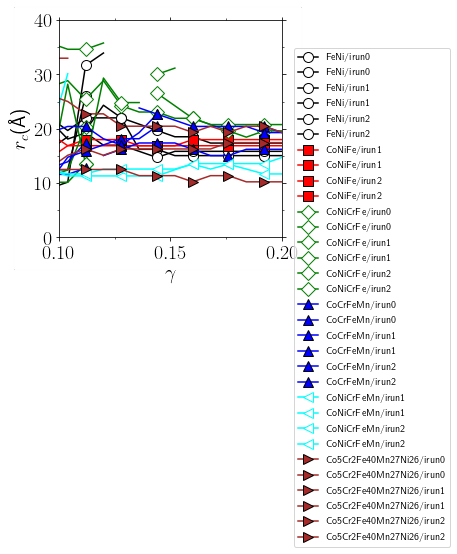

In [68]:
if not RemoteMachine:
    PlotPaperVersion(
                        xlabel=r'$\gamma$',
                        ylabel=r'$r_c$(\r{A})',
                        title='rc_gamma.png',
                        ylim=(0,40),
                        xlim=(0.1,.2),
                        PlotMean = False,
                        legend = True,
#                        yscale='log',
                        borderwidth = 0.01,
                    )

#### Plot

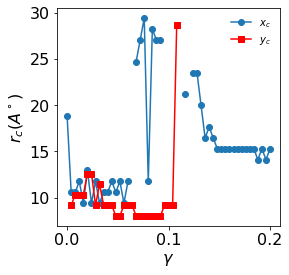

In [74]:
if not RemoteMachine:
    sarr = MultipleFrames('widthFeNi','rc_d2min.txt',irun=0)
#--- plot
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
    xstr = r'$\gamma$'
    ystr = r'$r_c(A^\circ)$'
    ax.set_xlabel(xstr,fontsize=16)
    ax.set_ylabel(ystr,fontsize=16)
    ax.tick_params(labelsize=16)
    #
    ax.plot( sarr[:,0], sarr[:,1],'-o', color='C0', label = r'$x_c$')
    ax.plot( sarr[:,0], sarr[:,2],'-s', color='red', label = r'$y_c$')
    ax.legend(frameon=False)
    plt.savefig('rc.png',dpi=75,bbox_inches='tight')
    plt.show()


### Band width vs. mismatch

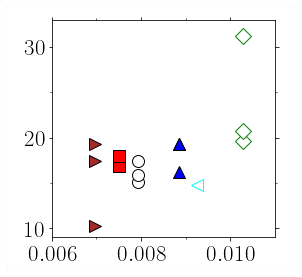

In [493]:
if not RemoteMachine:
    ax=PlotPaperVersionScatter( 2, #--- path:
                            xindx=6, colx = 0, #--- x: delta (1st column)
                            yindx=3, coly = 1, #--- y: hmin( 2nd column)
#                        xlabel=r'$\delta_a$',
#                        ylabel=r'$w_{sb}$',
                        title='WidthAndDelta2nd.png',
                        xlim=(0.006,0.011),
                        ylim=(9.0,33.0),
#                         legend = True,
                        borderwidth = 0.01,
                        fontsize = 23,
                        markersize = 12,
                    )

# Voronoi Analysis

In [89]:
# nevery=200
# itime=2000000
# VorAnl=True

In [90]:
if VorAnl and Ovitos:
    try:
        !rm Voronoi.xyz
    except:
        pass
    rad1=0.0#AtomicRadius[1]
    rad2=0.0#AtomicRadius[2]
    rad3=0.0#AtomicRadius[3]
    rad4=0.0#AtomicRadius[4]
    rad5=0.0#AtomicRadius[5]
    !ovitos OvitosCna.py $fileName Voronoi.xyz $nevery 3 $rad1 $rad2 $rad3 $rad4 $rad5  

InputFile= /Users/Home/Desktop/Tmp/txt/glassCo5Cr2Fe40Mn27Ni26/Run0//Co5Cr2Fe40Mn27Ni26_glass.dump
num_frames= 201
frame=0
frame=200


In [91]:
#--- read from d2min.xyz
if VorAnl and Ovitos:
    lmpVor = lp.ReadDumpFile( 'Voronoi.xyz' )
    lmpVor.GetCords( ncount = sys.maxsize)

## histogram

(0, 0, 12, 0)	5315	(10.5 %)
(0, 1, 10, 2)	4566	(9.0 %)
(0, 2, 8, 4)	2500	(4.9 %)
(0, 1, 10, 3)	2053	(4.1 %)
(0, 3, 6, 4)	2051	(4.0 %)
(0, 0, 12, 2)	2018	(4.0 %)
(0, 2, 8, 2)	1847	(3.6 %)
(0, 1, 10, 4)	1704	(3.4 %)
(0, 0, 12, 3)	1112	(2.2 %)
(0, 2, 8, 5)	1076	(2.1 %)


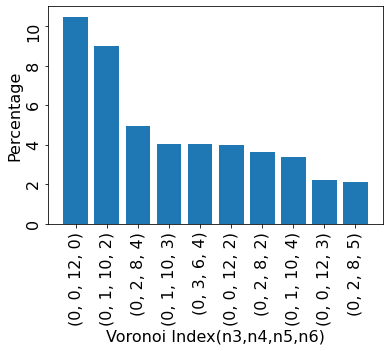

In [20]:
if VorAnl and Ovitos:
     GetMotifs( lmpVor, 
                times = [itime], #[2000000], #lmpData.coord_atoms_broken.keys(),
                Plot = True
              )

## Timeseries

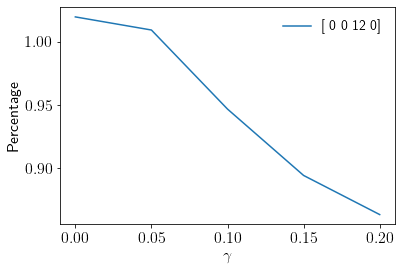

In [19]:
def GetMotifsTimeseries( lmpData, 
                         Motif = np.array([[0,0,12,0]]),
                       ):
    times = list(lmpData.coord_atoms_broken.keys())
    times.sort()
    Unique_indices, Counts = GetMotifs( lmpData, 
                                         times = times,
                                         Plot = False,
                                       )
    vol = GetVolume(lmpData,0)
    natom = len(lmpData.coord_atoms_broken[0].x)
    #
    strn =  list(map(lambda x:GetStrain(lmpData,x,time0=0), times))

    #
    #
    percent = {}
    for motif,indx in zip(Motif,range(len(Motif))):
        percent[indx] = {}
        for itime in times:
            counts = Counts[itime]
            unique_indices = Unique_indices[itime]
            percent[indx][itime] = counts[np.all(unique_indices== motif,axis=1)] * natom / vol
    #--- plot
#     plt.yscale('log')
#     plt.ylim(.1,100)
    plt.xlabel('$\gamma$',fontsize=16)
    plt.ylabel('Percentage',fontsize=16)
    plt.tick_params(labelsize=16)
    #
    for indx in range(len(Motif)):
        plt.plot(strn,list(map(percent[indx].get,times)),
                 '-',
                 label = Motif[indx]
                )
    #
    plt.legend(frameon=False,fontsize=14)
    plt.savefig('motifsTimeSeries.png',dpi=75,bbox_inches='tight')
    plt.show()
    #
    np.savetxt('icoPercentageWithStrain.txt',
               np.c_[strn,list(map(percent[indx].get,times))],
               header='gamma\tpercentage'
              )
    
    

if VorAnl and Ovitos:
    GetMotifsTimeseries( lmpVor, 
                         Motif = np.array([[0,0,12,0]]), #,[0,1,10,2],[0,2,8,2],[0,3,6,4],[0,2,8,4]]),
                       )

### Multiple Systems

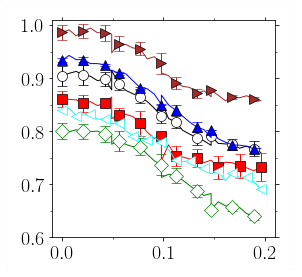

In [36]:
if not RemoteMachine:    

    PlotPaperVersion(2,1,
#                        xlabel=r'$\gamma$',
#                        ylabel=r'Percentage',
                        title='icoPercentage.png',
                        ylim=(0.6,1.01),
                        xlim=(-0.01,.21),
                        PlotMean = True,
#                        legend = True
                    )
    

## conditional pdf of d2min

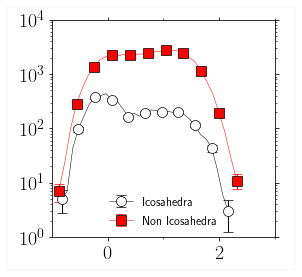

In [74]:

    


if DminAnalysis and VorAnl:
    
    PdfCondD2min( lmpVor, lmpDmin,
              times = [itime], #[2000000],#lmpData.coord_atoms_broken.keys(),     
              Plot = True,
              title = 'pdfCondD2minBad.png',
              axisLabels = False,
             )

### gaussian mixture

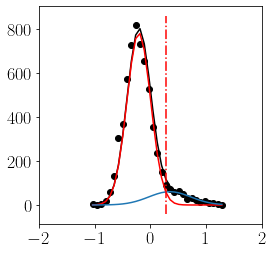

In [431]:
if DminAnalysis and VorAnl:
    
    d2minFiltrd, d2minTotal = PdfCondD2min( lmpVor, lmpDmin,
                                           #times = list(lmpData.coord_atoms_broken.keys()), 
                                           times=[itime], #[2000000],
                                           Plot = False,
                 )
    
    thresh, ratio, gsfitTotal = gaussian_mixture(
                                      #d2minTotal,
                                      d2minFiltrd[itime],
#                                     times = list(d2minFiltrd.keys()), 
                                      #times = [2000000],
                                      PLOT = True,
                                     )
    #--- save
#     nn=len(d2minFiltrd[2000000])
    np.savetxt('d2minFiltrdGood%s.txt'%itime,d2minFiltrd[itime])
    np.savetxt('gsfitTotalGood%s.txt'%itime,gsfitTotal)

#     strn = GetStrain(lmpData, 
#                      times = list(lmpData.coord_atoms_broken.keys()), 
#                      time0 = 0 )
#    np.savetxt('varD2minCondGamma.txt',
#               np.c_[valuesDict(strn,strn.keys()), valuesDict(ratio,ratio.keys())], 
#               header='gamma\tratio')


#### evolution with strain

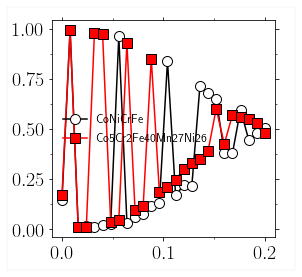

In [419]:
if not RemoteMachine:
    #
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    nfreq = 1
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
#     ax.set_xlabel(r'$\gamma$',fontsize=20)
#     ax.set_ylabel(r'Norm. Std',fontsize=20)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #ax.set_title()
    #
    for GlassType, marker, color, fillstyle in list(zip( [ 
#                                         'FeNi',
#                                         'CoNiFe',
                                        'CoNiCrFe/Run2',
#                                         'CoCrFeMn', 
#                                         'CoNiCrFeMn', 
                                        'Co5Cr2Fe40Mn27Ni26/Run0'
                                        ],markers, colors, fillstyles )):

        sarr  = np.loadtxt('d2minRatio%s/d2minRaioGamma.txt'%GlassType)
        #--- fliter
        ydata = sarr[:,1] #--- first 2nd col is stress drop
        xdata = sarr[:,0] #--- 2nd and 3rd cols are widths
    #
        ax.plot(xdata,ydata,
                linestyle='-',
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                markeredgecolor='black' if not fillstyle else None,
                markevery=int(len(xdata)/20),
                label = '%s'%GlassType[0:-5])
    #
    ax.legend(frameon=False, fontsize=12)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
    #
    plt.savefig('D2minGamma.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

### good, bad, and ugly!

No handles with labels found to put in legend.


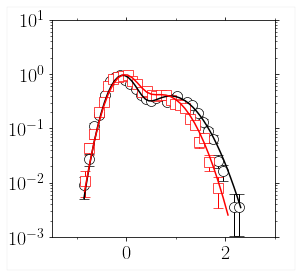

In [464]:
def PdfD2minGoodBad( lmpData, lmpDmin, badfit, goodfit,  times,  
                  Plot = True, title='pdfCondD2min.png',
                 axisLabels = True,
                    **kwargs
                ):
    #--- plot
    if Plot:
        fig = plt.figure(figsize=(4,4))
        ax = fig.add_subplot(111)
        #
        ax.set_xscale('linear' if not 'xscale' in kwargs else kwargs['xscale'])
        ax.set_yscale('linear' if not 'yscale' in kwargs else kwargs['yscale'])
        #
#         ax.set_ylim(1,1e4)
#         ax.set_xlim(-1,3)
#         #
        if axisLabels:
            ax.set_xlabel(r'log$D^2$min($A^2$)',fontsize=16)
            ax.set_ylabel(r'PDF',fontsize=16)
        #
        #ax.set_title(r'itime=%s'%itime)
        #
#        PutMinorTicks( ax, LOGY = True)
        #
        ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)

    valueFiltrd = {}
    valueTot = {}
    for itimee in sorted(times): 



        #--- filtered
        value = lmpDmin
        hist_filtrd, edges_filtrd, error_filtrd = GetPDF( np.log10(value), 
                                                         linscale = True, 
                                                         n_per_decade=32,
                                                         density = True,
                                                        )
        #--- invert
        valinv = lmpData
        hist_inv, edges_inv, error_inv = GetPDF( np.log10(valinv), 
                                                linscale = True, 
                                                n_per_decade=32,
                                                density = True,
                                               )


        if Plot:
            attr = { 'markersize':10,'markeredgewidth':0.7,
                     'linewidth':.5,'barsabove':None,'capsize':5,
                     'capthick':1,'elinewidth':1}
            #
            nmark = 16
            label = kwargs['label1'] if 'label1' in kwargs else ''
            ax.errorbar(edges_filtrd,hist_filtrd,error_filtrd,
                        **attr,
                        fmt='o', color='black', 
                        markerfacecolor='white', markeredgecolor=None,
                        label=label, markevery = int(len(edges_filtrd)/nmark),
                        errorevery = int(len(edges_filtrd)/nmark), zorder=1,
                       )
            #--- plot gs fit
            nn=len(lmpDmin)
            dx=goodfit[:,0][1]-goodfit[:,0][0]
            ax.plot(goodfit[:,0],goodfit[:,1]/nn/dx,'-',color='black',zorder=2)
            
            #
            label = kwargs['label2'] if 'label2' in kwargs else ''
            ax.errorbar(edges_inv,hist_inv,error_inv,
                        **attr,
                        fmt='s', color='red',
                        markerfacecolor='white', markeredgecolor='red',
                        label=label,markevery = int(len(edges_inv)/nmark),
                        errorevery = int(len(edges_inv)/nmark),zorder=1,
                       )
            #--- plot gs fit
            nn=len(lmpData)
            dx=badfit[:,0][1]-badfit[:,0][0]
            ax.plot(badfit[:,0],badfit[:,1]/nn/dx,'-',color='red',zorder=2)
    #
    if Plot:
        #
        if 'xlim' in kwargs:
            ax.axis(kwargs['xlim'])
        #
        LOGY = True if ('yscale' in kwargs and kwargs['yscale'] == 'log') else False
        LOGX = True if ('xscale' in kwargs and kwargs['xscale'] == 'log') else False
        PutMinorTicks(ax,LOGY=LOGY,LOGX=LOGX)
        #
        ax.legend(frameon=False, handletextpad=.01, fontsize=12)
        #
        DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04,LOG_Y=LOGY,LOG_X=LOGX)
        #
        plt.savefig(title,dpi=2*75,bbox_inches='tight',pad_inches=0.0)
        plt.show()


if DminAnalysis and VorAnl:
    itime = [700000,1000000,1300000,1600000,2000000][3]
    badData = np.loadtxt('d2minFiltrdBad%s.txt'%itime)
    goodData = np.loadtxt('d2minFiltrdGood%s.txt'%itime)
    goodfit =   np.loadtxt('gsfitTotalGood%s.txt'%itime)
    badfit =   np.loadtxt('gsfitTotalbad%s.txt'%itime)

    PdfD2minGoodBad( badData, goodData, badfit, goodfit,
              times = [itime], #[2000000],#lmpData.coord_atoms_broken.keys(),     
              Plot = True,
              title = 'pdfCondD2minGoodBad%s.png'%itime,
              axisLabels = False,
#              label1='Co5Cr2Fe40Mn27Ni26', label2='CoNiCrFe',
#              xlim=(-1,2.0,0,1),
              xlim=(-1.5,3.0,1e-3,10),
              yscale='log',
             )

### scatter plot

xmin= -40.132401640400005
xlin= -40.1340509202


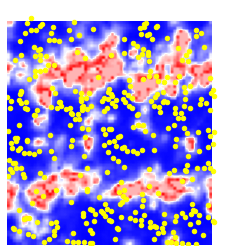

In [77]:
if DminAnalysis and VorAnl:

#     PlotDminVor( lmpVor, lmpDmin, 
#                  times = [itime], #[2000000],#list(lmpData.coord_atoms_broken.keys()),
#                 title='d2minBad',
#                )

    vor = lp.Atoms( **lmpVor.coord_atoms_broken[itime].to_dict(orient='series') )
    d2min = lp.Atoms( **lmpDmin.coord_atoms_broken[itime].to_dict(orient='series') )
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ))

    #
    (xlin, ylin, zlin), (xv, yv, zv), mu_intrp = IntrpScatter(
                    d2min, box, 'd2min',
                    vor,
                    Plot = True,
                    title='d2minGood20000002nd.png',
                    ticklabels = False,
                    colorbar = False,
                   )
    

## SRO density

InputFile= junk.xyz
num_frames= 1
frame=0


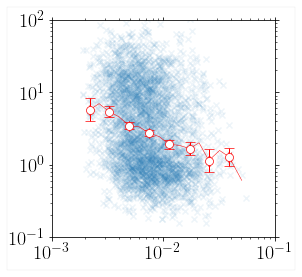

cxy= -0.2638464317166046


In [198]:
if DminAnalysis and VorAnl:
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ))
    #
    vor = lp.Atoms( **lmpVor.coord_atoms_broken[itime].to_dict(orient='series') )
    #
    d2min = lp.Atoms( **lmpDmin.coord_atoms_broken[itime].to_dict(orient='series') )
    #
    rho = sroDensityDiscrete( vor, box,
                              AtomicRadius )
    #              
    vor.tmp = rho
    d2min.tmp = d2min.d2min
    #
    crs = ScatterXY(  vor, d2min,
                Plot = True, 
                PLOT_AVERAGE = True,
                axisLabels = True,
                xlim=(1e-3,1e-1,1e-1,1e2),
                title = 'scatterD2minRhoBad2nd.png', 
                )                      
    print('cxy=',crs)    
    #--- save
    strn = GetStrain(lmpData, 
                     times = itime, #list(lmpData.coord_atoms_broken.keys()), 
                     time0 = 0 )
    np.savetxt('crsD2minRhoSro.txt',
               np.c_[strn,crs], 
               header='gamma\tCrltnCoeff')


### kde

(nx,ny)= (128, 128)


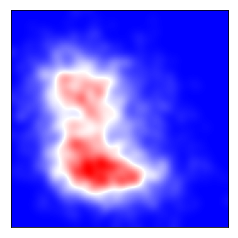

In [199]:
def GetInterpolatedData2d( x,y, 
                         xv, yv
                       ):
    dx = xv[1]-xv[0]
    dy = yv[1]-yv[0]
    dr = (dx*dx+dy*dy)**0.5
    r2nd=3*dr #--- g(r)
    sigma = int(r2nd/dr)
    heatmap, edges = np.histogramdd( np.c_[y, x],
                                    bins=[np.append(yv,yv[-1]+dy),
                                          np.append(xv,xv[-1]+dx)],
                                    normed=True)

    print('(nx,ny)=', heatmap.shape )
    
    heatmap *= len( x )
    heatmap = gaussian_filter( heatmap, sigma = sigma )
    return heatmap

def DensityMap2d(xs, ys, **kwargs):    
    #--- scattered points
#     xs = np.array(atoms0.xm)[filtr] #--- must be reference frame!
#     ys = np.array(atoms0.ym)[filtr]
#     zs = np.array(atoms0.zm)[filtr]

#    (nx,ny,nz)=list(map(len,[xv,yv,zv]))
    
    xv=np.linspace((xs.min()),(xs.max()),128)
    yv=np.linspace((ys.min()),(ys.max()),128)
    #--- density
    heatmap2d=GetInterpolatedData2d(xs,ys,
                                xv, yv,
                               )
    #--- bitmap
    PltBitmap(
          heatmap2d, #transpose? 
          **kwargs
          )

    
    return heatmap2d
    
if DminAnalysis and VorAnl:
    #--- cross crltn.
    x = np.array(vor.tmp)
    y = np.array(d2min.tmp)
    #---

    y=y[x>0]
    x=x[x>0]

    attrs={
          'xlabel' : r'$x$(\r{A})', 'ylabel' : r'$y$(\r{A})',
#          xlim=np.array([xv.min(),xv.max()]),ylim=np.array([yv.min(),yv.max()]),
          'zscore' : None,
          'frac' : 1.0, #--- plot a patch
          'title' : 'kdeRhoBad.png',
#          'colorbar':True,
          'labels' : False,
          'color':'black',
#                     DrawFrame=[0.2,0.09,0.15,0.06,0.04],
    }
    DensityMap2d(np.log10(x), np.log10(y),**attrs)


### multiple frames

InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1
frame=0
InputFile= junk.xyz
num_frames= 1


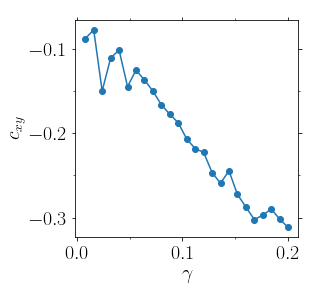

In [92]:
def vor(x):
    box = lp.Box( BoxBounds = lmpData.BoxBounds[x], AddMissing = np.array([0.0,0.0,0.0] ))
    tmp = lp.Atoms( **lmpVor.coord_atoms_broken[x].to_dict(orient='series') )
    rho = sroDensityDiscrete( tmp, box,
                              AtomicRadius )
    tmp.tmp = rho
    return tmp
#
def d2min(x):
    tmp = lp.Atoms( **lmpDmin.coord_atoms_broken[x].to_dict(orient='series') ) 
    tmp.tmp = tmp.d2min
    return tmp

if DminAnalysis and VorAnl:
    #
    times = list(lmpDmin.coord_atoms_broken.keys())
    times.sort()
    times.pop(0)

    crs = map(lambda x:ScatterXY(  vor(x), d2min(x),
                Plot = False, 
                PLOT_AVERAGE = False,
                ),times)                     
    
    #--- save
    ydata = np.array(list(crs))
    xdata = np.array(list(map(lambda x:GetStrain(lmpData, x, 0 ),times)))
    np.savetxt('crsD2minRhoSro.txt',
               np.c_[xdata,ydata], 
               header='gamma\tCrltnCoeff')
    

    #--- plot
    PltErr(xdata,
           ydata,
           yerr=None,
#      ylim=[0,5],
       ystr='$c_{xy}$',
       xstr='$\gamma$',
#       yscale='log',
#       xscale='log',
#       title='dmin_gamma.png'
      )

### multiple systems

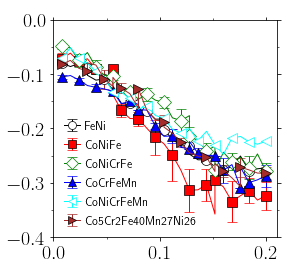

In [44]:
if not RemoteMachine:
    PlotPaperVersion(
                        pathh_indx = 2,
                        file0_indx = 4,
                        #
                        title='cxyGamma2nd.png',
#                        xlabel=r'$\gamma$',
#                        ylabel=r'cxy',
                        ylim=(-0.4,0),
                        xlim=(0.0,.21),
                        legend = True,
#                        yscale='log',
                        borderwidth = 0.001,
                        PlotMean = True,
                      )

### hmin and cxy

[-0.27945408 -0.27890289 -0.28570318 -0.3773356  -0.28736781 -0.3139864
 -0.25742434 -0.24308035 -0.29776095 -0.25823142 -0.34262832 -0.22980893
 -0.30211744 -0.3071519  -0.25745512]
[44.16854417 -9.3326129 ]


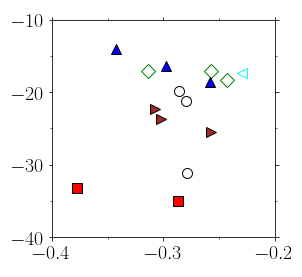

In [276]:
if not RemoteMachine:
    
    PlotPaperVersionScatter( 2, #--- path:
                            xindx=4, colx = 1, #--- x: cxy (2nd column)
                            yindx=5, coly = 1, #--- y: hmin( 2nd column)
#                        xlabel=r'$c_{xy}$',
#                        ylabel=r'$h_{min}$',
                        title='hCxy2nd.png',
                         xlim=(-0.4,-0.2),
                        ylim=(-40.0,-10.0),
#                        legend = True,
#                        yscale='log',
                        borderwidth = 0.001,
                        fontsize = 20,
                            
                           )


# Local Moduli
+ analysis of local modulus fluctuations
+ output files in "ModuAnl" directory

In [153]:
os.system('mkdir ModuAnl')

0

## parse data

In [147]:
def GetAtoms( filee, nevery = 1 ):
    lmpData = lp.ReadDumpFile( filee )
    lmpData.GetCords( ncount = sys.maxsize, 
                     columns = {'c_peratom[1]':'sxx','c_peratom[2]':'syy','c_peratom[3]':'szz',
                                                       'c_peratom[4]':'sxy','c_peratom[5]':'sxz','c_peratom[6]':'syz'}
                    )
    nn=len(lmpData.coord_atoms_broken.keys())
    itimee=list(lmpData.coord_atoms_broken.keys())[0:nn:nevery]

    #--- volume
    rad1=0.0#AtomicRadius[1]
    rad2=0.0#AtomicRadius[2]
    rad3=0.0#AtomicRadius[3]
    neveryy = 10*nn #--- only initial frame for computing volumes
    !ovitos OvitosCna.py $filee Voronoi.xyz $neveryy 3 $rad1 $rad2 $rad3  
#--- read from d2min.xyz
    ovtData = lp.ReadDumpFile( 'Voronoi.xyz' )
    ovtData.GetCords( ncount = sys.maxsize)
    #--- atom obj
    box0 = map(lambda x:lp.Box( BoxBounds = lmpData.BoxBounds[x], AddMissing = np.array([0.0,0.0,0.0] ) ), itimee ) #--- reference state
    atoms0 = map(lambda x: lp.Atoms( **lmpData.coord_atoms_broken[x].to_dict(orient='series'),
                        AtomicVolume = ovtData.coord_atoms_broken[0]['AtomicVolume'].tolist()), itimee )

    return dict(zip(itimee,list(atoms0))), dict(zip(itimee,list(box0)))

def GetTimeAverageSeries( atoms, col='x' ):
    sarr = np.array(list(map( lambda x: atoms[x][col], atoms.keys() ))).T
    return np.mean(sarr,axis=1)

def GetTimeAverageAtom( atoms0 ):
#    pdb.set_trace()
    itime0 = list(atoms0.keys())[0]
    attrs=atoms0[itime0].__dict__.keys()
    #
    sarr = np.array(list(map(lambda x: GetTimeAverageSeries( atoms0, col=x ), attrs))).T
    df = pd.DataFrame(sarr,columns=attrs)
    #--- pbc: mean of x is not valid! set it to initial values
#    pdb.set_trace()
    df.x = atoms0[itime0]['x'].to_list()
    df.y = atoms0[itime0]['y'].to_list()
    df.z = atoms0[itime0]['z'].to_list()
    #---
    sdict= df.to_dict(orient='series')    
    atomi=lp.Atoms(**sdict)
#    pd.DataFrame(atomi.__dict__)
    return atomi

if ModuAnl:
    t0=time.time()    
    #--- read initial atomic positions/stresses
    atomi, boxi = GetAtoms( '%s/dump_init.xyz'%path, nevery = 1 ) #--- change it to 1
    atoms0 = GetTimeAverageAtom( atomi ) #--- argument: dic with key: time and val: atom object
    #
    itime0 = list(atomi.keys())[0]
    box0=boxi[itime0]
    #
    atomd = {}
    boxd = {}
    ebulk = {}
    #--- read data for deformed configurations
    #for dirr, mode in zip(range(1,7),['xx','yy','zz','yz','xz','xy']):
    for dirr, mode in zip([6],['xy']):
        atomt, boxt = GetAtoms( '%s/dump_def%s.xyz'%(path,dirr), nevery=1 )
        atomt.pop(0) #--- time 0 is not equilibrated!
        atomd[mode] = GetTimeAverageAtom( atomt )
        #
        itime0 = list(atomt.keys())[0]
        boxd[mode] = boxt[itime0]
        #
        #--- evaluate strain
        if dirr == 1 or dirr == 2 or dirr == 3:
            indxi = dirr - 1
            indxj = dirr - 1
        elif dirr == 6: #--- xy
            indxi = 0
            indxj = 1
        dx=boxd[mode].CellVector[indxi,indxj]-box0.CellVector[indxi,indxj]
        l0=box0.CellVector[indxj,indxj]        
        ebulk[mode] = dx/l0    
    ebulk['yz']=ebulk['xz']=ebulk['xy']
    print('ebulk=',ebulk)
    #
    print('duration=%s s'%(time.time()-t0))

    
    

InputFile= /Users/Home/Desktop/Tmp/txt/itime0/dump_init.xyz
num_frames= 21
frame=0
InputFile= /Users/Home/Desktop/Tmp/txt/itime0/dump_def6.xyz
num_frames= 21
frame=0
ebulk= {'xy': -0.020000000000000004, 'yz': -0.020000000000000004, 'xz': -0.020000000000000004}
duration=53.173206090927124 s


In [146]:
#path='/Users/Home/Desktop/Tmp/txt/itime0'

## elastic constants

In [148]:
if ModuAnl:
    cfac = 1.0e-4 #--- bar to gpa
    dxx={}
    dyy={}
    dzz={}
    dyz={}
    dxz={}
    dxy={}
    for mode in ['xy']: #['xx','yy','zz','yz','xz','xy']:
        dxx[mode]=(atomd[mode].sxx/atomd[mode].AtomicVolume-atoms0.sxx/atoms0.AtomicVolume)/ebulk[mode]*cfac
        dyy[mode]=(atomd[mode].syy/atomd[mode].AtomicVolume-atoms0.syy/atoms0.AtomicVolume)/ebulk[mode]*cfac
        dzz[mode]=(atomd[mode].szz/atomd[mode].AtomicVolume-atoms0.szz/atoms0.AtomicVolume)/ebulk[mode]*cfac
        dyz[mode]=(atomd[mode].syz/atomd[mode].AtomicVolume-atoms0.syz/atoms0.AtomicVolume)/ebulk[mode]*cfac
        dxz[mode]=(atomd[mode].sxz/atomd[mode].AtomicVolume-atoms0.sxz/atoms0.AtomicVolume)/ebulk[mode]*cfac
        dxy[mode]=(atomd[mode].sxy/atomd[mode].AtomicVolume-atoms0.sxy/atoms0.AtomicVolume)/ebulk[mode]*cfac

### output dump

In [149]:
if ModuAnl:
    df=pd.DataFrame(atoms0.__dict__)
    cols = list(df.keys())+['C66'] # + ['C55'] + ['C44']#--- C66 is cxyxy
    df = pd.DataFrame(np.c_[df,dxy['xy'],
    #                        dxz['xz'],
    #                        dyz['yz']
                           ],
                      columns=cols)
    atomm = lp.Atoms(**df)
    wd = lp.WriteDumpFile(atomm, box0)
    wd.Write('dump.xyz',
             attrs=['id', 'type','x', 'y', 'z', 'sxx', 'syy', 'szz', 'sxy', 'sxz', 'syz',
                   'AtomicVolume', 'C66'],
             fmt='%i %i %15.14e %15.14e %15.14e %4.3e %4.3e %4.3e %4.3e %4.3e %4.3e %4.3e %4.3e')
    os.system('tar czf dump.gz dump.xyz')

#### append

In [150]:
# if not RemoteMachine:
#     try:
#         os.system('rm Modu.xyz')
#     except:
#         pass
#     for i in range(200):
#         os.system('tar xzf FeNiT300Elasticity%s/Run1/dump.gz'%(i))
#         os.system('cat dump.xyz >> Modu.xyz')
# #        os.system('cat FeNiT300Elasticity%s/Run1/dump.xyz >> Modu.xyz'%(i))

### map

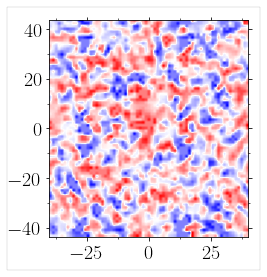

In [146]:
if ModuAnl:
    (xlin, ylin, zlin), (xv, yv, zv), d2intrp = Intrp(atomm, box0, 'C66',
                    Plot = True,
                    title='mapCxyxy.%s.png'%itime,
#                    cmap='Greys',
#                    colorbar=True,
                    zscore=True,
                    DrawFrame=(0.21,0.06,0.15,0.06,0.1),
                    xlabel = '', ylabel = '',
#                    vmin=,vmax=,
                   )

In [77]:
# itime = times[strainDump>=ey][0]
# print('itime(peak)=%s'%itime)    
# itime = times[strainDump>=em][0]
# print('itime(max. drop)=%s'%itime)
# itime = times[strainDump>=ef][0]
# print('itime(flow)=%s'%itime)
#itime=0

## crltn with D2min 

In [305]:
if ModuAnl and not RemoteMachine :
    #--- d2min associated with the perturbed states
    refs='%s/dump_init.xyz'%path
    curr='%s/dump_def%s.xyz'%(path,6)
    !rm 'd2min.xyz'
    !ovitos OvitosCna.py $curr 'd2min.xyz' 1 2 $refs
    #--- read from d2min.xyz
    lmpDmin = lp.ReadDumpFile( 'd2min.xyz' )
    lmpDmin.GetCords( ncount = sys.maxsize, columns = {'NonaffineSquaredDisplacement':'d2min'} )

rm: d2min.xyz: No such file or directory
InputFile= /Users/Home/Desktop/Tmp/txt/itime0/dump_def6.xyz
num_frames= 21
frame=0
frame=1
frame=2
frame=3
frame=4
frame=5
frame=6
frame=7
frame=8
frame=9
frame=10
frame=11
frame=12
frame=13
frame=14
frame=15
frame=16
frame=17
frame=18
frame=19
frame=20


### average 

In [394]:
if ModuAnl and not RemoteMachine:
    #slist=[]
    atoms={}
    for key in lmpDmin.coord_atoms_broken.keys():
        if key ==0:
            continue
        atoms[key] = lp.Atoms( **lmpDmin.coord_atoms_broken[key].to_dict(orient='series') )
#        slist += [atoms[key]['d2min'].iloc[0]]
    #plt.hist(slist,bins=32)
    #plt.show()
    d2min = GetTimeAverageAtom( atoms )

### Spatial map 

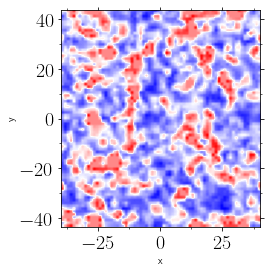

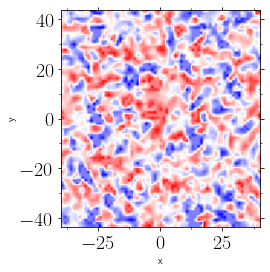

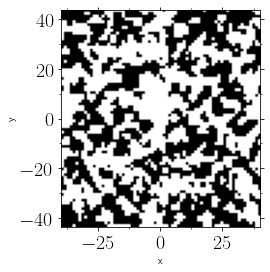

In [321]:
#---
if ModuAnl and not RemoteMachine:
#    itime=2000000
#    vor = lp.Atoms( **lmpVor.coord_atoms_broken[itime].to_dict(orient='series') )
    #
#     (xlin, ylin, zlin), (xv, yv, zv), d2min_intrp = IntrpScatter(
#                     d2min, box0, 'd2min',
#                     vor,
#                     Plot = True,
#                     title='scatterD2minRhoGood.png'
#                    )
    (xlin, ylin, zlin), (xv, yv, zv), d2min_intrp = Intrp(
                    d2min, box0, 'd2min',
                    Plot = True,
                    title='D2minPerturbIntrp.%s.png'%itime
                   )

    junk, (xv, yv, zv), mu_intrp = Intrp(atomm, box0, 'C66',
                    Plot = True,
                    title='mapCxyxy.png'
                   )

    mu=(atomm.C66).mean() #((atomm.C44+atomm.C55+atomm.C66)/3).mean()
    mu_std=(atomm.C66).std() #((atomm.C44+atomm.C55+atomm.C66)/3).std()

    junk = PltBinary(
                        xlin,ylin,zlin, mu_intrp.C66,
                        box0,
                        mu,
                        cmap='Greys',
#                        title='negative_mu.%s.png'%itime,
                        #                    cmap='Greys',
                        zscore=False,
                        #                DrawFrame=(0.21,0.06,0.15,0.06,0.1),
                        xlabel = 'x', ylabel = 'y',
                        labels = True,
                     )

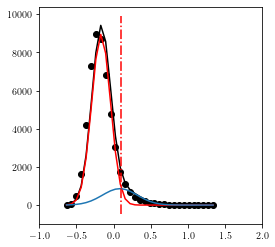

thresh= 0.10582942168843111


In [45]:
if ModuAnl and not RemoteMachine:
    thresh, ratio, junk = gaussian_mixture(
                                     dict(zip([itime],[d2min.d2min])),
                                     times = [itime], 
                                     PLOT = True,
                                 )
    mu_divide = np.log10(thresh[itime])
    print('thresh=',mu_divide)

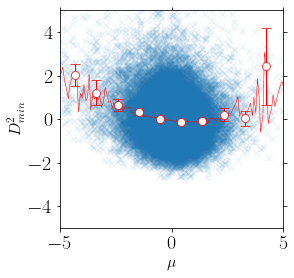

In [407]:
if ModuAnl and not RemoteMachine:
    atomm.tmp = atomm.C66
    d2min.tmp = d2min.d2min
    #
    ScatterXY(  atomm,d2min,
                Plot = True, 
                PLOT_AVERAGE = True,
                nbins_per_decade = 12,
                xscale = 'linear',
                yscale = 'log',
                zscore = True,
                xlim=np.array([-1,1,-1,1])*5,
    #            title = 'scatterModuRho.png',
                axisLabels=(r'$\mu$',r'$D^2_{min}$'),
    #            xerr = None
                )            

## mu auto correlation

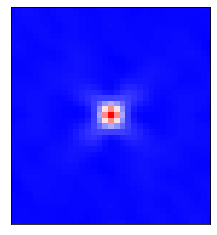

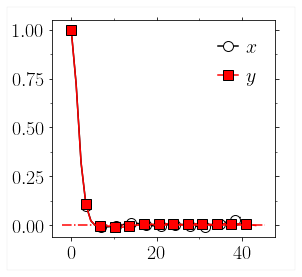

In [48]:
if ModuAnl and not RemoteMachine:
    (nx,ny,nz) = len(xlin), len(ylin),len(zlin) 
    #
    value = np.c_[mu_intrp.C66].reshape((ny,nx,nz))
    Crltn = GetAutoCorrelation( value )
    #
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector ) #--- box length
    #--- xy plane
    val = Crltn[:,:,0].copy()
    PltCrltn( val, 
              xlabel = '', ylabel = '',
              xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
              frac = 0.5, #--- plot a patch
              zscore = False,
              fileName = 'cxy_mu.png',
              dpi = 60
            )
    #---
    (xc, yc), (xdata0,ydata0), (xdata,ydata)=\
    PltCrltnFunc( Crltn, 
                 xv,yv,
                 fileName = 'cr_mu.png',
                 title = '',
                 cTOL = 8.0e-2,
                 dpi = 60,
                )
    #--- bulk strain
    dx=box0.CellVector[0,1]
    l1=box0.CellVector[1,1]
    ebulk = dx/l1
    #--- save
    np.savetxt('mu_length.txt',np.c_[ebulk,xc,yc],header='strain\txc\tyc')
    xc,yc

### discrete version

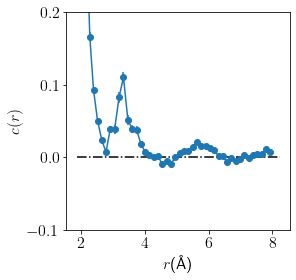

In [49]:
if ModuAnl and not RemoteMachine:
    #--- neighbor list
    neigh = lmpNeigh.coord_atoms_broken[itime]
    
    #--- ij pairs
    atomiIds = np.array(neigh.id)
    atomjIds = np.array(neigh.J,dtype=int)

    #--- product of rho and mu
    df_mod = pd.DataFrame(atomm.__dict__)

    #--- zscore
    df_modi = FilterDataFrame(df_mod,key='id',val=atomiIds)
    df_modj = FilterDataFrame(df_mod,key='id',val=atomjIds)
    x = df_modi['C66']
    y = df_modj['C66']
    #---
    crltn = lp.ComputeCrltn(  atomm, box0, 
                              atomm.C66, #--- values
                              dx = 0.13)
    crltn.AutoCrltn2nd(RADIAL = True, 
                    rlist = neigh.DIST,
                    rvect = np.c_[neigh[['DX','DY','DZ']]],
                    xlist = x,
                    ylist = y
                   )
    rv, hist, err = crltn.Get()
    #--- plot
    PltErr(rv,hist,err,      
           ylim=[-0.1,0.2],#[-.1,.3],
           title='crMuMu.png',
           xstr=r'$r$(\r{A})',
          )
    #--- save
    np.savetxt('crMuMu.%s.txt'%itime,np.c_[rv, hist, err],header='r\tc(r)\terr')
    

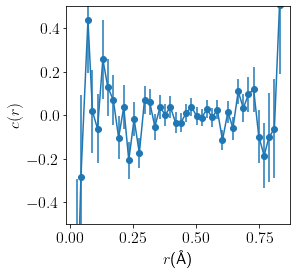

In [1289]:
# n=3*10000
# x=np.random.random(size=n)-0.5
# x=x.reshape((int(n/3),3))
# r=(x[:,0]**2+x[:,1]**2+x[:,2]**2)**.5
# v=np.random.random(size=int(n/3))
# vs = v.copy()
# np.random.shuffle(v)
# if 1:
#     crltn = lp.ComputeCrltn(  atoms, box, 
#                               atomm.C66, #--- values
#                               dx = 0.02)
#     crltn.AutoCrltn2nd(RADIAL = True, 
#                     rlist = r,
#                     rvect = x,
#                     xlist = v,
#                     ylist = vs #np.random.shuffle(v)
#                    )
#     rv, hist, err = crltn.Get()
#     #--- plot
#     PltErr(rv,hist,err,      
#            ylim=[-0.5,0.5],#[-.1,.3],
#            title='crMuMu.png',
#            xstr=r'$r$(\r{A})',
#           )
# # #plt.hist(x)
# # #plt.show()

### multiple files

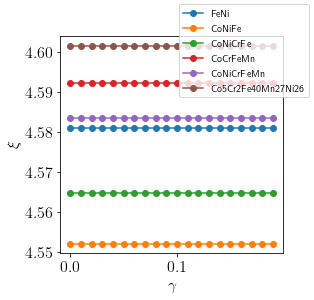

In [499]:
if not RemoteMachine:
    #--- plot
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #
    ax.set_ylabel(r'$\xi$',fontsize=16)
    ax.set_xlabel(r'$\gamma$',fontsize=16)
    ax.tick_params(labelsize=16)
    #
    for mg in [
                'FeNi',
                'CoNiFe',
                'CoNiCrFe',
                'CoCrFeMn',
                'CoNiCrFeMn',
                'Co5Cr2Fe40Mn27Ni26'
                ]:
    
        try:
            os.system('rm mu_size.txt')
        except:
            pass
        for i in range(0,200,10):
            os.system('cat %sT300Elasticity%s/Run1/mu_length.txt >> mu_size.txt'%(mg,i))

        sarr = np.loadtxt('mu_size.txt')
        ax.plot(sarr[:,0],0.5*(sarr[:,2]+sarr[:,1]),'-o',label=mg)
    #
    fig.legend()
    plt.savefig('crltnMuLength.png',dpi=75,bbox_inches='tight')
    #
    plt.show()


### length and hmin

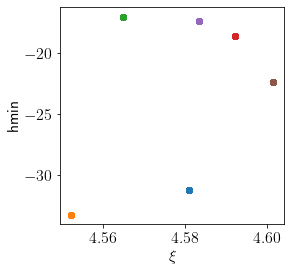

In [444]:
if not RemoteMachine:
    #--- plot
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #
    ax.set_xlabel(r'$\xi$',fontsize=16)
    ax.set_ylabel(r'hmin',fontsize=16)
    ax.tick_params(labelsize=16)
    #
    for mg in [
                'FeNi',
                'CoNiFe',
                'CoNiCrFe',
                'CoCrFeMn',
                'CoNiCrFeMn',
                'Co5Cr2Fe40Mn27Ni26'
                ]:
    
        try:
            os.system('rm mu_size.txt')
        except:
            pass
        try:
            os.system('rm hmin.txt')
        except:
            pass
        #
        for i in range(0,200,10):
            os.system('cat %sT300Elasticity%s/Run1/NegativeModulus.txt >> hmin.txt'%(mg,i))
            os.system('cat %sT300Elasticity%s/Run1/mu_length.txt >> mu_size.txt'%(mg,i))
        sarr = np.loadtxt('mu_size.txt')
        hmin = np.loadtxt('hmin.txt')
        #
        ax.scatter(0.5*(sarr[:,2]+sarr[:,1]),-hmin[:,1],marker='o',label=mg)
    #
#    fig.legend()
    plt.savefig('crltnMu.png',dpi=75,bbox_inches='tight')
    #
    plt.show()


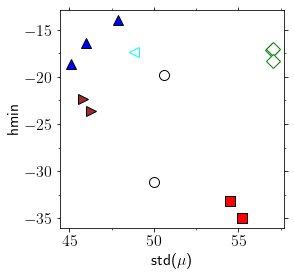

In [87]:
if not RemoteMachine:
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']

    #--- plot
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #
#    ax.set_xlabel(r'std($\mu$)/$\langle\mu\rangle$',fontsize=16)
    ax.set_xlabel(r'std($\mu$)',fontsize=16)
    ax.set_ylabel(r'hmin',fontsize=16)
    ax.tick_params(labelsize=16)
    #
    for mg, marker, color, fillstyle in list(zip( [ 
                                         'FeNi',
                                          'CoNiFe',
                                           'CoNiCrFe',
                                            'CoCrFeMn',
                                            'CoNiCrFeMn',
                                            'Co5Cr2Fe40Mn27Ni26'
                                        ],markers, colors, fillstyles )):    
        try:
            os.system('rm mu_size.txt')
        except:
            pass
        try:
            os.system('rm hmin.txt')
        except:
            pass
        #
        for itimee in range(0,1,1):
            for irun in range(3):
                pathh = '%s/ElasticityT300/%s/itime%s/Run%s'%(os.getcwd(),mg,itimee,irun)
                file0 = '%s/NegativeModulus.txt'%pathh
                file1 = '%s/mu_mean_std.txt'%pathh
#                pdb.set_trace()
                if os.path.isfile( file0 ) and os.path.isfile( file1 ):
                    os.system('cat %s >> hmin.txt' %file0 )
                    os.system('cat %s >> mu_size.txt'%file1)
                
        sarr = np.loadtxt('mu_size.txt')
        hmin = np.loadtxt('hmin.txt')
        #
        if len(sarr.shape) == 2:
            slope = -hmin[:,1]
            std_mu = sarr[:,2]
            mean_mu = sarr[:,1]
        elif len(sarr.shape) == 1:
            slope = -hmin[1]
            std_mu = sarr[2]
            mean_mu = sarr[1]

        #
        ax.plot(std_mu,slope,'.',
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                markeredgecolor='black' if not fillstyle else None,
                label = '%s'%mg)
        # 
#    fig.legend(bbox_to_anchor=(1.4,.8))
    plt.savefig('MuHmin.png',dpi=75,bbox_inches='tight')
#     #
    plt.show()


## Crltns with SRO
### scatter map 

77 77


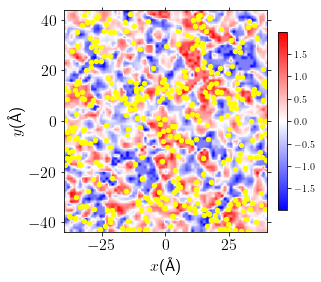

In [1299]:
if ModuAnl and not RemoteMachine:
    #--- voronoi data
#    !ovitos OvitosCna.py 'dump.xyz' 'Voronoi.xyz' 1 3 $rad1 $rad2 $rad3 $rad4 $rad5  
#    lmpVor = lp.ReadDumpFile( 'Voronoi.xyz' )
#    lmpVor.GetCords( ncount = sys.maxsize)
#    vor = lp.Atoms( **lmpVor.coord_atoms_broken[0].to_dict(orient='series') )
    vor = lp.Atoms( **lmpVor.coord_atoms_broken[itime].to_dict(orient='series') )
    #
    (xlin, ylin, zlin), (xv, yv, zv), mu_intrp = IntrpScatter(
                    atomm, box0, 'C66',
                    vor,
                    Plot = True,
                    title='mapCxyxySro.png'
                   )

### scatter mu and sro

InputFile= junk.xyz
num_frames= 1
frame=0


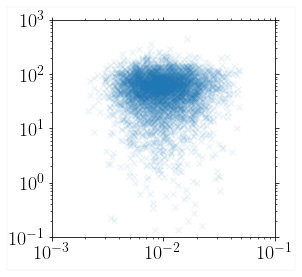

In [1300]:
if ModuAnl and not RemoteMachine:

    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ))
    #
    vor = lp.Atoms( **lmpVor.coord_atoms_broken[itime].to_dict(orient='series') )
    #--- density of SROs: see PRB draft
    rho = sroDensityDiscrete( vor, box,
                              AtomicRadius )
    #              
    vor.tmp = rho
    atomm.tmp = atomm.C66
    #
    ScatterXY(  vor, atomm,
                Plot = True, 
                PLOT_AVERAGE = None,
                xlim=np.array([1e-3,1e-1,1e-1,1e3]),
                title = 'scatterModuRho.png',
                axisLabels=(r'$\rho_{sro}$',r'$\mu$'),
                )            


#### gr

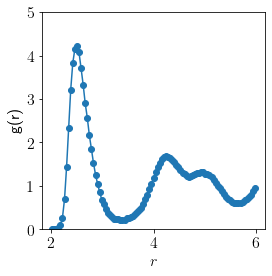

In [1301]:
if ModuAnl and not RemoteMachine:

    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ))
    atoms = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='series') )
    neigh = lmpNeigh.coord_atoms_broken[itime]


    rdf = lp.ComputeRdf(  atoms, box )
    rdf.PairCrltn( nbins = 100, 
                  bins=np.linspace(2.0,cutoff,100), 
                  rlist=neigh.DIST )
    bin_edges, hist, err = rdf.Get()

    #--- plot
    #plt.errorbar(bin_edges,hist,yerr=err,fmt='-o')

    PltErr(bin_edges,hist,err,
          ylim=[0,5],
           ystr='g(r)',
           title='gr.png'
          )

#### mean mu.rho

In [1302]:
if ModuAnl and not RemoteMachine:

    #--- compute the product using the neighbor list

    icoFiltr = vor.id[ vor.tmp > 0.0 ] #--- atom id with ico. symmetry
    neigh_filtrd = FilterDataFrame(neigh,key='id',val=icoFiltr) #--- filter neighbor list

    #--- ij pairs
    atomiIds = np.array(neigh_filtrd.id)
    atomjIds = np.array(neigh_filtrd.J,dtype=int)

    # #--- product of rho and mu
    df_vor=pd.DataFrame(vor.__dict__)
    df_mod = pd.DataFrame(atomm.__dict__)

    #--- zscore
    df_vor_filtrd = FilterDataFrame(df_vor,key='id',val=atomiIds)
    df_mod_filtrd = FilterDataFrame(df_mod,key='id',val=atomjIds)

    x = np.array(df_vor_filtrd['tmp'])
    y = np.array(df_mod_filtrd['C66'])

#    prod = Zscore(x) * Zscore(y)
#    y=(y-y.mean())/y.mean()
#    prod = x * y

#### mean vs r.

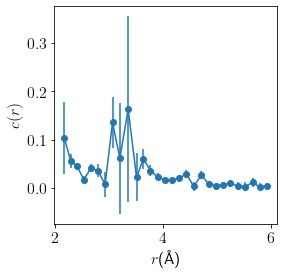

In [1304]:
if ModuAnl and not RemoteMachine:
    crltn = lp.ComputeCrltn(  atoms, box, 
                              atomm.C66, #--- values
                              dx = 0.13)
    crltn.AutoCrltn2nd(RADIAL = True, 
                    rlist = neigh_filtrd.DIST,
                    rvect = np.c_[neigh_filtrd[['DX','DY','DZ']]],
                    xlist = x,
                    ylist = y
                   )
    rv, hist, err = crltn.Get()
    #--- plot
    PltErr(rv,hist,err,      
#           ylim=[-0.001,0.004],#[-.1,.3],
           title='crMuRho.png',
           xstr=r'$r$(\r{A})',
          )
    #--- save
    np.savetxt('crMuRho.txt',np.c_[rv, hist, err],header='r\tc(r)\terr')
    

##### multiple systems

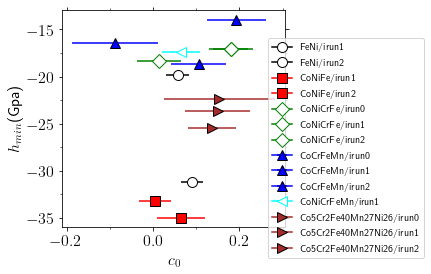

In [1042]:
if not RemoteMachine:
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']

    #--- plot
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #
#    ax.set_xlabel(r'std($\mu$)/$\langle\mu\rangle$',fontsize=16)
#    ax.set_xlabel(r'$r$(\r{A})',fontsize=16)
#    ax.set_ylabel(r'$c(r)$',fontsize=16)
    ax.set_ylabel(r'$h_{min}$(Gpa)',fontsize=16)
    ax.set_xlabel(r'$c_0$',fontsize=16)
    ax.tick_params(labelsize=16)
    #
    for mg, marker, color, fillstyle in list(zip( [ 
                                        'FeNi',
                                          'CoNiFe',
                                           'CoNiCrFe',
                                            'CoCrFeMn',
                                            'CoNiCrFeMn',
                                             'Co5Cr2Fe40Mn27Ni26'
                                        ],markers, colors, fillstyles )):    
#         try:
#             os.system('rm crMuRho_concat.txt')
#         except:
#             pass
#         try:
#             os.system('rm hmin.txt')
#         except:
#             pass
        #
        for itimee in [200]: #range(0,1,1):
            for irun in range(3):
                pathh = '%s/ElasticityT300/%s/itime%s/Run%s'%(os.getcwd(),mg,itimee,irun)
                file0 = '%s/crMuRho.txt'%pathh
                file1 = '%s/NegativeModulus.txt'%pathh
#                pdb.set_trace()
                if os.path.isfile( file0 ) and os.path.isfile( file1 ):
#                    os.system('cat %s >> crMuRho_concat.txt' %file0 )
#                    os.system('cat %s >> mu_size.txt'%file1)
                
                    sarr = np.loadtxt(file0)
                    sarr2nd = np.loadtxt(file1)
                    #
                    xdata = sarr[:,0] #--- r
                    ydata = sarr[:,1] #--- c(r)
                    yerr = sarr[:,2]
                    #--- find min/max
                    slist = list(zip((ydata),range(len(ydata))))
                    slist.sort(reverse=True)
                    (junk,indx0)=slist[0]
                    indx0 = 0
                    ydata0 = ydata[indx0]
                    yerr0 = yerr[indx0]
                    #
                    slope = -sarr2nd[1]
                    #
                    attrs={ 'color':color,
                            'markersize':10,
                            'marker':marker,
                            'markerfacecolor':fillstyle,
                            'markeredgecolor':'black' if not fillstyle else None,
                            'label':'%s/irun%s'%(mg,irun),
                          }
                        
                    PltErr(ydata0,slope, err=None,      
#                           xlim=[-.1,.3],
                           title='crMuRho.png',
                           ax = ax,
                           attrs = attrs,
                           xerr=yerr0,
                          )
    fig.legend(bbox_to_anchor=(1.4,.8))
    plt.savefig('MuHmin.png',dpi=75,bbox_inches='tight')
    plt.show()


### kde

(nx,ny,nz)= (77, 69, 77)
77 77


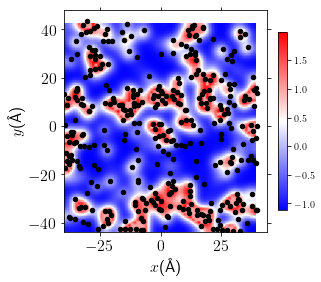

rho.shape= (77, 69, 77)


In [551]:
if ModuAnl and not RemoteMachine:
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0] ))
    #
    vor = lp.Atoms( **lmpVor.coord_atoms_broken[itime].to_dict(orient='series') )
    #
    mapp = lp.Map( vor, box ) 
    mapp.ChangeBasis()
    mapp.Set( vor ) #--- atoms: add mapped xyz
    #--- filter icosahedral atoms
    icoFiltr = GetFullIcosahedra( vor )
    #--- kde density
    rho = DensityMap(vor, icoFiltr, xlin, ylin, zlin )
    print('rho.shape=',rho.shape)

#### cross crltn

In [527]:
if ModuAnl and not RemoteMachine:

    mu_reshaped = np.array(mu_intrp.C66).reshape(xv.shape)
    print('mu.shape=',mu_reshaped.shape)

    (nx,ny,nz)=list(map(len,[xlin, ylin, zlin]))

    rhoq = np.fft.fftn( Zscore( rho ) )
    muq = np.fft.fftn( Zscore( mu_reshaped ) ) #mu_reshaped ) )

    crq=rhoq.conjugate() * muq
    cr = np.fft.ifftn(crq) / (nx*ny*nz)

    assert np.abs(cr.imag).max() < 1.0e-10, 'inverse is not real!'


mu.shape= (77, 69, 77)


#### Plot

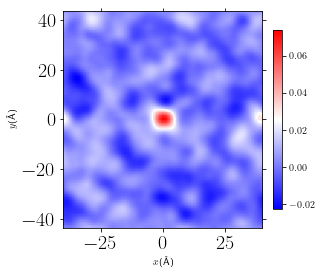

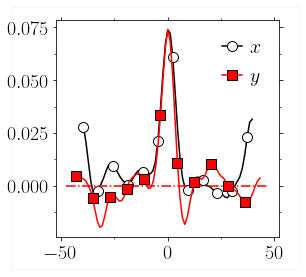

In [549]:
if ModuAnl and not RemoteMachine:

    cr_shift = np.fft.fftshift(cr)

    val = cr_shift[:,:,int(nz/2)]
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector )

    PltBitmap(val, 
                  xlabel = r'$x$(\r{A})', ylabel = r'$y$(\r{A})',
                  xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
                  zscore = None,
                  frac = 1.0, #--- plot a patch
                  title = 'crMapModu.png',
                  colorbar=True,
                )
    
    PltCrltnFunc(   cr, 
                     xv,yv,
                     fileName = 'crxyModu.png',
                     title = '', #r'$\gamma=%3.2f$'%(ebulk),
                     cTOL = 1.0e-2,
                     dpi = 150,
                     symmetry = False,
                    )

In [676]:
# def GetSroDensity(vor,box):
#         indices = GetFullIcosahedra( vor )

        
#         #--- output dump file (apply filtering), run ovitos
#         atomFiltrd = lp.Atoms(**pd.DataFrame(vor.__dict__)[indices].to_dict(orient='series')) #--- filter atoms
#         #
#         wdf = lp.WriteDumpFile(atomFiltrd,box) #--- need high-precision data
#         wdf.Write('junk.xyz')
#         #--- load to ovitos
#         rad1=0.0#AtomicRadius[1]
#         rad2=0.0#AtomicRadius[2]
#         rad3=0.0#AtomicRadius[3]
#         rad4=0.0#AtomicRadius[4]
#         rad5=0.0#AtomicRadius[5]
#         !ovitos OvitosCna.py 'junk.xyz' 'VoronoiFiltrd.xyz' 1 3 $rad1 $rad2 $rad3 $rad4 $rad5 
    
#         #--- read from ovito output
#         lmpDataFiltrd = lp.ReadDumpFile( 'VoronoiFiltrd.xyz' )
#         lmpDataFiltrd.GetCords( ncount = sys.maxsize )
#         #
#         vorFiltrd = lp.Atoms( **lmpDataFiltrd.coord_atoms_broken[0].to_dict(orient='series') )
#         x = 1.0/np.array(vorFiltrd.AtomicVolume)
        
#         return indices, x
    
# def sroDensityField( d2min, box, attr, vor,
#                     AtomicRadius,     
#                   Plot = True, PLOT_AVERAGE = True, title='scatterD2minRho.png',
#                  axisLabels = True,
#                  **kwargs,
               
#                 ):
        
#         icoFiltr, icoRho = GetSroDensity(vor,box) #--- icoFiltr: true if atom has icosahedral symmetry
        
#         #--- filter d2min        
#         y = lp.Atoms(**pd.DataFrame(d2min.__dict__)[icoFiltr].to_dict(orient='series'))
#         y = np.array(y[attr])

#         #--- filter atoms
#         assert icoRho.shape == y.shape
        
#         icoRho = icoRho[y>0.0]
#         y = y[y>0.0]
        
#         #--- cross crltn.
#         x = icoRho
#         if 'zscore' in kwargs and kwargs['zscore']:
#             x = Zscore(x)
#             y = Zscore(y)
        
#         crs[itimee] = CrssCrltn( np.log10(x.copy()), np.log10(y.copy()) )
        
#         if Plot:
#             fig = plt.figure(figsize=(4,4))
#             ax = fig.add_subplot(111)
#             #
#             ax.scatter(x,y,marker='x',alpha=0.08)
#             if PLOT_AVERAGE:
#                 xb, yb, err_x, err_y = GetBinnedAverage( x, y, nbins_per_decade = 8 )
#                 nevery = int(np.ceil(len(xb)/10.0))
#                 ax.errorbar(x=xb,y=yb,yerr=err_y,xerr=err_x,
#                     fmt='-o', markersize=8,color='red',markerfacecolor='white',markeredgewidth=0.7,
#                             markeredgecolor='red', markevery=nevery, errorevery=nevery,
#                     linewidth=.5, barsabove=None,capsize=5,capthick=1,elinewidth=1)

#             if 'xlim' in kwargs:
#                 ax.axis(kwargs['xlim'])
#     #        makeTickLabels(ax, x, y)
#             #
#             ax.set_yscale('log')
#             ax.set_xscale('log')
#             #
#             if axisLabels:
#                 ax.set_ylabel(r'$\mu$',fontsize=16)
#                 ax.set_xlabel(r'$\rho_{sro}$',fontsize=16)
#                 #
# #                ax.set_title(r'cxy=%3.2e'%crs[itimee],fontsize=16)
#                 #
#     #        ax.legend(frameon=False, fontsize=12)
#             #
#             ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
#             DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04,LOG_X=True,LOG_Y=True) 
#             #
#             plt.savefig(title,dpi=2*75,bbox_inches='tight',pad_inches=0.0)
#             plt.show()
        
#         return icoFiltr



# if DminAnalysis and VorAnl:    
    
#     #--- sro density based on voronoi volumes
#     icoFiltr = sroDensityField( 
#                         atomm, box0, 'C66',
#                         vor,
#                        AtomicRadius=AtomicRadius,
#                        Plot = True, 
#                        PLOT_AVERAGE = None,
#                        axisLabels = True,
#                        title = 'scatterMuSro.png', 
#                         zscore = None,
#                            )


## Distributions

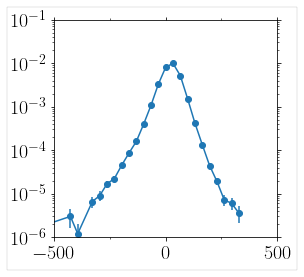

In [152]:
def Pdf( value,  label='',n_per_decade=32, Error = True, density=True, linscale=True,
             ):
    #--- size distribution
#    while True:
    hist, edges2, error = GetPDF( value, linscale = linscale, n_per_decade=n_per_decade,density=density)
    return hist, edges2, error 
    
    
if ModuAnl and not RemoteMachine:


    #
    hist, edges2, error =\
    Pdf( atomm.C66,#[atomm.C66>0.0], #(atomm.C66+atomm.C55+atomm.C44)/3.0, #-np.mean(value))/var[key], 
         label = 'Total',
        density=True,
        linscale=True,
        n_per_decade=32,
        )
#
    PltErr(edges2,hist, 
       yerr=error, 
#       attrs = attrs,
       Plot = True,
#       xstr=r'$\mu$(Gpa)',
#       ystr=r'Histogram',
        yscale='log',
        ylim = (1e-6,1e-1),
        xlim = (-500,500),
        DrawFrame=(0.21,0.09,0.15,0.06,0.1),
        title='pdfMu.%s.png'%itime,

      )

    mu=(atomm.C66).mean() #((atomm.C44+atomm.C55+atomm.C66)/3).mean()
    mu_std=(atomm.C66).std() #((atomm.C44+atomm.C55+atomm.C66)/3).std()
#    ax.set_title('mean=%2.1e, std=%2.1e'%(mu,mu_std), fontsize=16)
    #--- fit        
#    x=np.linspace(-4,4,1000)
#    y=np.exp(-0.5*x**2)/(2*np.pi)**.5
    #plt.plot(x,y,'.-',color='black',zorder=2)
    #
    #--- bulk strain
    ebulk = GetStrain(lmpData,itime,0)
    #
    np.savetxt('mu_mean_std.txt',np.c_[ebulk,mu,mu_std],header='strain\tmu\tmu_std')
    #
    np.savetxt('pdfMu.txt',np.c_[edges2,hist,error],header='mu\tp(mu)\terr')



### Plot multiple frames

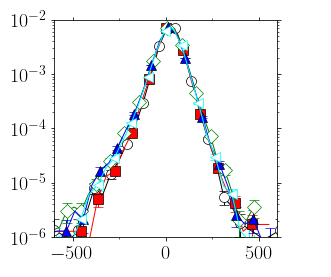

In [278]:
if not RemoteMachine:
    PlotPaperVersion(3,9,
                      glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                             4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[2],
#                         xlabel=r'$\mu$(Gpa)',
#                         ylabel=r'Histogram',
                        title='pdfMu.png',
                        yscale='log',
                        ylim = (1e-6,1e-2),
                        xlim = (-600,600),
                        PlotMean = False,
#                        legend = True,
                        DrawFrame=(0.21,0.21,0.15,0.06,0.001),
                     dpi=300,
                    )


### variance: multiple frames

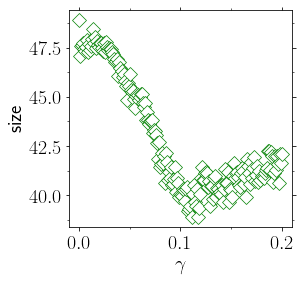

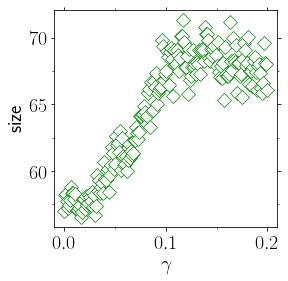

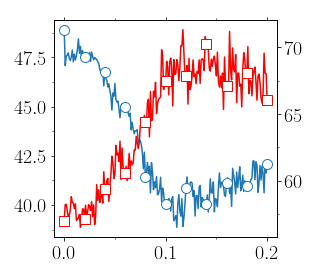

In [281]:
if not RemoteMachine:
    ax=PlotPaperVersion(3,10,
                      glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                             4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[2],
                        xlabel=r'$\gamma$',
                        ylabel=r'size',
#                        title='varMu.png',
#                        ylim=(35,70),
                        xlim=(-0.01,.21),
                        PlotMean = False,
#                        legend = True,
#                        yscale='log',
#                        borderwidth = 0.001,
                    )

    ax2=PlotPaperVersion(3,11,
                      glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                             4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[2],
                        xlabel=r'$\gamma$',
                        ylabel=r'size',
#                        title='varMu.png',
#                        ylim=(35,70),
                        xlim=(-0.01,.21),
                        PlotMean = False,
#                        legend = True,
#                        yscale='log',
#                        borderwidth = 0.001,
                    )

#--- fetch data
ydata = list(map(lambda x:ax.lines[x].get_ydata()[0],range(len(ax.lines))))
ydata2 = list(map(lambda x:ax2.lines[x].get_ydata()[0],range(len(ax2.lines))))
xdata = list(map(lambda x:ax.lines[x].get_xdata()[0],range(len(ax.lines))))


attrs={ 
#        'alpha':0.5,
        'fmt':'-o',
         'markersize':10,
         'color':'C0',
          'markerfacecolor':'white',
          'markeredgecolor':'C0',
          'markevery':int(len(xdata)/10.0),
#          'linewidth':3,

      }
#--- 1st plot 
ax=None
ax=PltErr(xdata,ydata, 
       yerr=None, 
       attrs = attrs,
       Plot = False,
       xstr='',#r'$\gamma$',
       ystr='',#r'$\sigma$(Gpa)',
      )
#

#--- 2nd plot
attrs={ 
#        'alpha':0.5,
        'fmt':'-s',
         'markersize':10,
         'color':'red',
          'markerfacecolor':'white',
          'markeredgecolor':'red',
          'markevery':int(len(xdata)/10.0),
#          'linewidth':3,

      }
kwargs = {
        'DrawFrame':(0.21,0.21,0.15,0.06,0.001),
       'xlim':(-0.01,0.21),
#       'ylim':(-0.5,2.5),
        'title':'varMu.png',
        'dpi':300,
         }

PltErr(xdata,ydata2,
       yerr=None, 
       attrs = attrs,
       Plot = True,
       ax = ax,
       twinx = True,
       **kwargs
      )    

### scale dependence
#### partition

In [527]:
if ModuAnl and not RemoteMachine:
    #--- length scales
    nn=[list(set(np.logspace(5,1,16,base=2,dtype=int))),
        list(set(np.logspace(6,1,32,base=2,dtype=int)))
       ][0]
    nn.sort()
    nn=nn[:-1][:-1]

    #clist, plist = GetPressComp( atoms,box, 20.0 )
    #--- partition
    rsub = [
            [10.0,15.0],
            list(map(lambda x: box0.CellVector[0,0]/x,nn))
           ][0]
    print('rsub=',rsub)
    rsub = rsub
    # #--- composition and pressure fluctuations
    # cplist = list(map(lambda x: GetPressComp( atoms,box, x ), rsub))



rsub= [39.9617, 26.641133333333332, 19.98085, 15.98468, 13.320566666666666, 11.41762857142857, 9.990425, 7.99234, 6.660283333333333, 5.328226666666667, 4.440188888888889, 3.632881818181818]


In [528]:
def plott(sarr,nx,ny,nz,box,zlin, title):
    value = np.c_[sarr].reshape(((ny,nx,nz)))
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector ) #--- box length
    #--- xy plane
    zz=0.5*(zlin[-1]+zlin[0])
    dz = zlin[-1]-zlin[-2]
    lz = zlin[-1]-zlin[0]
    nzz=int(nz*(zz-zlin[0])/lz)
    val = value[:,:,nzz].copy()
    #        pdb.set_trace()
    PltBitmap(val, 
              xlabel = r'$x$(\r{A})', ylabel = r'$y$(\r{A})',
              xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
              zscore = True,
              frac = 1.0, #--- plot a patch
              title = title,
              colorbar=True,
            )
    
    
def GetComp( atoms, atomf ):
    #--- different types
    types = set(atomf.type)
    c={}
    n = len(atoms.x)
    for typei in types:
        c[typei] = 1.0*np.sum(atoms.type == typei)/n

    return c


def GetPressComp( atoms,box, dmean, **kwargs ):
#    pdb.set_trace()
    #--- grid: tiling mapped box with original size
    (xlin, ylin, zlin), (xv, yv, zv) = lp.GetCubicGrid( box.CellOrigin, 
                                                     box.CellVector, 
                                                     dmean,
                                                     margin = 0.0 * dmean, odd = False )
    xi = np.array(list(zip(xv.flatten(), yv.flatten(), zv.flatten())))
    dvol = (xlin[1]-xlin[0])*(ylin[1]-ylin[0])*(zlin[1]-zlin[0])
    (ny,nx,nz) = xv.shape
    nx -= 1
    ny -= 1
    nz -= 1
    assert nx*ny*nz >= 8, 'decrease division length!'
    print(dmean,nx*ny*nz)
    #--- indices
    (xvi, yvi, zvi) = np.meshgrid(np.arange(0,nx),np.arange(0,ny),np.arange(0,nz))
    indices = np.array(list(zip(xvi.flatten(), yvi.flatten(), zvi.flatten()))) #--- shape:(ncel,3)
    indices = list(map(lambda x: tuple(x),indices))

    #--- partition box & assign index to each atom
    wrap = lp.Wrap(atoms,box)
    wrap.WrapCoord() #--- wrap inside
    wrap.Set(atoms)
    assert np.sum(wrap.isInside()) == len(atoms.x)
    wrap.GetDimensionlessCords()
    AtomCellId = (wrap.beta * np.array([nx,ny,nz])).astype(int)
    #--- store in a df
    df = pd.DataFrame(np.c_[pd.DataFrame(atoms.__dict__),AtomCellId],
                         columns=list(pd.DataFrame(atoms.__dict__).keys())+['ix','iy','iz'])
    df['ix']=df['ix'].astype(int)
    df['iy']=df['iy'].astype(int)
    df['iz']=df['iz'].astype(int)
#    display(df.head())

    #--- group & compute p and c
    d = df.groupby(by=['ix','iy','iz']).groups
#     print(len(d))
    if 'MODU' in kwargs and kwargs['MODU']:
        assert len(d) == nx*ny*nz, 'empty boxes!'
    #--- lambda function: compute p 
    f = lambda x: np.sum(np.sum(np.array(x.C66)*np.array(x.AtomicVolume)))*(1/dvol)
    vol=np.linalg.det(box.CellVector)
    #
    
    keys = indices if 'MODU' in kwargs and kwargs['MODU'] else d.keys()
    plist = list(map(lambda x:f(df.iloc[d[x]]),keys)) #--- len(plist) = ncell
    clist = list(map(lambda x:GetComp(df.iloc[d[x]],atoms),keys)) #--- clist[icell]={1:c1,2:c2, ...}
    
    #---
    if 'PLOT' in kwargs and kwargs['PLOT']:
        plott(plist,nx,ny,nz,box,zlin, 'pCG.png')
    
    
    #--- read file: elastic constants
    if 'MODU' in kwargs and kwargs['MODU']:
        fileName = kwargs['PATH']
        modu = pd.read_csv(fileName, sep=' ',header=0)
#        display(modu.head())
        if 'PLOT' in kwargs and kwargs['PLOT']:
            plott(modu['C66'],nx,ny,nz,box,zlin, 'muCG.png')

    #--- plot
    #--- reshape value


        
#        display(modu.head())
    if 'MODU' in kwargs and kwargs['MODU']:
        mlist = modu['C66'].to_list()
        return clist, plist, mlist
    else:
        return clist, plist

if ModuAnl and not RemoteMachine:
    cplist=list(map(lambda x: GetPressComp(atomm,box0,x), rsub))

    cplist = dict(zip(rsub,cplist)) #--- dict: key=length val=cp list


39.9617 8
26.641133333333332 27
19.98085 64
15.98468 125
13.320566666666666 216
11.41762857142857 343
9.990425 512
7.99234 1000
6.660283333333333 2028
5.328226666666667 3840
4.440188888888889 6498
3.632881818181818 11638


##### Plot

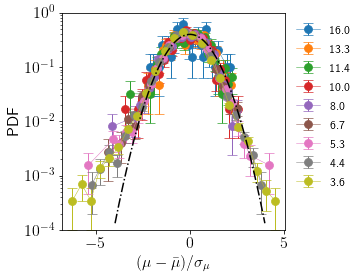

In [645]:
if ModuAnl and not RemoteMachine:
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_yscale('log')
    #ax.set_xscale('log')
    ax.set_ylim(1e-4,1)
    # ax.set_xlim(1e-2,1e4)
    #ax.set_xlabel(r'$(p-\bar{p})\times w^{3/2}$',fontsize=16)
    ax.set_xlabel([r'$(\mu-\bar{\mu})/\sigma_\mu$',r'$\mu$(Gpa)'][0],fontsize=16)
    ax.set_ylabel(r'PDF',fontsize=16)
    ax.tick_params(labelsize=16)
    #--- fit        
    x=np.linspace(-4,4,1000)
    y=np.exp(-0.5*x**2)/(2*np.pi)**.5
    #
    var={}
    mean={}
    kurt = {}
    for key in list(cplist.keys())[3:]:
        slist = cplist[key][1]
        #
        var[key]=np.std(slist)
        mean[key]=np.mean(slist)
        var[key]/=mean[key]
        kurt[key] = kurtosis(slist)
        #--- rescale
        slist -= np.mean(slist)
        slist /= np.std(slist)
        #
        Pdf( slist, 
         ax,
         label = '%3.1f'%key,
         Error = True,
       )

#    ax.set_title('mean=%2.1e, std=%2.1e'%(mu,mu_std), fontsize=16)
    plt.plot(x,y,'-.',color='black',zorder=2)
    ax.legend(frameon=False, fontsize=12,bbox_to_anchor=(1,1))
    plt.savefig('pdfMuRescaled.png',dpi=75,bbox_inches='tight')
    plt.show()
    #
    

#### variance

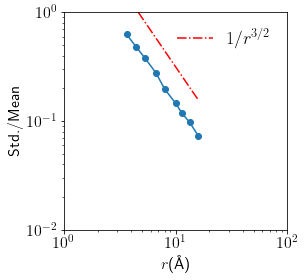

In [646]:
if ModuAnl and not RemoteMachine:
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel(r'$r$(\r{A})',fontsize=16)
    ax.set_ylabel(r'Std./Mean',fontsize=16)
    ax.tick_params(labelsize=16)
    ax.axis([1e0,1e2,1e-2,1e0])
    #ax.axis([1e0,1e3,1e-3,1e0])
    PutMinorTicks(ax, LOGY=True,LOGX=True)
    #
    ax.plot(list(var.keys()),list(map(var.get,var.keys())),'-o')
    #
    xx=np.array(list(var.keys()))
    xx.sort()
    ax.plot(xx,10/xx**1.5,'-.r',label=r'$1/r^{3/2}$')
    #
    ax.legend(frameon=False,fontsize=18)
    #
    plt.savefig('var.png',dpi=75,bbox_inches='tight')
    plt.show()

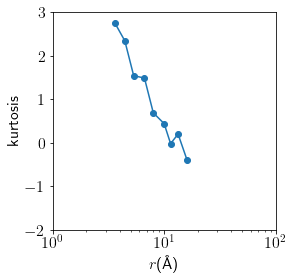

In [647]:
if ModuAnl and not RemoteMachine:
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    #ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel(r'$r$(\r{A})',fontsize=16)
    ax.set_ylabel(r'kurtosis',fontsize=16)
    ax.tick_params(labelsize=16)
    ax.axis([1e0,1e2,-2,3])
    #PutMinorTicks(ax, LOGY=True,LOGX=True)
    #
    ax.plot(list(kurt.keys()),list(map(kurt.get,kurt.keys())),'-o')
    #
    # xx=np.array(list(var.keys()))
    # xx.sort()
    # ax.plot(xx,10/xx**1.5,'-.r',label=r'$1/r^{3/2}$')
    #
    #ax.legend(frameon=False,fontsize=18)
    #
    plt.savefig('kurt.png',dpi=75,bbox_inches='tight')
    plt.show()

## cluster analysis

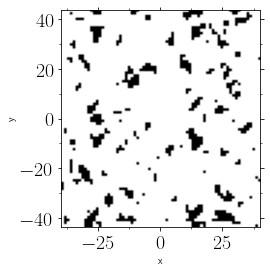

value.shape= (77, 69, 77)


In [480]:
def GetClsSize(mask):
    #--- clusters
    label_im, nb_labels = ndimage.label(mask)

    #--- biggest cluster
    #--- 
    df=pd.DataFrame(np.c_[label_im.flatten()],columns=['id'])
    sdict=df.groupby(by='id').groups
    df_cls = pd.DataFrame(np.c_[list(sdict.keys()),
                                list(map(lambda x:len(sdict[x]),sdict.keys()))
                               ],columns=['cls_id','size'])
    
    #--- sort based on size
    df_cls.sort_values('size',ascending=False,inplace=True)
    df_cls = df_cls.iloc[1:]
    #---
    return df_cls


if ModuAnl:# and not RemoteMachine:

     #--- bitmap
    (xlin, ylin, zlin), (xv, yv, zv), mu_intrp = Intrp(atomm, box0, 'C66',
                Plot = None,
#                title='mapCxyxy.png',
#                    cmap='Greys',
#                colorbar='True',
#                zscore=True,
               )
    mu=(atomm.C66).mean() 
    mu_std=(atomm.C66).std()

    value = PltBinary(
                        xlin,ylin,zlin, mu_intrp.C66,
                        box0,
                        0.0, #--- threshold
                        cmap='Greys',
                        title='ModuAnl/negative_mu.%s.png'%itime,
                        zscore=False,
                        #DrawFrame=(0.21,0.06,0.15,0.06,0.1),
                        xlabel = 'x', ylabel = 'y',
                        labels = True,
                     )
    print('value.shape=',value.shape)
    
    #--- threshold
    #--- cluster analysis
    mask = value<0.0
    #--- save
    np.save('ModuAnl/negative_mu',mask)
    
    
    (nx,ny,nz) = mask.shape
    nsize = nx*ny*nz
    p =  1.0*mask.sum()/nsize
    #
    df_cls = GetClsSize(mask)

    #--- <s>
    #ydata = list(map(lambda x:df_clstr[x]['size'].mean(),ratio.keys()))

    #--- <s^2>/<s>
    smean = (df_cls['size']**2).sum()/df_cls['size'].sum()

    #--- <s^2>^0.5 
    #ydata = list(map(lambda x:(df_clstr[x]['size']**2).sum()/df_clstr[x].size,ratio.keys()))
    #ydata = np.array(ydata)**0.5

    
    
    #---
    #--- plot biggest cluster
#     idd=df_cls['cls_id'].iloc[0]
#     shape = mask.shape #--- shape
#     n=mask.flatten().shape[0] #--- bitmap size
#     #--- plot
#     tmp = np.zeros(n)
#     tmp[sdict[idd]]=1
#     tmp = tmp.reshape(shape)
#     plt.imshow(tmp,cmap='Greys',origin='lower')
#     plt.savefig('negative_mu_biggest.png',bbox_inches='tight',pad_inches=0.0)
#     plt.show()

    #--- 95% quantile
    q=0.95
    nn=df_cls.shape[0]
    s95=df_cls['size'].iloc[int(nn*(1-q))]

    np.savetxt('ModuAnl/muClustersize_gamma.txt',
               np.c_[GetStrain(lmpData,itime,0),p,smean],
               header='gamma\tp\t<S>')
    

### cluster size dist.

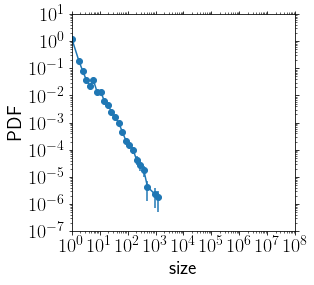

In [484]:
if ModuAnl:
    hist, edges, error = GetPDF( df_cls['size'].astype(float),n_per_decade=8)
    #
    PltErr(edges,hist, 
       yerr=error, 
       Plot = True,
        xstr=r'size',
        ystr=r'PDF',
        yscale='log',
        xscale='log',
         ylim = (1e-7,1e1),
         xlim = (1,1e8),
    #     DrawFrame=(0.21,0.09,0.15,0.06,0.1),
    #     title='pdfMu.%s.png'%itime,

      )
    np.savetxt('ModuAnl/ps.txt',
               np.c_[edges,hist,error],
               header='s\tp(s)\terror')


### movie: multiple strains

In [432]:
if ModuAnl and not RemoteMachine:
    #---
    Plot = False
    pathh='./ElasticityT300/Co5Cr2Fe40Mn27Ni26'
    masks = []
#    ratio = {}
#    df_clstr={}
    times = np.arange(0,201,1) #[70,100,130,160]: #np.arange(0,100,4)
    #---
    for itimee in times:
        mask0 = np.load('%s/itime%s/Run0/ModuAnl/negative_mu.npy'%(pathh,itimee))
#        print(mask0.shape)
        masks += [mask0]
        #
        mask_acc=~np.any(masks,axis=0) #np.any(masks,axis=0)
        #---
        #---
        #--- plot
        if Plot:
            junk = PltBinary(
                                xlin,ylin,zlin, mask_acc.flatten().astype(int),
                                box0,
                                0.5, #--- threshold
                                cmap='Greys',
                                title='ModuAnl/negative_mu.%s.png'%itimee,
                                zscore=False,
                                #DrawFrame=(0.21,0.06,0.15,0.06,0.1),
                                xlabel = 'x', ylabel = 'y',
                                labels = True,
                             )


### fraction p

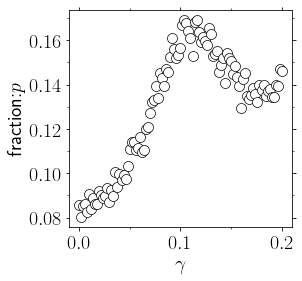

In [542]:
if ModuAnl and not RemoteMachine:
    PlotPaperVersion(4,13,
                      glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                             4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[0],
                        xlabel=r'$\gamma$',
                        ylabel=r'fraction:$p$',
                        title='fraction.png',
#                        ylim=(35,70),
                        xlim=(-0.01,.21),
#                        PlotMean = True,
#                        legend = True,
#                        yscale='log',
                    )

In [449]:
# slist = list(zip(ydata,list(ratio.keys())))
# slist.sort(reverse=True)
# timees = []
# pp=[]
# for q in [0.25,0.5,0.75,1.0]:
#     nn = int((1-q)*len(slist))
#     p=slist[nn][0]
#     itimee= slist[nn][1]
#     timees.append(itimee)
#     pp.append(p)
#     print(itimee,p)

# #--- 75%

500000 0.10414054231106744
1890000 0.1332042698502326
1490000 0.1435220153458437
1060000 0.16097736255839024


### other statistics

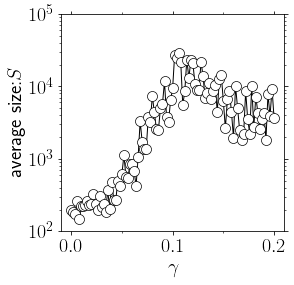

In [524]:
if ModuAnl and not RemoteMachine:
    
    PlotPaperVersion(4,14,
                  glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                         4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[0],
                    xlabel=r'$\gamma$',
                    ylabel=r'average size:$S$',
                    title='mean_size.png',
                    ylim=(1e2,1e5),
                    xlim=(-0.01,.21),
#                    PlotMean = True,
#                        legend = True,
                        yscale='log',
                )

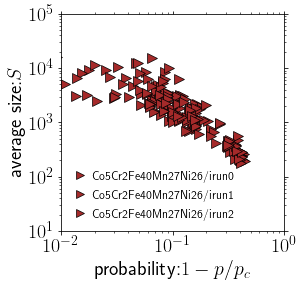

In [979]:
if ModuAnl and not RemoteMachine:
    indxxxx = 5
    ax_s = PlotPaperVersion(4,15,
                    glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                           4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx],
                   xlabel=r'probability:$1-p/p_c$',
                   ylabel=r'average size:$S$',
                   title='mean_sizeVsProb.%s.png'%indxxxx,
                   ylim=(1e1,1e5),
                    xlim=(1e-2,1),
#                    PlotMean = True,
                        legend = True,
                        yscale='log',
                        xscale='log',
                    verbose = False
                )

#### extract exponent

In [980]:

def func1(x,a,alpha):
     return a/x**alpha

def func0(x,a,beta, alpha,rc):
    return a/((x/rc)**beta+(x/rc)**alpha)

def func2(x,a, alpha,rc):
    return a/(1.0+(x/rc)**alpha)



def nonlinfit(x,y,func_indx,**kwargs):

    #--- initialize 
    if 'yerr' in kwargs: 
        ye=kwargs['yerr']
    #--- sort
    ss=list(zip(x,range(len(x))))
    ss.sort()
    indx=np.array([i[1] for i in ss])
    x=x[indx]
    y=y[indx]
    if 'yerr' in kwargs: 
        ye = ye[indx]
    #--- filter:
    y=y[x>0]
    if 'yerr' in kwargs: 
        ye=ye[x>0]
    x=x[x>0]
    #
    #--- fit
    if func_indx == 0:
        func = func0
        p0=(1.0e4,1.0,1.12,0.1) #a,beta, alpha,rc)
        bounds=((0.0,0.0,0.0,0.0), (np.infty,np.infty,np.infty,0.5))   
    elif func_indx == 1:
        func = func1
        p0=(1.0e4,1.12) #(a,alpha)
        bounds=((0.0,0.0), (np.infty,np.infty))
    elif func_indx == 2:
        func = func2
        p0=(1.0e4,1.12,0.1) #(a,alpha,rc)
        bounds=((0.0,0.0,0.0), (np.infty,np.infty,np.infty))
    popt, pcov = curve_fit(func, x, y, 
                       p0=p0,
                       bounds=bounds,    
                           ) #,sigma=ye) #, b)
    if func_indx == 1 and 'fit' in kwargs and kwargs['fit'] == 'linear' :
        popt = np.polyfit(np.log10(x),np.log10(y),deg=1)
#         print(popt)
        alpha = -popt[0]
        a = 10**popt[1]
        popt=[a,alpha]
    # #--- goodness of fit
    # n=len(x)
    # m=4 #--- number of coefficients
    # xsq = np.sum(((y-func(x,*popt0))/ye)**2)
    # pval=1-chi2.cdf(xsq,n-m)

    # if pval > pval_max:
    #     pval_max = pval
    
    return popt


def exponents(xdata,ydata):
    if len(ydata[~np.isnan(ydata)]) == 0:
        return np.nan, np.nan, np.nan
    #--- compute rc: the fit is a/((x/rc)**beta+(x/rc)**alpha)
    # xdata = np.array(ax_s.lines[0].get_xdata())
    # ydata = np.array(ax_s.lines[0].get_ydata())
    # popt0=\
    # nonlinfit( xdata,
    #            ydata,
    #           0,
    # #           yerr = None
    #          )
    # (a,beta,alpha,rc) = popt0

    #--- compute rc, fit: a/(1.0+(x/rc)**alpha)
    popt2=\
    nonlinfit( xdata,
               ydata,
              2,
    #           yerr = None
             )
    (a,alpha,rc) = popt2
#    print(alpha)

    #--- fit a/(1.0+(x/rc)**alpha) within the range x>rc
    #rc = 0.1 #!!!!1
    xdataf = xdata[xdata>rc]
    ydataf = ydata[xdata>rc]
    popt1=\
    nonlinfit( xdataf,
               ydataf,
              1,
              fit = 'linear',
    #           yerr = None
             )
    (a,alpha) = popt1
    return a, rc, alpha
#    print(alpha)



if ModuAnl and not RemoteMachine:
    irun = 1
    xdata = np.array(ax_s.lines[irun].get_xdata())
    ydata = np.array(ax_s.lines[irun].get_ydata())
    a, rc, alpha = exponents(xdata,ydata)


In [981]:
#--- different realizations

popt = np.c_[list(map(lambda x:exponents(np.array(ax_s.lines[x].get_xdata()),
                            np.array(ax_s.lines[x].get_ydata())),
         range(len(ax_s.lines))))]
print('popt=',popt)

popt= [[4.88644474e+01 9.08992213e-02 1.85399188e+00]
 [8.24545858e+01 8.16445660e-02 1.33713907e+00]
 [           nan            nan            nan]]


#### Plot

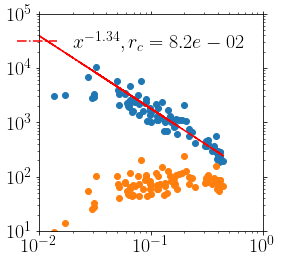

In [982]:
if ModuAnl and not RemoteMachine:
    
    #--- plot scatter
    ax = PltErr(xdata,ydata, 
       yerr=None, 
       Plot = False,
        attrs={'fmt':'.', 'markersize':'12'},
          )
    
    

    #--- plot fit
    ax=PltErr(xdata,func1(xdata,a,alpha), 
       yerr=None, 
       Plot = False,
        attrs={'fmt':'-.',
               'color':'red',
                'label':r'$x^{-%3.2f},r_c=%2.1e$'%(alpha,rc),

              },
        ax=ax,
            legend=True,
          )

    
    
    #--- rescale
    PltErr(xdata,1e0*ydata*xdata**alpha, 
       yerr=None, 
       Plot = True,
        xstr=r'size',
        ystr=r'PDF',
        yscale='log',
        xscale='log',
        ax=ax,
       ylim=(1e1,1e5),
        xlim=(1e-2,1),
        attrs={'fmt':'.', 'markersize':'12'},
    #     DrawFrame=(0.21,0.09,0.15,0.06,0.1),
    #     title='pdfMu.%s.png'%itime,
          )

#### Print

In [983]:
def Printvar(pathh,filee,popt,nrun):
    for irun in range(nrun):
        os.system('mkdir -p %s/Run%s'%(pathh,irun))
        x = popt[irun,2]
        np.savetxt('%s/Run%s/%s'%(pathh,irun,filee),np.c_[0,x],header='line\talpha')

    
glass = {0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
         4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[indxxxx]
Printvar(
          'D2minAnalysisT300/%s'%(glass),
          'alpha.txt',
           popt,
           nrun = 3
        )


#### scatter plot

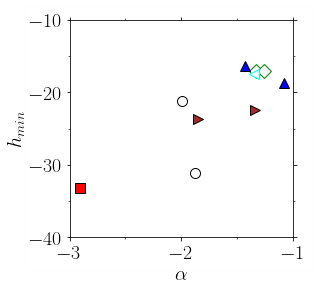

In [984]:
if not RemoteMachine:
    PlotPaperVersionScatter( 2, #--- path:
                            xindx=7, colx = 1, #--- x: delta (2nd column)
                            yindx=5, coly = 1, #--- y: hmin( 2nd column)
                           xlabel=r'$\alpha$',
                           ylabel=r'$h_{min}$',
                        title='SoftModuAndalpha.png',
                        xlim=(-3,-1),
                        ylim=(-40.0,-10.0),
#                            legend = True,
                        verbose = False,
                    )

### 95 percent quantile

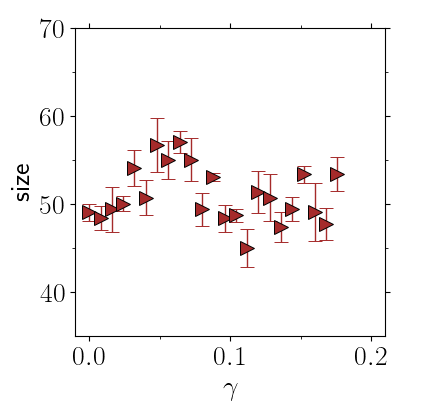

In [517]:
if ModuAnl and not RemoteMachine:
    PlotPaperVersion(3,8,
                      glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                             4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[5],
                        xlabel=r'$\gamma$',
                        ylabel=r'size',
                        title='muClustersize_gamma5.png',
                        ylim=(35,70),
                        xlim=(-0.01,.21),
                        PlotMean = True,
#                        legend = True,
#                        yscale='log',
                        borderwidth = 0.001,
                    )

#### different strains

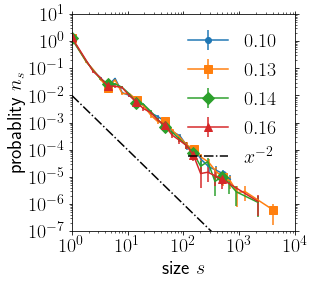

In [478]:
if ModuAnl and not RemoteMachine:
    ax=None
    markers=['o','s','D','^','<','>','v']

    for itimee, indx, marker in zip(timees,range(len(times)),markers): #np.arange(0,101,10)*10000:
        df_cls = df_clstr[itimee]
        hist, edges, error = GetPDF( df_cls['size'].astype(float),n_per_decade=8)
        #
        if indx == 0:
            ax = PltErr(edges,hist, 
               yerr=error, 
               Plot = False,
                xstr=r'size $s$',
                ystr=r'probablity $n_s$',
                attrs={'label':'$%3.2f$'%(pp[indx]),
                       'fmt':'-o',
                       'marker':marker,
                       'markersize':6,
                       'markevery':4,
                      },
                    legend=True,

                       )
        else:
            PltErr(edges,hist, 
                yerr=error, 
                Plot = False,
                yscale='log',
                xscale='log',
                ylim = (1e-7,1e1),
                xlim = (1,1e4),
                ax=ax,
                attrs={'label':'$%3.2f$'%(pp[indx]),
                       'fmt':'-',
                       'marker':marker,
                       'markersize':8,
                       'markevery':4,
                      },
                legend=True,
            #     DrawFrame=(0.21,0.09,0.15,0.06,0.1),
#                 title='ps.png',
                       )
            
pexp = -2
pref=1e-2
PltErr(edges,pref*edges**pexp, 
    yerr=None, 
    Plot = True,
    yscale='log',
    xscale='log',
    ylim = (1e-7,1e1),
    xlim = (1,1e4),
    ax=ax,
    attrs={'label':'$x^{%s}$'%(pexp),
           'fmt':'-.',
           'color':'black',
          },
    legend=True,
#     DrawFrame=(0.21,0.09,0.15,0.06,0.1),
                 title='ps.png',
           )


#### Plot

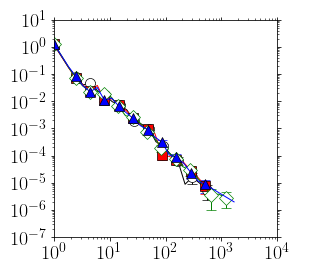

In [303]:
if not RemoteMachine:
    PlotPaperVersion(3,12,
                      glass={0:'FeNi',1:'CoNiFe',2:'CoNiCrFe',3:'CoCrFeMn',
                             4:'CoNiCrFeMn',5:'Co5Cr2Fe40Mn27Ni26'}[2],
#                         xlabel=r'$\mu$(Gpa)',
#                         ylabel=r'Histogram',
                        title='pdfClsSize.png',
                        yscale='log',
                        xscale='log',
                        ylim = (1e-7,1e1),
                        xlim = (1,1e4),
                        PlotMean = False,
#                        legend = True,
                        DrawFrame=(0.21,0.21,0.15,0.06,0.001),
                         dpi=300,
                    )


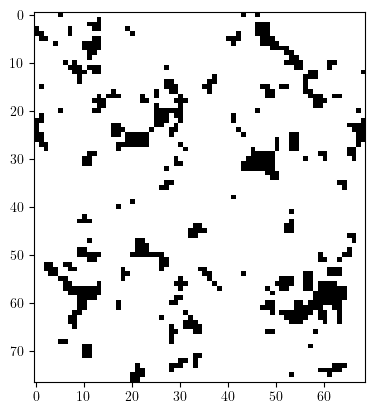

gamma= 0.2


In [347]:

#     #--- reshape value
# nx,ny,nz = len(xlin), len(ylin),len(zlin) 
# value = np.c_[d2intrp.C66].reshape(((ny,nx,nz)))

# #--- xy plane
# #--- 2d slice
# nzl=[0]
# val = Get2dSlice( value, zlin, 
#                     zlin[-1], nzll=nzl  )
# mask = val<0
# plt.imshow(mask,cmap='Greys')
# plt.show()
# # #--- threshold
# #--- cluster analysis
# label_im, nb_labels = ndimage.label(mask)

# print('gamma=',GetStrain(lmpData,itime,0))
# # # 			#--- strain rate
# # d={} #---intensity
# # xcont={} #---area
# # rcx={};rcy={};rsq={};
# # Ixx={};Iyy={};Ixy={} #--- moment of inertia
# # for i,irow in zip(label_im,xrange(sys.maxint)):
# #     for j, jcol in zip(i,xrange(sys.maxint)):
# #         if j in d:
# #             d[j]+=mask[irow,jcol]*valmx[irow,jcol] #--- sum_ep
# #             xcont[j]+=1
# #             rcx[j]+=jcol #--- centroid
# #             rcy[j]+=irow
# #         else:
# #             d[j]=mask[irow,jcol]*valmx[irow,jcol]
# #             xcont[j]=1
# #             rcx[j]=jcol #--- centroid
# #             rcy[j]=irow
# # for j in rcx: #--- centroid
# #     rcx[j]/=1.0*xcont[j]	
# #     rcy[j]/=1.0*xcont[j]
# # for i,irow in zip(label_im,xrange(sys.maxint)): #--- radius of gyr.
# #     for j, jcol in zip(i,xrange(sys.maxint)):
# #         if j in rsq:
# #             rsq[j]+=(jcol-rcx[j])**2*dxsq+(irow-rcy[j])**2*dysq
# #             Ixx[j]+=(jcol-rcx[j])**2*dxsq #--- sum (x_i-<x>)^2
# #             Iyy[j]+=(irow-rcy[j])**2*dysq
# #             Ixy[j]+=(jcol-rcx[j])*(irow-rcy[j])*DXY #--- sum (x_i-<x>)*(y_i-<y>)

# #         else:
# #             rsq[j]=(jcol-rcx[j])**2*dxsq+(irow-rcy[j])**2*dysq
# #             Ixx[j]=(jcol-rcx[j])**2*dxsq
# #             Iyy[j]=(irow-rcy[j])**2*dysq
# #             Ixy[j]=(jcol-rcx[j])*(irow-rcy[j])*DXY
# # for j in rsq: #--- normalize
# #     rsq[j]/=xcont[j]	
# #     Ixx[j]/=xcont[j]	
# #     Iyy[j]/=xcont[j]	
# #     Ixy[j]/=xcont[j]	

# # #--- find eigendirections of I (l1,l2) l2>l1
# # T=[[0.0,0.0],[0.0,0.0]]
# # l1={};l2={};theta={};
# # for items in Ixx:
# #     R = (0.25 * ( Ixx[items]-Iyy[items])**2+ Ixy[items]*Ixy[items])**0.5 #--- naisotropy
# #     lc=0.5*(Ixx[items]+Iyy[items]) #--- 1st invariant
# #     l2[items]=R+lc #--- eigenvalues
# #     l1[items]=lc-R
# #     assert l1[items] >= 0.0 and l2[items] >= 0.0 
# #     theta[items]=atan2(Ixy[items],0.5*( Ixx[items]-Iyy[items]))*0.5 #--- eigen directions
# #     n=[cos(theta[items]),sin(theta[items])]
# #     t=[-sin(theta[items]),cos(theta[items])]
# #     #--- sanity check 
# #     T0=[[Ixx[items],Ixy[items]],[Ixy[items],Iyy[items]]]
# #     x=0.0
# #     for i in xrange(2):
# #         for j in xrange(2):
# #             T[i][j]=l2[items]*n[i]*n[j]+l1[items]*t[i]*t[j]
# #             x+=(T[i][j]-T0[i][j])**2
# #     assert x < 1.0e-10, '|T-T0|=%s'%x
# # #				print [T[0][0],T[0][1],T[1][1]], [Ixx[items],Ixy[items],Iyy[items]]

# Local Order Analysis

In [362]:
if CommonNeighAnl and not Ovitos:
    if not TimeSeries:
        #--- extract atom and box properties
        cna = lp.Atoms( **lmpCna.coord_atoms_broken[itime].to_dict(orient='list') )
    else:
        cna = {}
        for iitime in lmpCna.coord_atoms_broken:
            cna[iitime] = lp.Atoms( **lmpCna.coord_atoms_broken[iitime].to_dict(orient='list') )

if CommonNeighAnl and Ovitos:            
    !ovitos OvitosCna.py $fileName Cna.xyz $nevery 0

InputFile= /Users/Home/Desktop/Tmp/txt/FeNi_glass.dump
num_frames= 201


In [364]:
#--- read from d2min.xyz
if CommonNeighAnl and Ovitos:
    lmpData = lp.ReadDumpFile( 'Cna.xyz' )
    lmpData.GetCords( ncount = sys.maxsize)

## Histograms

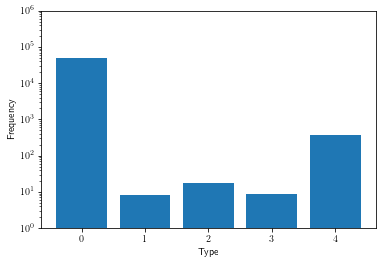

In [365]:
if CommonNeighAnl and not TimeSeries:
    cna = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='list') )
    #
    plt.yscale('log')
    plt.ylim(1,1e6)
    plt.xlabel('Type')
    plt.ylabel('Frequency')
    #
    x, y = np.unique(pd.DataFrame(cna.__dict__)['StructureType'], return_counts=True) #bug !!! len(y)!=5
    #
    count=np.zeros(5,dtype=int)
    for typee in x:
        count[int(typee)] = y[int(typee)]
    #
    plt.bar(x, count)
    #
    plt.show()
    #--- strain
    dx=box.CellVector[0,1]-box0.CellVector[0,1]
    l1=box.CellVector[1,1]
    ebulk = np.array([dx/l1])

    #--- save
    np.savetxt('StructureTypeCounts.txt',np.concatenate([ebulk,count]).reshape((1,6)),
               header='Strain,n0,n1,n2,n3,n4', fmt='%s')


## output timeseries

In [378]:
if CommonNeighAnl:
    #
    times = list(lmpData.coord_atoms_broken.keys())
    times.sort()
    ntime = len(times)
    ebulk = np.zeros( ntime )
    Count = np.zeros(ntime*5).reshape((ntime,5))
    #
    for iitime, indxx in zip(times,range(ntime)):
        cna = lp.Atoms( **lmpData.coord_atoms_broken[iitime].to_dict(orient='list') )
        #
        x, y = np.unique(pd.DataFrame(cna.__dict__)['StructureType'], return_counts=True) #bug !!! len(y)!=5
        #
        for typee, count in zip(x,y):
            typee = int(typee)
            count = int(count)
            Count[indxx,typee] = count
        #
        #--- strain
        if indxx == 0:
            box0 = lp.Box( BoxBounds = lmpData.BoxBounds[0] )
            box0.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))

        box = lp.Box( BoxBounds = lmpData.BoxBounds[iitime] )
        box.BasisVectors( AddMissing = np.array([0.0,0.0,0.0] ))
        #
        #--- volume
        CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector )
        volume = np.linalg.det( CellVectorOrtho )
        #--- bulk strain
        dx=box.CellVector[0,1]-box0.CellVector[0,1]
        l1=box.CellVector[1,1]
        ebulk[indxx] = dx/l1

    #--- save
    np.savetxt('StructureTypeCounts.txt',np.c_[ebulk,Count].reshape((ntime,6)),
               header='Strain,n0,n1,n2,n3,n4', fmt='%s')


### Multiple Frames

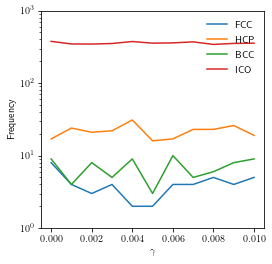

In [379]:
if CommonNeighAnl:
    path = '.'
    sarr = np.loadtxt('%s/StructureTypeCounts.txt'%path)

    #
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_xlabel('$\gamma$')
    ax.set_ylabel('Frequency')
    ax.set_ylim(1e0,1e3)
    ax.set_yscale('log')
    #
    #ax.plot(sarr[:,0],sarr[:,1],label='Other')
    ax.plot(sarr[:,0],sarr[:,2],label='FCC')
    ax.plot(sarr[:,0],sarr[:,3],label='HCP')
    ax.plot(sarr[:,0],sarr[:,4],label='BCC')
    ax.plot(sarr[:,0],sarr[:,5],label='ICO')
    #
    ax.legend(frameon=False)
    plt.savefig('StructureTypeGamma.png',dpi=75,bbox_inches='tight')
    plt.show()

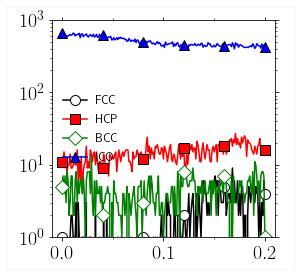

In [389]:
if not RemoteMachine:
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
    #
    ax.set_ylim(1e0,1e3)
    
    ax.set_yscale('log')
    #
#    ax.set_xlabel(r'$\gamma$',fontsize=20)
#    ax.set_ylabel(r'$\sigma/\mu$',fontsize=20)
    #
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    #--- add major yticks
    ymin=np.ceil(np.log10(ax.axis()[2]))
    ymax=np.floor(np.log10(ax.axis()[3]))
    nbin = ymax - ymin
    ax.set_yticks(np.logspace(ymin,ymax,int(nbin)+1))
    #
    #--- put minor bins y
    locmin = matplotlib.ticker.LogLocator(base=10.0,subs=(0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1),numticks=12)
    ax.yaxis.set_minor_locator(locmin)
    ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
    #
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #ax.set_title()
    #
    sarr  = np.loadtxt('CnaCo5Cr5Fe40Mn27Ni26/Run0/StructureTypeCounts.txt')
    for GlassType, marker, color, fillstyle, indx in list(zip( [ 
#                                        'Other',
                                        'FCC','HCP','BCC','ICO'
                                        ],markers, colors, fillstyles, range(10) )):

        #--- fliter
        ydata = sarr[:,indx+2] #--- first 2nd col is stress drop
        xdata = sarr[:,0] #--- 2nd and 3rd cols are widths
    #
        ax.plot(xdata,ydata,
                linestyle='-',
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                markeredgecolor='black' if not fillstyle else None,
                markevery=int(len(xdata)/5),
                label = '%s'%GlassType)

    #
    ax.legend(frameon=False, fontsize=12)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04,LOG_Y=True)
    #
    plt.savefig('CrysFracGood.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

## Crltns with d2min

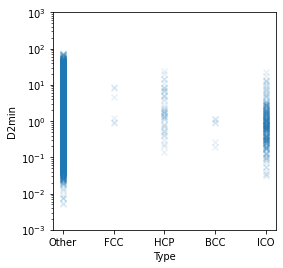

In [124]:
if CommonNeighAnl and DminAnalysis:
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)
    ax.set_xlabel('Type')
    ax.set_ylabel('D2min')
    ax.set_ylim(1e-3,1e3)
    ax.xaxis.set_ticks([0,1,2,3,4])
    ax.xaxis.set_ticklabels(['Other','FCC','HCP','BCC','ICO'])
    
    ax.set_yscale('log')
    ax.scatter(pd.DataFrame(cna.__dict__).sort_values(by='id')['StructureType'],
                pd.DataFrame(d2min.__dict__).sort_values(by='id')['d2min'],
                alpha = 0.1,
                marker='x'
               )

# Displacement Gradients

## Interpolate Displacements
### cubic grid

In [91]:
if StrnAnalysis:
    #--- mean dist between atoms 
    natoms = len( atoms0.x ) 
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box0.CellVector )
    volume = np.linalg.det( CellVectorOrtho )
    dmean = 0.5*( volume / natoms ) ** (1.0/3.0) 

    #--- grid tiling mapped box with original size
    #--- values are interpolated onto this grid
    (xlin, ylin, zlin), (xv, yv, zv) = lp.GetCubicGrid( box0.CellOrigin, 
                                                     box0.CellVector, 
                                                     dmean,
                                                     margin = 0.0 * dmean )
    xi = np.array(list(zip(xv.flatten(), yv.flatten(), zv.flatten())))


### center box + margin

In [92]:
if StrnAnalysis:
    #--- get a chunk of the full copy
    cptmp = lp.Copy(atoms0, box0) #--- important: must be reference frame!!
    indices = cptmp.isInsideExpanded( np.c_[xatoms0.xm,xatoms0.ym,xatoms0.zm], 
                                      epsilon = 0.2, mode = 'isotropic' )

    points = np.c_[uatoms.xm,uatoms.ym,uatoms.zm][indices] #--- unstructured points
    values = np.c_[uatoms.dx,uatoms.dy,uatoms.dz][indices] #--- corresponding values

    grid_z = scp_int.griddata(points, values, xi, method='linear')
    assert not np.any(np.isnan(grid_z.flatten())), 'increase ev!'

    #--- make an object
    uintrp = lp.Atoms(**pd.DataFrame(np.c_[xi,grid_z],columns=['x','y','z','dx','dy','dz']).to_dict(orient='list'))



### Print

In [289]:
if StrnAnalysis:

    file_name = 'uintrp.xyz'
    try:
        os.system('rm %s'%file_name)
    except:
        pass

    #for itime in df_intrp:
    PrintOvito( pd.DataFrame( uintrp.__dict__ ), 
                    open( file_name,'a'), 
                    footer = 'ITIME=%s'%itime,
                    attr_list=['x','y','z','dx','dy','dz'] )


## Strain tensor

In [93]:
if StrnAnalysis:
    csn = lp.ComputeStrn( uintrp, box0 )
    csn.Reshape( xlin, ylin, zlin )
    csn.Gradient()
    csn.SetStrn('exy')
    Exy = csn.Get(attrs = ['x','y','z','exy'])


### imshow

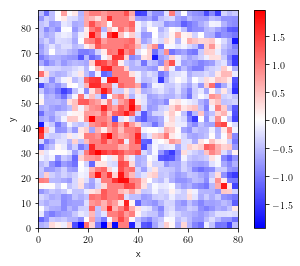

In [96]:
def FilterMatrix( CellVector, CellOrigin,
                  xlin, ylin, zlin,
                  xv, yv, zv ,
                   value
                ):
    #--- xlims of the original box
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( CellVector )
    margin = 0.0    
    (xlo,xhi)=( CellOrigin[0] - margin, CellOrigin[0] + VectorNorm[ 0 ] + margin)
    (ylo,yhi)=( CellOrigin[1] - margin, CellOrigin[1] + VectorNorm[ 1 ] + margin)
    (zlo,zhi)=(CellOrigin[2] - margin, CellOrigin[2] + VectorNorm[ 2 ] + margin )

    #--- grid dimension tiling the original box
    indices = np.all([xlin>=xlo, xlin<xhi],axis=0)
    nx = xlin[indices].shape[0]
    indices = np.all([ylin>=ylo, ylin<yhi],axis=0)
    ny = ylin[indices].shape[0]
    indices = np.all([zlin>=zlo, zlin<zhi],axis=0)
    nz = zlin[indices].shape[0]

    #--- filter matrices
    indices = np.all([xv>=xlo,xv<xhi, yv>=ylo,yv<yhi, zv>=zlo,zv<zhi ],axis=0)
    vf_flatten = value[indices] #--- filter extended grid
    assert vf_flatten.shape[0] == nx*ny*nz, '%s != %s'%(vf_flatten.shape[0], nx*ny*nz)
    vf = vf_flatten.reshape((ny,nx,nz))
    return vf



if StrnAnalysis:

    #itime = np.max(dfD2min_intrp.keys())
    #--- reshape value
    nx,ny,nz = len(xlin), len(ylin),len(zlin) 
    value = np.c_[Exy.exy].reshape(((ny,nx,nz)))
    #value = np.c_[dfD2min_intrp[itime]['d2min']].reshape(((ny,nx,nz)))

    # lx=xlin[-1]-xlin[0]
    # ly=ylin[-1]-ylin[0]
    # #value = np.sin(2*pi*np.c_[(df_intrp[itime]['x']-xlin[0])]/lx)
    # value = np.c_[df_intrp[itime]['ux']]
    # value = value.reshape(((ny,nx,nz)))
    #print value.shape

    #--- filter value
    # value = FilterMatrix( box0.CellVector, box0.CellOrigin,
    #                   (xlin, ylin, zlin),
    #                   (xv, yv, zv ),
    #                    value )
    #print value.shape
    #print vf.shape

    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector ) #--- box length
    #--- xy plane
    val = value[:,:,-1].copy()
    #val = value[:,:,nz/2].copy()
    #print val.shape

    PltBitmap(val, 
              xlabel = 'x', ylabel = 'y',
              xlim=VectorNorm[0]*np.array([0.0,1.0]),ylim=VectorNorm[1]*np.array([0.0,1.0]),
              zscore = True,
              frac = 1.0, #--- plot a patch
               title = 'strain.png',
           )

In [89]:
# fig=plt.figure(figsize=(4,4))
# ax=fig.add_subplot(111)
# ax2=ax.twinx()

# # ax.set_xlim(min(xlin),max(xlin))
# # ax2.set_xlim(min(xlin),max(xlin))
# # ax.set_ylim(-1,1)
# # ax2.set_ylim(-1,1)

# f = val[:,0]
# df=val0[:,0]

# dx=xlin[1]-xlin[0]
# ax.plot(ylin, f,'-o',label='uy')
# #ax2.plot(ylin, np.gradient(f,xlin,edge_order=2)/(2*pi/lx),'-s',color='red',label='duydx')
# ax2.plot(ylin, np.gradient(f,ylin,edge_order=2),'-s',color='red',label='duydx')
# #ax2.plot(xlin[:-1], np.diff(f)/dx/(2*pi/lx),'-s',color='red',label='duydx')
# #ax2.plot(ylin,df/(2*pi/lx),'-x',color='black',label='duydxFFT')
# ax2.plot(ylin,df,'-x',color='black',label='duydxFFT')


# ax2.legend()
# plt.show()

In [90]:
# itime = np.max(Strain.keys())
# nx,ny,nz = len(xlin), len(ylin),len(zlin) 

# # value = np.sin(2*pi*np.c_[df_intrp[itime]['x']]/nx)
# # value = value.reshape(((ny,nx,nz)))
# #dvalux = GetDerivX( value,lx )

# #value = np.c_[df_intrp[itime]['ux']].reshape(((ny,nx,nz)))
# dvaluy = GetDerivY( value,ly )

# exy=dvaluy
# #--- xy plane
# value0 = exy[:,:,-1].copy()

# PltBitmap(value0, 
#           xlabel = 'x', ylabel = 'y',
#           xlim=VectorNorm[0]*np.array([0.0,1.0]),ylim=VectorNorm[1]*np.array([0.0,1.0]),
#           zscore = None,
#           frac = 1.0, #--- plot a patch
#         )

### Print

In [30]:
if StrnAnalysis:

    file_name = 'strain.xyz'
    try:
        os.system('rm %s'%file_name)
    except:
        pass

    # times = Strain.keys()
    # times.sort()
    #--- bulk strain
    dx=box.CellVector[0,1]-box.CellVector[0,1]
    l1=box.CellVector[1,1]
    ebulk = dx/l1


    PrintOvito( pd.DataFrame(Exy.__dict__), 
                    open( file_name,'a'), 
                    footer = 'epsilon=%2.1e'%(2*ebulk),
                    attr_list=['x','y','z','exy'] )
    

### Auto-Correlations

In [97]:
if StrnAnalysis:

    #Crltn = {}
    (nx,ny,nz) = len(xlin), len(ylin),len(zlin) 
    #
    value = np.c_[Exy.exy].reshape((ny,nx,nz))
    #    value = np.c_[dfD2min_intrp[itime]['d2min']].reshape(((ny,nx,nz)))
    #    value = np.c_[df_intrp[itime]['ux']].reshape(((ny,nx,nz)))

    #--- shuffle
    #     ( nx, ny, nz ) =  value.shape
    #     slist = value.flatten()
    #     np.random.shuffle(slist)
    #     value=slist.reshape((nx, ny, nz))    
        #
    #--- filter value
    #     value = FilterMatrix( CellVector[0], CellOrigin[0],
    #                   (xlin, ylin, zlin),
    #                   (xv, yv, zv ),
    #                    value )

    Crltn = GetAutoCorrelation( value )


### Print

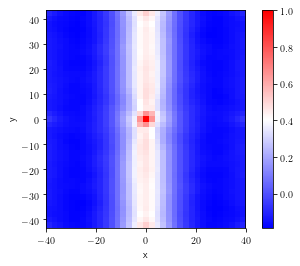

In [99]:
if StrnAnalysis:

    # for itime in Crltn:
    #     print 'itime=',itime
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector ) #--- box length
        #    
    crltn = Crltn #[ itime ]
    #--- xy plane
    val = crltn[:,:,0].copy()
    PltCrltn( val, 
              xlabel = '', ylabel = '',
              xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
              frac = 0.5, #--- plot a patch
              zscore = False,
              fileName = 'cxy_strain.%s.png'%itime,
              dpi = 60
            )
        # #--- zx plane
        # val = crltn[0,:,:].copy()
        # PltCrltn( val, 
        #           xlabel = 'z', ylabel = 'x',
        #           xlim=VectorNorm[2]*np.array([-0.5,0.5]),ylim=VectorNorm[0]*np.array([-0.5,0.5]),
        #           frac = 1.0, #--- plot a patch
        #           zscore = False,
        #         )
        # #--- zy plane
        # val = crltn[:,0,:].copy()
        # PltCrltn( val, 
        #           xlabel = 'z', ylabel = 'y',
        #           xlim=VectorNorm[2]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
        #           frac = 1.0, #--- plot a patch
        #           zscore = False,
        #         )



### Crltn Length

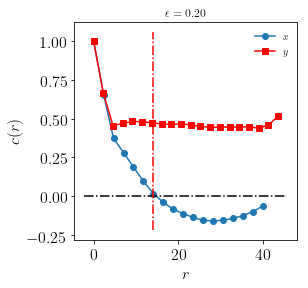

(14.108201970564707, nan)

In [107]:
if StrnAnalysis:

    # for itime in Crltn:
    #     print 'itime=',itime
    #--- bulk strain
    dx=box.CellVector[0,1]-box0.CellVector[0,1]
    l1=box.CellVector[1,1]
    ebulk = dx/l1
    #---
    (xc, yc), (xdata0,ydata0), (xdata,ydata)=\
    PltCrltnFunc( Crltn, 
                 xv,yv,
                 fileName = 'cr_strain.%s.png'%itime,
                 title = r'$\epsilon=%3.2f$'%(2*ebulk),
                 cTOL = 8.0e-2,
                 dpi = 60,
                )
    np.savetxt('Cx.txt',np.c_[xdata0.real,ydata0.real],header='x\tc(x)')
    np.savetxt('Cy.txt',np.c_[xdata.real,ydata.real],header='y\tc(y)')

#### multiple plots

In [109]:
# #--- extract length
# ebulk = []
# Xc = []
# Yc = []
# keys = Crltn.keys()
# keys.sort()
# for itime in keys:
#     #--- bulk strain
#     dx=CellVector[ itime ][0,1]-CellVector[ 0 ][0,1]
#     l1=CellVector[ itime ][1,1]
#     ebulk += [0.5*dx/l1]
    
#     xc, yc = PltCrltnFunc( Crltn[ itime ], 
#                           (xv,yv),
#                           cTOL = 4e-2,
#                           PLOT = None,
#                          )
#     Xc += [xc]
#     Yc += [yc]

# #--- plot
# fig = plt.figure( figsize = (4,4))
# ax = fig.add_subplot(111)
# xstr = r'$\epsilon$'
# ystr = r'$r_c$'
# ax.set_xlabel(xstr,fontsize=16)
# #ax.set_ylabel(ystr,fontsize=16)
# ax.tick_params(labelsize=16)
# #
# ax.plot( 2*np.array(ebulk), Xc,'-o', color='C0', label = r'$x_c$')
# ax.plot( 2*np.array(ebulk), Yc,'-s', color='red', label = r'$y_c$')
# ax.legend(frameon=False)
# plt.savefig('rc.png',dpi=75,bbox_inches='tight')
# plt.show()


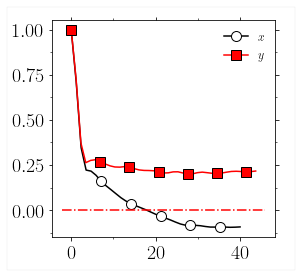

In [201]:
if not RemoteMachine:
    #
    matplotlib.rcParams['text.usetex'] = True #--- comment tex stuff!
    #
    nfreq = 5
    #
    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
    #
    fig = plt.figure( figsize = (4,4))
    ax = fig.add_subplot(111)
#     ax.set_xlabel(r'$\gamma$',fontsize=20)
#     ax.set_ylabel(r'$\sigma/\mu$',fontsize=20)
    ax.xaxis.set_minor_locator(AutoMinorLocator(2))
    ax.yaxis.set_minor_locator(AutoMinorLocator(2))
    ax.tick_params(labelsize=20,which='both',axis='both', top=True, right=True)
    #ax.set_title()
    #
    for GlassType, marker, color, fillstyle in list(zip( [ 
                                         'x','y'
#                                           'CoNiFe',
#                                             'CoNiCrFe',
#                                             'CoCrFeMn',
#                                             'CoNiCrFeMn',
#                                             'Co5Cr5Fe40Mn27Ni26'
                                        ],markers, colors, fillstyles )):

        sarr  = np.loadtxt('CrltnFeNi/Run2/C%s.txt'%GlassType,dtype=str)
        #--- fliter
        ydata = list(map(eval,sarr[:,1])) #--- first 2nd col is stress drop
        xdata = list(map(eval,sarr[:,0])) #--- 2nd and 3rd cols are widths
    #
        ax.plot(xdata,ydata,
                linestyle='-',
                markersize=10,
                color=color,
                marker=marker,
                markerfacecolor=fillstyle,
                markeredgecolor='black',
                markevery=6,
                label = '$%s$'%GlassType)
    ax.plot(ax.axis()[:2],[0,0],'r-.')

    #
    ax.legend(frameon=False, fontsize=12)
    #
    DrawFrame(ax, 0.2,0.09,0.15,0.06,0.04)
    #
    plt.savefig('cr.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show()

# Composition dependence

In [254]:
if CompFluc:
    atoms = lp.Atoms( **lmpData.coord_atoms_broken[itime].to_dict(orient='series') )
    box = lp.Box( BoxBounds = lmpData.BoxBounds[itime], AddMissing = np.array([0.0,0.0,0.0]))
    #--- partition & compute \delta within each subvolume
    (xlin,ylin,zlin), df_comp =\
                            GetPressComp(atoms,
                                         box, 
                                         4.0,
                                         AtomicRadius,
                                        ) 
    display(df_comp.head())
    #--- add as an attribute
    atoms.tmp = GetMismatchIco(pd.DataFrame(atoms.__dict__),box,
                       df_comp,
                       xlin,ylin,zlin,
                      )

4.0 8820


,indxx,indxy,indxz,x,y,z,Type1,Type2,Type3,Type4,Type5,deltaa
0,0,0,0,-40.134051,-43.803007,-43.791535,0.2,0.0,0.0,0.2,0.6,0.005612
1,0,0,1,-40.134051,-43.803007,-39.620913,0.0,0.2,0.0,0.6,0.2,0.007076
2,0,0,2,-40.134051,-43.803007,-35.45029,0.0,0.0,0.0,0.8,0.2,0.003527
3,0,0,3,-40.134051,-43.803007,-31.279668,0.0,0.0,0.0,0.5,0.5,0.004564
4,0,0,4,-40.134051,-43.803007,-27.109045,0.166667,0.5,0.0,0.166667,0.166667,0.006667


In [253]:
#itime=2000000
#CompFluc=True
#itime=[700000,1000000,1300000,1600000][0] #: #times[0::10]:
#

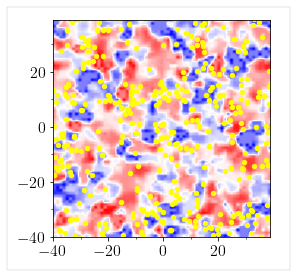

In [337]:
if CompFluc:
    
    PlotAttrs = {
                'zscore' : True,
                'scale' : 'linear',
                'xlabel' : '', #r'$x$(\r{A})', 
                'ylabel' : '', #r'$y$(\r{A})',
                'DrawFrame':(0.21,0.09,0.15,0.06,0.1),
                'colorbar':False,
#                'vmin':-0.5,
#                'vmax':+2.1,
                 'Plot' : 'True',
                'frac':1.0,
                'title':'mapDeltaSro.%s.png'%itime,
                'color':'yellow',
                's':20,
#                'ticklabels': True,
                'dpi':300,
                }
    #--- plot
#     (xlin, ylin, zlin), (xv, yv, zv), delta_intrp = Intrp(atoms, box, 'tmp',
#                     Plot = True,
#     #                title='mapCxyxy.%s.png'%itime,
#     #                    cmap='Greys',
#     #                    colorbar=True,
#                     zscore=True,
#     #                DrawFrame=(0.21,0.06,0.15,0.06,0.1),
#                     xlabel = '', ylabel = '',
#     #                    vmin=,vmax=,
#                    )
    #--- plot with ico
    vor = lp.Atoms( **lmpVor.coord_atoms_broken[itime].to_dict(orient='series') )
    #
    (xlin, ylin, zlin), (xv, yv, zv), delta_intrp =\
    IntrpScatter(
                    atoms, box, 'tmp',
                    vor,
                    **PlotAttrs
                   )

## Plot CG field

In [221]:
def plott(sarr,xlin,ylin,zlin,box, title):
    nx,ny,nz = len(xlin), len(ylin), len(zlin)
    value = np.c_[sarr].reshape(((ny,nx,nz)))
    CellVectorOrtho, VectorNorm = lp.GetOrthogonalBasis( box.CellVector ) #--- box length
    #--- xy plane
    nzl=[0]
    val = Get2dSlice( value, zlin, 
                      zlin[-1], nzll=nzl  )
    nzz=nzl[0]
    
#     pdb.set_trace()
#     print(val.max())
    PltBitmap(val, 
              xlabel = r'$x$(\r{A})', ylabel = r'$y$(\r{A})',
              xlim=VectorNorm[0]*np.array([-0.5,0.5]),ylim=VectorNorm[1]*np.array([-0.5,0.5]),
              zscore = False,
              frac = 1.0, #--- plot a patch
              title = title,
              colorbar=True,
            )
    
if CompFluc:
    plott(df_comp['deltaa'].astype(float),xlin,ylin,zlin,box, 'delta_map.png')

ValueError: cannot reshape array of size 8820 into shape (77,69,77)

## Crltns

### with d2min

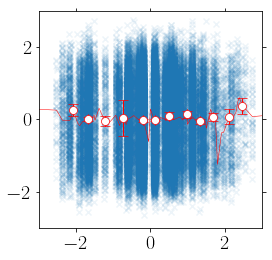

0.0051534393925736265

In [143]:
if CompFluc:
    d2min = lp.Atoms( **lmpDmin.coord_atoms_broken[itime].to_dict(orient='series') )
    d2min.tmp = d2min.d2min
    #
    ScatterXY(  atoms,d2min,
                Plot = True, 
                PLOT_AVERAGE = True,
                nbins_per_decade = 12,
                xscale = 'linear',
                yscale = 'log',
                zscore = True,
                xlim=np.array([-1,1,-1,1])*3,
    #            title = 'scatterModuRho.png',
    #            axisLabels=(r'$\mu$',r'$D^2_{min}$'),
    #            xerr = None
                )            

### with SRO

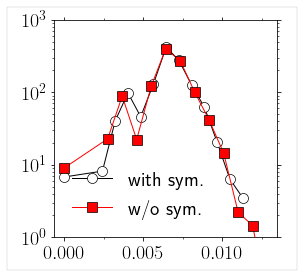

In [340]:
if CompFluc:
    hist, edges, error =\
    Pdf( pd.DataFrame(atoms.__dict__).iloc[GetFullIcosahedra( vor )].tmp,
        density=True,
        linscale=True,
        n_per_decade=16,
        )
#
    hist2, edges2, error2 =\
    Pdf( pd.DataFrame(atoms.__dict__).iloc[~GetFullIcosahedra( vor )].tmp,
        density=True,
        linscale=True,
        n_per_decade=16,
        )
#---plot
    attrs={ 
            'color':'black',
            'markersize':10,
            'marker':'o',
            'markerfacecolor':'white',
            'markeredgecolor':'black',#None,
            'label':r'with sym.',
#           'markevery':int(len(Xbin)/10.0),
#           'errorevery':int(len(Xbin)/10.0),
           'markeredgewidth':0.7,
            'linewidth':1, 
           'barsabove':None,
           'capsize':5,
           'capthick':1,
           'elinewidth':1,
          }
#---
    ax =    PltErr(edges,hist, 
           yerr=None,#error, 
           attrs = attrs,
           Plot = False,
            yscale='log',
          )
#--- 2nd plot
    attrs={ 
            'color':'red',
            'markersize':10,
            'marker':'s',
            'markerfacecolor':None,
            'markeredgecolor':'black',
            'label':'w/o sym.',
#           'markevery':int(len(Xbin)/10.0),
#           'errorevery':int(len(Xbin)/10.0),
           'markeredgewidth':0.7,
            'linewidth':1, 
           'barsabove':None,
           'capsize':5,
           'capthick':1,
           'elinewidth':1,
         }
    
    PltErr(edges2,hist2, 
           yerr=None,#error2, 
           attrs = attrs,
           Plot = True,
    #       xstr=r'$\mu$(Gpa)',
    #       ystr=r'Histogram',
            yscale='log',
           ax=ax,
           legend=True,
            ylim = (1e0,1e3),
    #        xlim = (-500,500),
            DrawFrame=(0.21,0.09,0.15,0.06,0.1),
            title='pdfDelta.%s.png'%itime,
            dpi=300,

          )

In [282]:
GetMismatch(lmpData,2000000,AtomicRadius)

0.006973932876198204

In [284]:
np.mean(atoms.tmp)

0.0069347623381881005

# bar chart

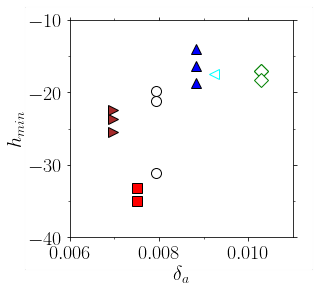

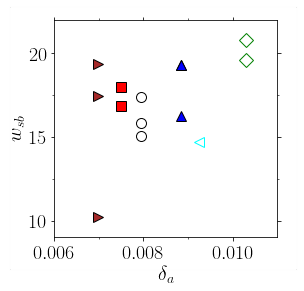

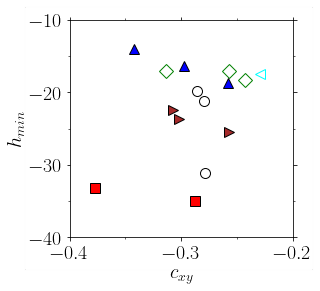

In [120]:
if not RemoteMachine:

    ax_hmin=    PlotPaperVersionScatter( 2, #--- path:
                            xindx=6, colx = 0, #--- x: delta (1st column)
                            yindx=5, coly = 1, #--- y: hmin( 2nd column)
                       xlabel=r'$\delta_a$',
                       ylabel=r'$h_{min}$',
                       xlim=(0.006,0.011),
                       ylim=(-40.0,-10.0),
                    )

    ax_wsb=    PlotPaperVersionScatter( 2, #--- path:
                                xindx=6, colx = 0, #--- x: delta (1st column)
                                yindx=3, coly = 1, #--- y: hmin( 2nd column)
                            xlabel=r'$\delta_a$',
                            ylabel=r'$w_{sb}$',
                            xlim=(0.006,0.011),
                            ylim=(9.0,22.0),
                        )


    ax_cxy = PlotPaperVersionScatter( 2, #--- path:
                            xindx=4, colx = 1, #--- x: cxy (2nd column)
                            yindx=5, coly = 1, #--- y: hmin( 2nd column)
                            xlabel=r'$c_{xy}$',
                            ylabel=r'$h_{min}$',
                         xlim=(-0.4,-0.2),
                        ylim=(-40.0,-10.0),
    #                        legend = True,
    #                        yscale='log',
                           )

In [246]:
if not RemoteMachine:
    strain_indx=-1
    X=np.c_[
    list(map(lambda x:ax_hmin.lines[x].get_ydata()[strain_indx],range(len(ax_hmin.lines)))), #--- hmin
    list(map(lambda x:ax_hmin.lines[x].get_xdata()[strain_indx],range(len(ax_hmin.lines)))), #--- delta
    list(map(lambda x:ax_wsb.lines[x].get_ydata()[strain_indx],range(len(ax_wsb.lines)))),   #--- wsb
    list(map(lambda x:ax_cxy.lines[x].get_xdata()[strain_indx],range(len(ax_cxy.lines)))),   #--- cxy
    ]
    print('X.shape=',X.shape)

X.shape= (18, 4)


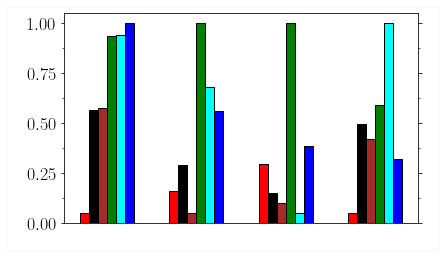

In [132]:
def Scale(d):
    xmin=np.min(list(d.values()))
    xmax=np.max(list(d.values()))
    for key in d:
        x=(d[key]-xmin)/(xmax-xmin)
        d[key]=x if x >0.0 else 0.05

# ********* ************************************************** ***************************************
# Importing libraries and font formating
# **** ************************************************** ********************************************
if not RemoteMachine:
    import numpy as eg
    import matplotlib .pyplot as plt
    import matplotlib.ticker as ticker
    from matplotlib.ticker import AutoMinorLocator
    plt.rc ('font', family = 'Sans', serif = 'Computer Modern Roman', size = 12)
    plt.rc ('text', usetex = True)
    plt.rc ('xtick', labelsize = 18)
    plt.rc ('ytick', labelsize = 18)

    fig = plt.figure ()
    ax = fig.add_axes ([0.14, 0.15, 0.82, 0.73])
#    ax.set_ylim (0,1.1)
    ax.tick_params (axis = 'both', which = 'both', direction = 'out', right = True, top = True, labelsize = 18)
    ax.xaxis.set_minor_locator (AutoMinorLocator (2))
    ax.yaxis.set_minor_locator (AutoMinorLocator (2))

    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
        
        
    #--- scale
    nglass=6
    nrun=3
    #
    keyg= ['FeNi','CoNiFe','CoNiCrFe','CoCrFeMn','CoNiCrFeMn','Co5Cr2Fe40Mn27Ni26']
    #--- reshape & compute mean
    col=0
    xx=X[:,col].reshape((nglass,nrun))
    delta = dict(zip(keyg,np.mean(xx,axis=1,where=~np.isnan(xx))))
    Scale(delta)
    #
    col=1
    xx=X[:,col].reshape((nglass,nrun))
    hmin = dict(zip(keyg,np.mean(xx,axis=1,where=~np.isnan(xx))))
    Scale(hmin)
    #
    col=2
    xx=X[:,col].reshape((nglass,nrun))
    wsb = dict(zip(keyg,np.mean(xx,axis=1,where=~np.isnan(xx))))
    Scale(wsb)
    #
    col=3
    xx=X[:,col].reshape((nglass,nrun))
    cxy = dict(zip(keyg,np.mean(xx,axis=1,where=~np.isnan(xx))))
    Scale(cxy)
    
    #--- sort based on a specific measured quantity
    tmp = hmin #delta
    slist=[[tmp[key],key,colors[indxx]] for key,indxx in zip(tmp,range(1024))]
    slist.sort()
    Glasslist=np.array(slist)[:,1]
    colors=np.array(slist)[:,2]
    
    #--- quantities
#    X = ['$\delta_a$','$h_{min}$','$w_{sb}$','$c_{xy}$']
    X = ['$h_{min}$','$\delta_a$','$w_{sb}$','$c_{xy}$']
    X_axis = np.arange(len (X))
    
    #--- plot
    for GlassType, marker, color, fillstyle, indxx in list(zip( Glasslist,markers, colors, fillstyles,range(20))):

        ax.bar(X_axis - 0.3+indxx*0.1, 
#               [delta[GlassType],hmin[GlassType],wsb[GlassType],cxy[GlassType]], 
               [hmin[GlassType],delta[GlassType],wsb[GlassType],cxy[GlassType]], 
               0.1, color =color, edgecolor ='black', label =GlassType)
#    plt.xticks(X_axis, X)
    ax.axes.xaxis.set_visible(False)
#    plt.ylabel("Observables")
#    plt.legend(bbox_to_anchor=(1,1))
    DrawFrame(ax, 0.16,0.06,0.13,0.03,0.04)
    #
    plt.savefig('barchart.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
#     plt.show ()

metrics= {0: {'FeNi': -24.056614682249347, 'CoNiFe': -34.081323684193194, 'CoNiCrFe': -17.487451523542404, 'CoCrFeMn': -16.343125618373353, 'CoNiCrFeMn': -17.405302442610264, 'Co5Cr2Fe40Mn27Ni26': -23.832498244941235}, 1: {'FeNi': 0.007936586225505048, 'CoNiFe': 0.007502533224194396, 'CoNiCrFe': 0.010289512237036523, 'CoCrFeMn': 0.008838300533593824, 'CoNiCrFeMn': 0.009240771894279727, 'Co5Cr2Fe40Mn27Ni26': 0.006972035495180782}, 2: {'FeNi': 16.095755612713045, 'CoNiFe': 17.446272847844178, 'CoNiCrFe': 23.85055146670533, 'CoCrFeMn': 18.27395945913044, 'CoNiCrFeMn': 14.728425974025981, 'Co5Cr2Fe40Mn27Ni26': 15.676099141092196}, 3: {'FeNi': -0.28135338221233247, 'CoNiFe': -0.3323517062111617, 'CoNiCrFe': -0.2714970300874306, 'CoCrFeMn': -0.2995402299612517, 'CoNiCrFeMn': -0.22980893322512733, 'Co5Cr2Fe40Mn27Ni26': -0.288908150257608}}


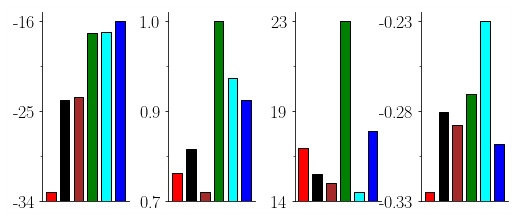

In [247]:
# ********* ************************************************** ***************************************
# Importing libraries and font formating
# **** ************************************************** ********************************************
if not RemoteMachine:
    import numpy as eg
    import matplotlib .pyplot as plt
    import matplotlib.ticker as ticker
    from matplotlib.ticker import AutoMinorLocator
    plt.rc ('font', family = 'Sans', serif = 'Computer Modern Roman', size = 12)
    plt.rc ('text', usetex = True)
    plt.rc ('xtick', labelsize = 18)
    plt.rc ('ytick', labelsize = 18)



    colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
    fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
    markers=['o','s','D','^','<','>','v']
        
        
    #--- scale
    nglass=6
    nrun=3
    metric={}
    #
    keyg= ['FeNi','CoNiFe','CoNiCrFe','CoCrFeMn','CoNiCrFeMn','Co5Cr2Fe40Mn27Ni26']
    #--- reshape & compute mean
    cols = X.shape[1]
    for col in range(cols):
        xx=X[:,col].reshape((nglass,nrun))
        metric[col] = dict(zip(keyg,np.mean(xx,axis=1,where=~np.isnan(xx))))
#    print('metrics.shape=',metric.shape)
    print('metrics=',metric)
#    Scale(delta)
    
    #--- sort based on a specific measured quantity
    tmp = metric[0]
    slist=[[tmp[key],key,colors[indxx]] for key,indxx in zip(tmp,range(1024))]
    slist.sort()
    Glasslist=np.array(slist)[:,1]
    colors=np.array(slist)[:,2]
    
    #--- quantities
    X_axis = np.arange(len (metric))
    
    #--- plot
    fig = plt.figure(figsize=(7,3))
    ax={}
    for col in range(cols):
        ax[col] = fig.add_subplot(1,4,col+1)

    fig.tight_layout(pad=-.1)
    for col in range(cols):

        data = metric[col]
        tmp = data.copy()
        Scale(data)
        
        for GlassType, color, fillstyle, indxx in list(zip( Glasslist, colors, fillstyles,range(20))):

        
            ax[col].bar(range(nglass)[indxx], 
                   data[GlassType],
                   width=.7,
                   color =color, edgecolor ='black', label =GlassType)
            xmin = np.min(list(tmp.values()))
            xmax = np.max(list(tmp.values()))
            
            if col == 1 : #--- delta
                ax[col].yaxis.set_ticklabels([r'%2.1f%%'%(100*xmin),r'%2.1f%%'%(100*(xmin+xmax)/2),r'%2.1f%%'%(100*xmax)])
            elif col == 0 or col == 2: #--- hmin & wsb
                ax[col].yaxis.set_ticklabels(['%d'%(xmin),'%d'%((xmin+xmax)/2),'%d'%(xmax)])
            elif col == 3: #--- cxy
                ax[col].yaxis.set_ticklabels(['%3.2f'%(xmin),'%3.2f'%((xmin+xmax)/2),'%3.2f'%(xmax)])
                
                
            ax[col].yaxis.set_ticks([0,0.5,1])
        #

    for ii in range(cols):
        ax[ii].axes.xaxis.set_visible(False)
        ax[ii].spines['right'].set_visible(False)
        ax[ii].spines['top'].set_visible(False)
        ax[ii].yaxis.set_minor_locator (AutoMinorLocator (2))

    DrawFrame(ax[0], 0.4,4.4,0.06,0.03,0.01)
    #
    plt.savefig('barchart2nd.png',dpi=2*75,bbox_inches='tight',pad_inches=0.0)
    plt.show ()

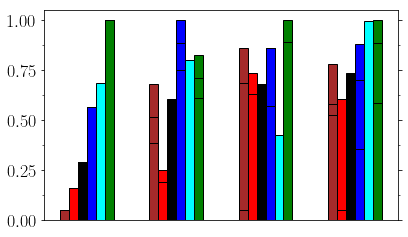

In [277]:
# def Scale(d):
# #    pdb.set_trace()
#     xmin=np.min([item for key in d for item in d[key]]) #list(d.values())#np.min(np.array().flatten())
#     xmax=np.max([item for key in d for item in d[key]])
#     for key in d:
#         x=(np.array(d[key])-xmin)/(xmax-xmin)
#         x[x==0.0]=0.05
#         d[key]=x #if x >0.0 else 0.05

# # ********* ************************************************** ***************************************
# # Importing libraries and font formating
# # **** ************************************************** ********************************************
# if not RemoteMachine:
#     import numpy as eg
#     import matplotlib .pyplot as plt
#     import matplotlib.ticker as ticker
#     from matplotlib.ticker import AutoMinorLocator
#     plt.rc ('font', family = 'Sans', serif = 'Computer Modern Roman', size = 12)
#     plt.rc ('text', usetex = True)
#     plt.rc ('xtick', labelsize = 18)
#     plt.rc ('ytick', labelsize = 18)

#     fig = plt.figure ()
#     ax = fig.add_axes ([0.14, 0.15, 0.82, 0.73])
# #    ax.set_ylim (0,1.1)
#     ax.tick_params (axis = 'both', which = 'both', direction = 'out', right = True, top = True, labelsize = 18)
#     ax.xaxis.set_minor_locator (AutoMinorLocator (2))
#     ax.yaxis.set_minor_locator (AutoMinorLocator (2))

#     colors = ['black','red','green','blue','cyan','brown','grey','magenta','orange','yellow']
#     fillstyles=['white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None,'white',None]
#     markers=['o','s','D','^','<','>','v']
    
#     #--- store different measurements
#     sarr_Mismatch = {}
#     sarr_StrsDrop = {}
#     sarr_BandWidth = {}
#     sarr_Cxy = {}
#     for GlassType, marker, color, fillstyle, indxx in list(zip( [ 
#                                         'FeNi',
#                                          'CoNiFe',
#                                           'CoNiCrFe',
#                                           'CoCrFeMn',
#                                            'CoNiCrFeMn',
#                                           'Co5Cr2Fe40Mn27Ni26'
#                                         ],markers, colors, fillstyles,range(20))):

#         sarr  = MultipleFrames2nd(path='HminMismatch2nd%s'%GlassType,nrun=3,title='NegativeModulus.txt',ncols=2)
#         sarr_StrsDrop[GlassType]= -sarr[:,1][~np.isnan(sarr[:,1])]
#         #---
#         sarr = MultipleFrames2nd(path='HminMismatch2nd%s'%GlassType,nrun=3,title='rc_d2min.txt',ncols=3)
#         xdata = sarr[:,1:3] #--- 2nd and 3rd cols are widths
#         indices = np.any(~np.isnan(xdata),axis=1)
#         sarr_BandWidth[GlassType] = xdata[~np.isnan(xdata)]
#         #---
#         sarr = MultipleFrames2nd(path='HminMismatch2nd%s'%GlassType,nrun=3,title='YieldDelta.txt',ncols=2)
#         sarr_Mismatch[GlassType] = sarr[:,0][~np.isnan(sarr[:,0])]
#         #---
#         cxy=[]
#         for irun in range(3):
#             try:
#                 sarr  = np.loadtxt('d2minRatio%s/Run%s/crsD2minRhoSro.txt'%(GlassType,irun))
#                 hmodu = np.loadtxt('widthMismatch%s/Run%s/NegativeModulus.txt'%(GlassType,irun))[1]
#                 #--- fliter
#                 xdata = sarr[:,1] #--- first 2nd col is stress drop
#                 cxy.append(np.mean(xdata[-1-8:-1])) #--- mean of the last 10 points
#             except:
#                 continue
#         sarr_Cxy[GlassType] = cxy
        
        
#     #--- scale
#     Scale(sarr_StrsDrop)
#     Scale(sarr_BandWidth)
#     Scale(sarr_Mismatch)
#     Scale(sarr_Cxy)
    
#     #--- sort based on a specific measured quantity    
#     slist=[[np.mean(sarr_Mismatch[key]),key,colors[indxx]] for key,indxx in zip(sarr_Mismatch,range(32))]
#     slist.sort()
#     Glasslist=np.array(slist)[:,1]
#     colors=np.array(slist)[:,2]
    
#     #--- quantities
#     X = ['$\delta_a$','$h_{min}$','$w_{sb}$','$c_{xy}$']
#     X_axis = np.arange(len (X))
    
#     #--- plot
#     for GlassType, marker, color, fillstyle, indxx in list(zip( Glasslist,markers, colors, fillstyles,range(20))):
#         for iprop,prop in zip(range(len(X_axis)),
#                               [sarr_Mismatch[GlassType], sarr_StrsDrop[GlassType],sarr_BandWidth[GlassType],sarr_Cxy[GlassType]]): 
#             prop=list(prop)
#             prop.sort(reverse=True)
#             for irun in range(3):
#                 try:
#                     ax.bar([X_axis[iprop] - 0.3+indxx*0.1], [prop[irun]],
#                    0.1, color =color, edgecolor ='black', label =GlassType)
#                 except:
#                     continue
# #    plt.xticks(X_axis, X)
#     ax.axes.xaxis.set_visible(False)
# #    plt.ylabel("Observables")
# #    plt.legend(bbox_to_anchor=(1,1))
#     fig.savefig ("barchart.png",dpi=150)
# #     plt.show ()

# Correlation Matrix

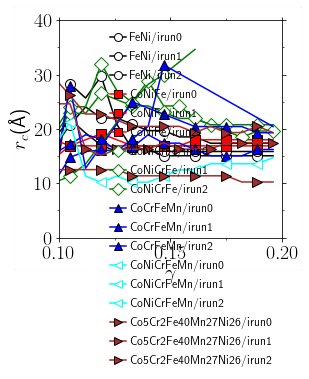

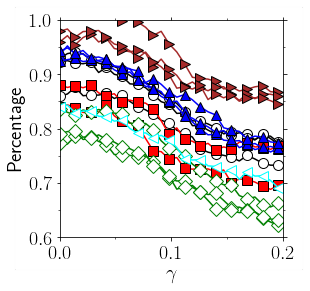

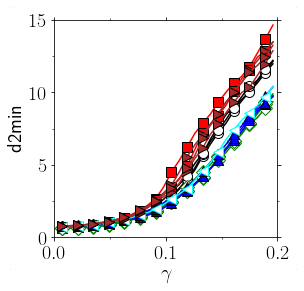

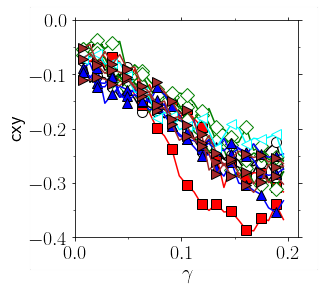

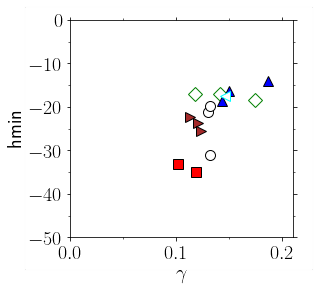

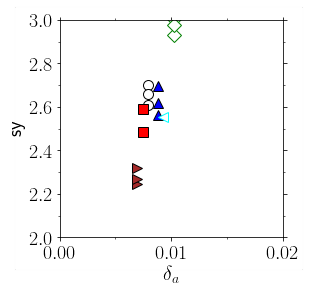

error while reading /Users/Home/Desktop/Tmp/txt/git/CrystalPlasticity/postprocess/PairCrltnT300/CoNiFe/Run0/gr_peak_gamma.txt
error while reading /Users/Home/Desktop/Tmp/txt/git/CrystalPlasticity/postprocess/PairCrltnT300/CoNiCrFeMn/Run0/gr_peak_gamma.txt
error while reading /Users/Home/Desktop/Tmp/txt/git/CrystalPlasticity/postprocess/PairCrltnT300/CoNiCrFeMn/Run2/gr_peak_gamma.txt


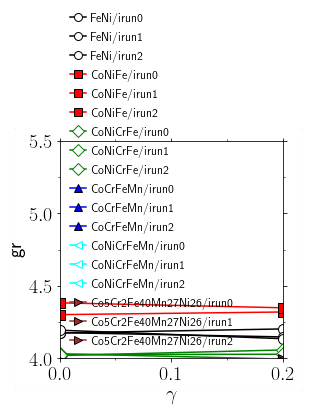

In [253]:
if not RemoteMachine:
    
    attrs = {           'xlabel':r'$\gamma$',
                        'ylabel':r'$r_c$(\r{A})',
                        'ylim':(0,40),
                        'xlim':(0.1,.2),
                        'PlotMean' : False,
                        'legend' : True,
    #                        yscale='log',
                        'borderwidth' : 0.01,
            }
    #---
    ax_ws = GetMetrics(
                        pathh_indx = 2,
                        file0_indx = 3,
                        #
                        **attrs,
                      )
    #---
    ax_ico = GetMetrics(
                        pathh_indx = 2,
                        file0_indx = 1,
                        #
                        xlabel=r'$\gamma$',
                        ylabel=r'Percentage',
                        ylim=(0.6,1),
                        xlim=(0.0,.2),
                      )
    #---
    ax_d2min = GetMetrics(
                        pathh_indx = 2,
                        file0_indx = 2,
                        #
                        xlabel=r'$\gamma$',
                        ylabel=r'd2min',
                        ylim=(0.0,15),
                        xlim=(0.0,.2),
                      )
    #---
    ax_cxy = GetMetrics(
                        pathh_indx = 2,
                        file0_indx = 4,
                        #
                        xlabel=r'$\gamma$',
                        ylabel=r'cxy',
                        ylim=(-0.4,0),
                        xlim=(0.0,.21),
                      )
    #---
    ax_hmin = GetMetrics(
                        pathh_indx = 2,
                        file0_indx = 5,
                        #
                        xlabel=r'$\gamma$',
                        ylabel=r'hmin',
                        ylim=(-50,0),
                        xlim=(0.0,.21),
                      )
    #---
    ax_sy = GetMetrics(
                        pathh_indx = 2,
                        file0_indx = 6,
                        #
                        xlabel=r'$\delta_a$',
                        ylabel=r'sy',
                        ylim=(2,3),
                        xlim=(0.0,.02),
                      )
    #---
    ax_gr = GetMetrics(
                        pathh_indx = 0,
                        file0_indx = 7,
                        #
                        xlabel=r'$\gamma$',
                        ylabel=r'gr',
                        legend = True,
                        ylim=(4,5.5),
                        xlim=(0.0,.2),
                      )

In [254]:
if not RemoteMachine:
    strain_indx=-1
    X=np.c_[
    list(map(lambda x:ax_ws.lines[x].get_ydata()[strain_indx],range(len(ax_ws.lines)))),
    list(map(lambda x:ax_ico.lines[x].get_ydata()[strain_indx],range(len(ax_ico.lines)))),
    list(map(lambda x:ax_gr.lines[x].get_ydata()[0],range(len(ax_gr.lines)))),
    list(map(lambda x:ax_d2min.lines[x].get_ydata()[strain_indx],range(len(ax_d2min.lines)))),
    list(map(lambda x:ax_cxy.lines[x].get_ydata()[strain_indx],range(len(ax_cxy.lines)))),
    list(map(lambda x:ax_hmin.lines[x].get_ydata()[strain_indx],range(len(ax_hmin.lines)))),
    list(map(lambda x:ax_sy.lines[x].get_ydata()[strain_indx],range(len(ax_sy.lines)))),
    list(map(lambda x:ax_sy.lines[x].get_xdata()[strain_indx],range(len(ax_sy.lines)))),
    ]
    print('X.shape=',X.shape)

X.shape= (18, 8)


          delta        ws       ico        gr     d2min       cxy      hmin  \
delta  1.000000  0.580452 -0.850879 -0.312320 -0.886660  0.350656  0.633484   
ws     0.580452  1.000000 -0.553000 -0.069545 -0.399428  0.277581  0.239633   
ico   -0.850879 -0.553000  1.000000 -0.159189  0.600495 -0.200606 -0.248221   
gr    -0.312320 -0.069545 -0.159189  1.000000  0.639760 -0.316212 -0.754765   
d2min -0.886660 -0.399428  0.600495  0.639760  1.000000 -0.522423 -0.802783   
cxy    0.350656  0.277581 -0.200606 -0.316212 -0.522423  1.000000  0.481383   
hmin   0.633484  0.239633 -0.248221 -0.754765 -0.802783  0.481383  1.000000   
sy     0.888267  0.569669 -0.864782  0.003911 -0.690007  0.225054  0.383635   

             sy  
delta  0.888267  
ws     0.569669  
ico   -0.864782  
gr     0.003911  
d2min -0.690007  
cxy    0.225054  
hmin   0.383635  
sy     1.000000  


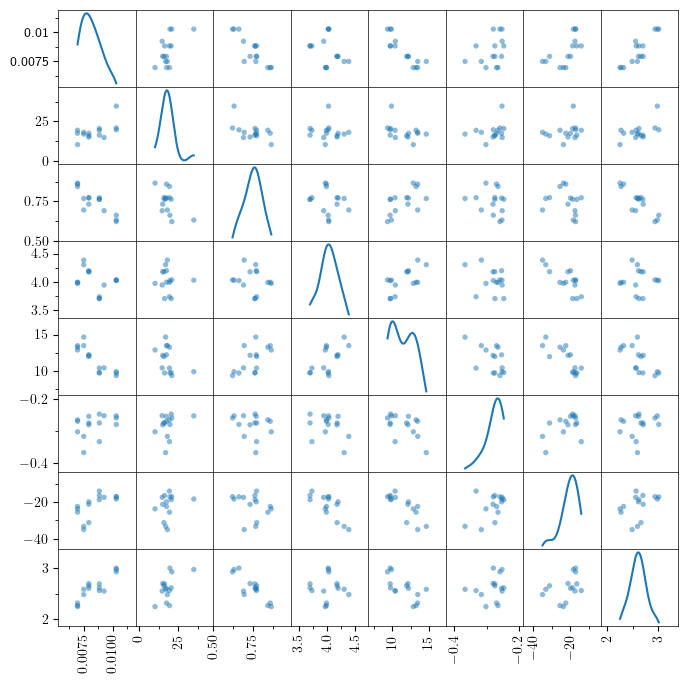

In [261]:
if not RemoteMachine:
    sns.reset_defaults()
    #--- labels
    # ylabel=np.array([0,0,0])
    # for i in range(1,6):
    #     ylabel=np.c_[ylabel,np.ones(3,dtype=int)*i]
    # ylabel = ylabel.T.flatten()

    #
    #indices = np.all(~np.isnan(X),axis=1) #--- remove nans
    df = pd.DataFrame(X,columns=['ws','ico','gr','d2min','cxy','hmin','sy','delta']) #,dtype=float)


    #    display(df)
    markers=['o','s','D','^','<','>']
    colors = ['black','red','green','blue','cyan','brown']
    plt.rcParams['text.usetex'] = True
    #
    ms=scatter_matrix( df[['delta','ws','ico','gr','d2min','cxy','hmin','sy']],
                      figsize=(8, 8),
                    range_padding = 1,
                    s=15.0,
                    diagonal='kde',
    #               c=df['label'],
                   marker='o',
                  )
    for i in range(X.shape[1]):
        for j in range(X.shape[1]):
#            ms[i,i].set_visible(False)
            ms[i,j].set_xlabel('')
            ms[i,j].set_ylabel('')

            ms[i,j].spines['top'].set_linewidth(.5)
            ms[i,j].spines['right'].set_linewidth(.5)
            ms[i,j].spines['bottom'].set_linewidth(0.5)
            ms[i,j].spines['left'].set_linewidth(0.5)

            ms[i,j].tick_params(labelsize=10,which='both',axis='both', top=False, right=False)
            PutMinorTicks(ms[i,j])

    plt.savefig('scatter_matrix.png',dpi=2*75,bbox_inches='tight',
               pad_inches=0.1)

    corr = df[['delta','ws','ico','gr','d2min','cxy','hmin','sy']].corr()
    print(corr)
    plt.show()

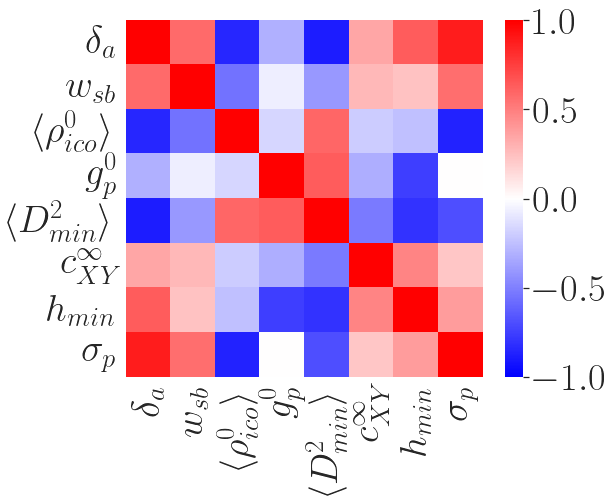

In [259]:
if not RemoteMachine:
    import seaborn as sns

    sns.set(font_scale=3.5, rc={'text.usetex' : True})

    xticklabels = [r'$\delta_a$',r'$w_{sb}$',r'$\langle\rho_{ico}^0\rangle$',r'$g_p^0$',r'$\langle D^2_{min}\rangle$',r'$c^\infty_{XY}$',r'$h_{min}$',r'$\sigma_p$']

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    sns.heatmap(corr,
    #            annot=True,
                cmap = 'bwr',
    #            fmt = '%2.1f',
                vmin=-1, 
                vmax=1,
                square = True,
                xticklabels=xticklabels,
                yticklabels=xticklabels,
                ax=ax,
                cbar_kws={"shrink": .82}
               )
    plt.savefig('correlation_matrix.png',dpi=2*75,bbox_inches='tight',
               pad_inches=0.0)
    plt.show()
    
#    sns.reset_defaults()


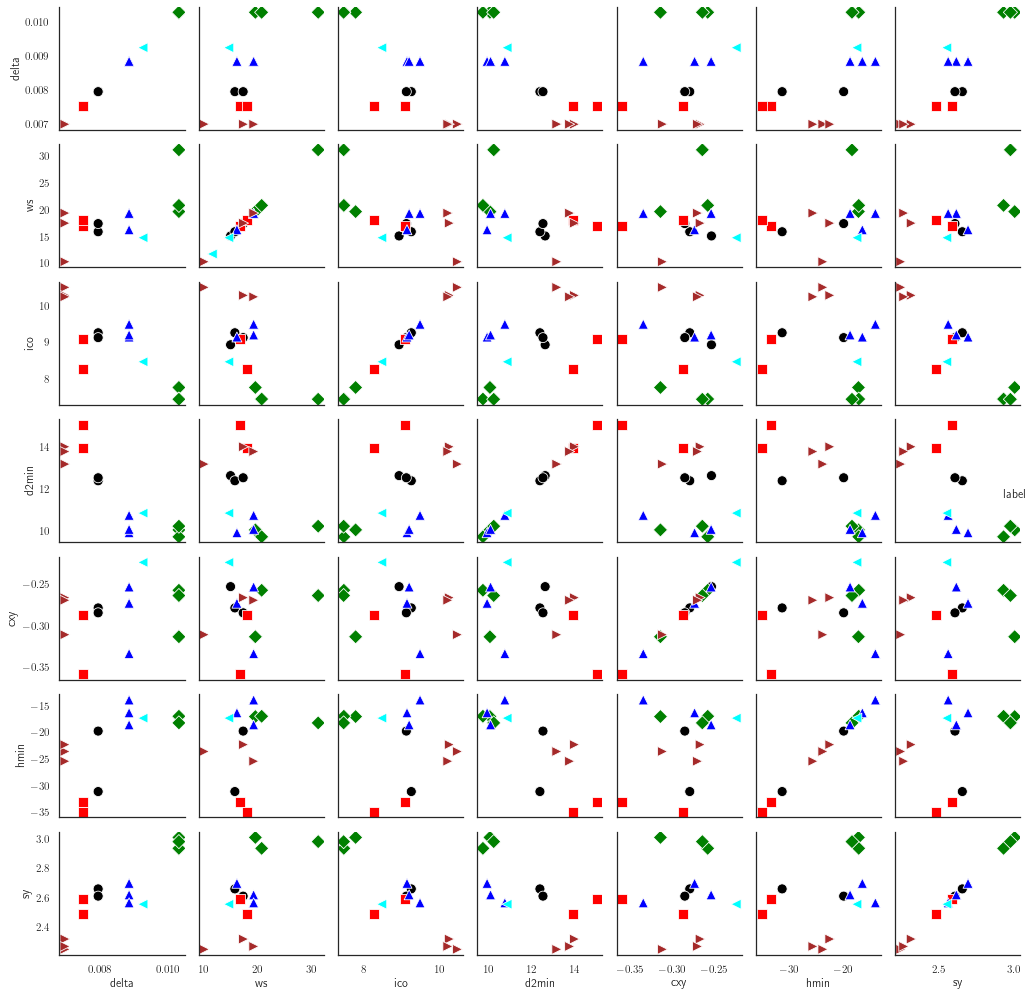

In [120]:
# import seaborn as sns
# #
# sns.set_theme(style="ticks")
# sns.set(font_scale=1.0, rc={'text.usetex' : True})
# sns.set_style("white")

# #
# markers=['o','s','D','^','<','>']
# colors = ['black','red','green','blue','cyan','brown']
# #
# g = sns.pairplot(df, 
#              vars=['delta','ws','ico','d2min','cxy','hmin','sy'],
#              hue="label",
#              diag_kind=None,
#              markers=markers,
#              palette=colors,
#              size = 2,
# #             corner = True,
#              plot_kws={'s':100.0,'legend' : False},
            
#             )
# #fig.tick_params(labelsize=5)
# g.fig.tight_layout()
# plt.show()

# Machine learning

* NeighList = True #--- build neighbor list 
* DminAnalysis = True #--- d2min as labels


## Descriptors

In [28]:
def GetAttribute(df,rbar,sigma):
    sigma2=sigma*sigma
    rho=df.apply(lambda x: np.exp(-0.5*(x.DIST-rbar)**2/sigma2),axis=1) #--- Eq 5 in Ma et al. Materials Today 40 (2020)
    #---
    tmp=pd.DataFrame(np.c_[df.id,rho],columns=['id','rho'])
    tmp_sum=tmp.groupby(by='id').rho.agg(np.sum)
    return np.array(tmp_sum)


if ml:
    
    #--- structure function
    if not ReadDisc:
        df = lmpNeigh.coord_atoms_broken[itime] #--- ref. state!!

        #--- radial
    #    rbar = 1.0*rpeak #--- density around rbar
    #    x = GetAttribute(df,rbar,sigma) #--- attribute vector
        #
        rpeak = dlgr0
        sigma=0.05*rpeak
        rbars = np.arange(0.6*rpeak,cutoff,sigma)
        print('num(radial features)=%s'%(len(rbars)))
        t0=time.time()    
        structFuncRad = np.array(list(map(lambda x:GetAttribute(df,x,sigma),rbars))).T #--- attribute matrix
        print('radial struct t=%s s'%(time.time()-t0))
        print('structFuncRad.shape=',structFuncRad.shape)
        assert structFuncRad.shape[0] == len(d2min.x), 'some atoms have no neighbors!'

        #--- angular
        cutoffAng = 4.5 #--- 2nd peak
        #--- filter df: decrease cutoff distance for the anglular analysis
        df_filtrd = df[df['DIST']<cutoffAng]
        df_filtrd.reset_index(drop=True,inplace=True)
        #---
        t0=time.time()
#         pdb.set_trace()
        angst = lp.AngularStruct(df_filtrd)
        angst.GetDistAngle()
        print('assemble triplets t=%s s'%(time.time()-t0))
        #--- set params. list
        deltas = np.arange(0.6*rpeak,cutoffAng,3.0*sigma)
        b=np.array([1.0,-1.0])
        c=np.array([0.5,1.0,2.0])
        #
        xx, yy, zz = np.meshgrid(deltas,b,c)
        plist = list(zip(xx.flatten(),yy.flatten(),zz.flatten()))
        print('num(ang. features)=%s'%(len(plist)))
        #
        t0=time.time()    
        structFuncAng = np.array(list(map(lambda x: angst.Get(*x),plist))).T
        print('apply parameters t=%s s'%(time.time()-t0))
        print('structFuncAng.shape=',structFuncAng.shape)


num(radial features)=1
radial struct t=17.697288036346436 s
structFuncRad.shape= (50688, 1)
assemble triplets t=359.75692200660706 s
num(ang. features)=1
apply parameters t=45.35738396644592 s
structFuncAng.shape= (50688, 1)


### Plot

X.shape= (50688, 100)
          0         1         2
0  1.000000  0.979725  0.881227
1  0.979725  1.000000  0.955937
2  0.881227  0.955937  1.000000


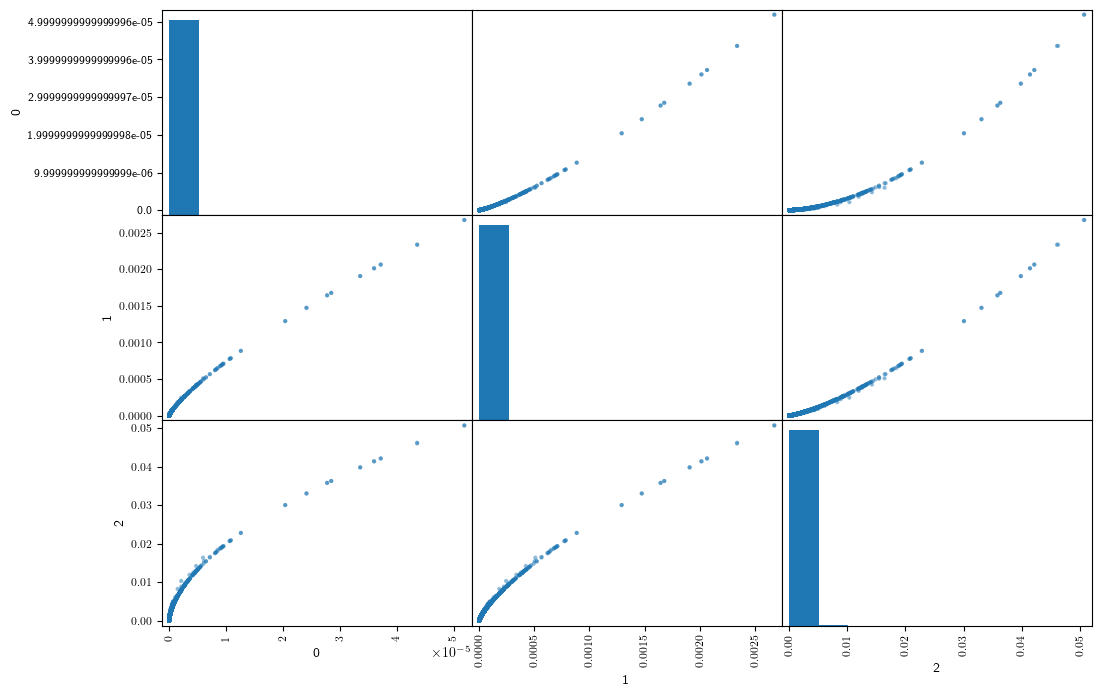

In [520]:
if ml:
    if not ReadDisc: 
        X=np.c_[structFuncRad,structFuncAng]
        if WritDisc:
            with open('features.npy','wb') as f:
                np.save( f, X )
    else:
        with open('features.npy','rb') as f:
            X = np.load(f)
        print('X.shape=',X.shape)
            
    df = pd.DataFrame(X[:,0:3]) #,dtype=float)
#    display(df)
    scatter_matrix(df, figsize=(12, 8))
    print(df.corr())
    plt.show()


In [519]:
# ml=True
# ReadDisc=True
# WritDisc=False

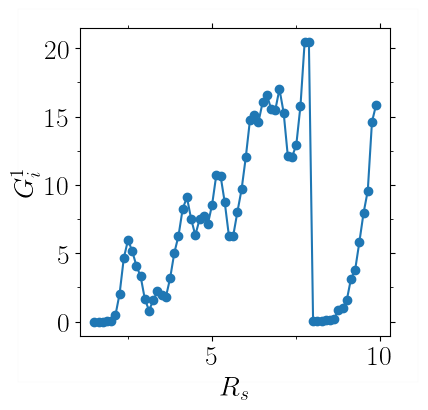

<AxesSubplot:xlabel='$R_s$', ylabel='$G^1_i$'>

In [559]:
rpeak = dlgr0 
sigma=0.05*rpeak
rbars = np.arange(0.6*rpeak,cutoff,sigma)
PltErr(rbars,X[0,0:len(rbars)],
       yerr=None,
       xstr=r'$R_s$',
       ystr=r'$G^1_i$',
       title='G1i.png',
      )

## Training
### dimensionality reduction

In [560]:
from sklearn.svm import LinearSVR, LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

def DimReduction(X,y,test_size=.33):
    #--- data
#    
    assert X.shape[0] == len(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)


    #--- pipeline
    DimReduc = make_pipeline( 
                              StandardScaler(),
                              TSNE(n_components=3,random_state=0),
#                              PCA(n_components=3, random_state=0),
        
                            )
    DimReduc.fit(X_train)
    X_embedded = DimReduc.fit_transform(X_train)
    return X_embedded, X_train, y_train






if ml:
    #--- response vector
    #--- voronoi data
    vor = lp.Atoms( **lmpVor.coord_atoms_broken[itime].to_dict(orient='series') )
    icoFilter = GetFullIcosahedra( vor )
    #--- d2min
#    d2min = lp.Atoms( **lmpDmin.coord_atoms_broken[itime].to_dict(orient='series') ) #--- modulus analysis!!!
    
    
#    data = load_iris()    
    y = {
#            '0':np.c_[np.log10(d2min.d2min) >= mu_divide],
            '1':np.c_[icoFilter]
        }['1']
#    y= X[:,3] >= np.mean(X[:,3])
    #--- 
    X_embedded, X_train, y_train = DimReduction(X,y,test_size=0.7)
    print('X_embedded.shape=',X_embedded.shape)

#print(DimReduc.named_steps['tsne'].explained_variance_ratio_)
            


X_embedded.shape= (15206, 3)


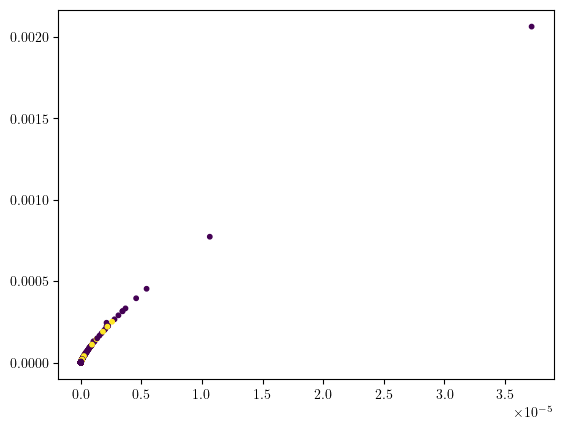

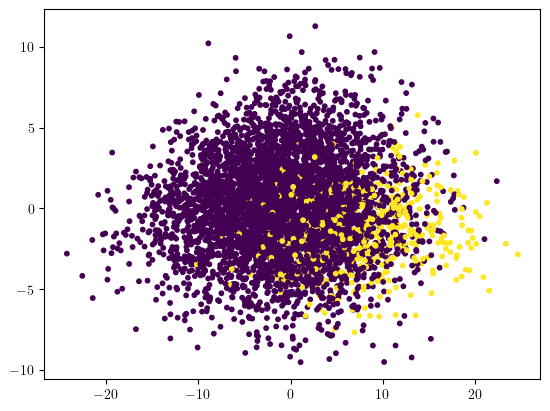

In [539]:
plt.scatter(X_train[:,0],X_train[:,1],s=10,c=y_train)
plt.show()
plt.scatter(X_embedded[:,0],X_embedded[:,1],s=10,c=y_train)
plt.show()

In [561]:
PrintOvito( pd.DataFrame(np.c_[X_embedded,y_train],columns=['x','y','z','type']), 
             open( 'sne_ovito.xyz','w'), 
             footer = 'ITIME=%s'%itime,
             attr_list=['x','y','z','type'] )

### regression/classification

In [ ]:
if ml:
    regr = make_pipeline( 
                          StandardScaler(),
#                          LinearSVR(random_state=0, tol=1e-5,C=1.0,epsilon=.1*np.std(yy)),
#                          LinearSVC(random_state=0, tol=1e-5 ),
#                          LinearRegression(),
                        )
    #--- fit
    regr.fit(xx, yy)
    #--- print
    for key in ['linearsvc']:#regr.named_steps:
#        if 1:
        try:
            #--- mse
            y_true = yy.flatten()
            y_pred = regr.named_steps[key].predict(xx)
            mse = mean_squared_error(y_true*1, y_pred*1)
            #--- print
            print(key,':','coeffs=',regr.named_steps[key].coef_,'mse=',mse)
        except:
            traceback.print_exc()
            continue


## Prediction

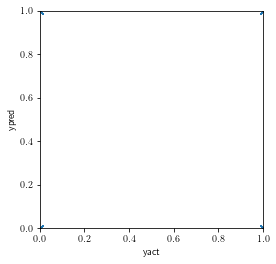

In [835]:
if ml:
    fig = plt.figure(figsize=(4,4))
    ax=fig.add_subplot(111)
    #
    ax.set_xlabel('yact')
    ax.set_ylabel('ypred')
    #
    ax.axis([yy.min(),yy.max(),yy.min(),yy.max()])
    #
    ax.scatter(yy,regr.predict(xx),marker='x',alpha=0.1)
    #
    plt.show()

In [414]:
# def Validate(x,y,C=range(0,40,10),cv_samples=10):
#     mse={}
#     for c in C:
# #    for df in map(int,np.logspace(0,12,20,base=2,endpoint=True)):
#         try:
#             regr = make_pipeline( StandardScaler(),
#                       LinearSVR(random_state=0, tol=1e-5, C=c))
#             regr.fit(x, y)
# #            transfrm = ReturnShapeFunc(x,df)
#             #--- vadidate    
#             scores = cross_validate(reg,  x, y, cv=cv_samples,
#                                          scoring=('r2', 'neg_mean_squared_error'),
#                                          return_train_score=True)
#             mse[c] = np.mean(scores['train_neg_mean_squared_error'])
#         except:
#             continue
#     return mse

# if ml:
#     mse = Validate(X,np.c_[y],C=np.logspace(-3,2,6)) #[0.1,1.0,10.0])



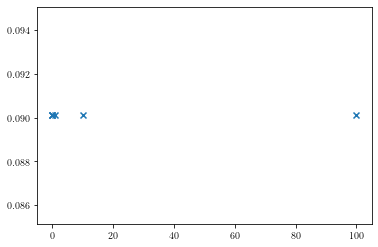

{0.001: -0.09010491853015593,
 0.01: -0.09010491853015593,
 0.1: -0.09010491853015593,
 1.0: -0.09010491853015593,
 10.0: -0.09010491853015593,
 100.0: -0.09010491853015593}

In [415]:
# if ml:
#     try:
#         keys=mse.keys()
#         plt.scatter(keys, [-mse[key] for key in keys],marker='x')
#     #    plt.yscale('log')
#     #    plt.xscale('log')
#     #    plt.ylim(1e-5,1e-2)
#         plt.savefig('cv.png',dpi=75,bbox_inches='tight')
#         plt.show()
#     except:
#         pass
#     mse

In [396]:
# from sklearn.datasets import make_regression
# X, y = make_regression(n_features=1, random_state=0)
# X+=10
# X*=2
# y-=40
# y/=2
# plt.scatter(X,y)
# plt.show()